# 加载模型和数据集

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import copy
import math
from torchvision import models
class Net_cifar100_s(nn.Module):
    def __init__(self):
        super(Net_cifar100_s, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 100)
        # self.fc3 = nn.Linear(84, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        return x
mycfg = {
    'CNN3':  [64, 'M', 64, 'M', 128, 'M', 512, 'M'],
    'CNN4':  [64, 'M', 128, 'M', 128, 'M', 512, 'M'],
    'CNN5':  [64, 'M', 128, 'M', 256, 'M', 512, 'M'],
    'CNN6':  [64, 'M', 128, 'M', 512, 'M', 512, 'M'],
    'CNN7':  [64, 'M', 256, 'M', 512, 'M', 512, 'M'], ### targetmodel
    'CNN8':  [64, 'M', 128, 256, 'M', 512, 'M', 512, 'M'],
    'CNN9':  [64, 64, 'M', 128, 256, 'M', 512, 'M', 512, 'M'],
    'CNN10':  [64, 128, 'M', 128, 256, 'M', 512, 'M', 512, 'M'],
    'CNN11':  [64, 128, 'M', 256, 256, 'M', 512, 'M', 512, 'M'],
}
class Net_cifar100_m(nn.Module):
    def __init__(self, CNN_name='CNN7', dropout=False):
        super(Net_cifar100_m, self).__init__()
        self.query_num = 0
        self.features = self._make_layers(mycfg[CNN_name])
        if dropout:
            self.classifier = nn.Sequential(
                nn.Dropout(0.6),
                nn.Linear(512, 256),
                nn.ReLU(True),
                nn.Linear(256, 100) )
        else:
            self.classifier = nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(True),
                nn.Linear(256, 100) )
        
    def forward(self, x):
        self.query_num += 1
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x, track_running_stats=True),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=2, stride=2)]
        return nn.Sequential(*layers)

class Net_mnist(nn.Module):
    def __init__(self):
        super(Net_mnist, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
class Net_cifar10(nn.Module):
    def __init__(self):
        super(Net_cifar10, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
class Arguments:
    def __init__(self, dataset_name):
        self.N_client_max = 5
        self.N_client = 5
        self.data_name = 'cifar100' if dataset_name == 'cifar100' else 'MNIST' if dataset_name == 'mnist' else 'cifar10'
        self.global_epoch = 10 if dataset_name == 'cifar100' else 10 if dataset_name == 'mnist' else 10
        self.local_epoch = 10 if dataset_name == 'cifar100' else 5 if dataset_name == 'mnist' else 5
        self.save_all_models = False
        self.local_lr = 0.001 if dataset_name == 'cifar100' else 0.01 if dataset_name == 'mnist' else 0.001
        self.train_with_test = True
        self.use_gpu = True
        self.target_client = np.random.randint(0, self.N_client)
        self.cuda_state = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.device_cpu = torch.device('cpu')
        self.image_shape = (3,32,32) if dataset_name == 'cifar100' else (1,28,28) if dataset_name == 'mnist' else (3,32,32)
        self.class_num = 100 if dataset_name == 'cifar100' else 10 if dataset_name == 'mnist' else 10
        self.adv_iter = 60
        self.adv_lr = 0.3 if dataset_name == 'cifar100' else 0.3 if dataset_name == 'mnist' else 0.3
        self.decay_lr = 1
        self.num_evals_boundary = 5000
        self.beta_init = 0
        self.beta_step_size = 0.1
        self.beta_max = 2
        self.adv_with_test = True
        self.sample_num = 1000
        self.radius_num = 5
        self.noise_radnum = 100
        self.clear_num = 1036 if dataset_name == 'cifar100' else 2096 if dataset_name == 'mnist' else 1411
         # for tear
        self.target_num = 10

dataset_name = 'cifar10'
if dataset_name == 'cifar100':
    FL_params = Arguments(dataset_name)
#     resnet = models.resnet18(pretrained=True)
#     resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(3,3), stride=(2,2), padding=(3, 3), bias=False)
#     init_GM = resnet  #training acc: 0.73     test acc: 0.43    drawback: hsja is very slow
#     init_GM = Net_cifar100_s()   #training acc: 0.3801           test acc: 0.2089    drawback: tgt_list doesn't have all the classes
    init_GM = Net_cifar100_m()
elif dataset_name == 'mnist':
    FL_params = Arguments(dataset_name)
    init_GM = Net_mnist()
elif dataset_name == 'cifar10':
    FL_params = Arguments(dataset_name)
    init_GM = Net_cifar10()

E:\syn_anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
print(os.getcwd())
def dataloader(data_name = 'cifar100'):
    if data_name == 'cifar100':
        trainset = datasets.CIFAR100('./tear_come/data/cifar100', train=True, download=True, transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
        testset = datasets.CIFAR100('./tear_come/data/cifar100', train=False, download=True, transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    if data_name == 'mnist':
        trainset = datasets.MNIST('./tear_come/data/MNIST', train=True, download=True, transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]))
        testset = datasets.MNIST('./tear_come/data/MNIST', train=False, download=True, transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]))
    if data_name == 'cifar10':
        trainset = datasets.CIFAR10('./tear_come/data/cifar10', train=True, download=True, transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
        testset = datasets.CIFAR10('./tear_come/data/cifar10', train=False, download=True, transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    kwargs = {'num_workers': 0, 'pin_memory': True}
    train_loader = DataLoader(trainset, batch_size=64, shuffle=False, **kwargs)
    test_loader = DataLoader(testset, batch_size=64, shuffle=False, **kwargs)
    split_index = [int(trainset.__len__() / 5)] * 4
    split_index.append(
        int(trainset.__len__() - int(trainset.__len__() / 5) * 4))
    client_dataset = torch.utils.data.random_split(trainset, split_index)
    client_loaders = []
    for ii in range(5):
        client_loaders.append(
            DataLoader(client_dataset[ii], 64, shuffle=False, **kwargs))
    return client_loaders, train_loader, test_loader
client_loaders, train_loader, test_loader = dataloader(dataset_name)
def X_Y_depart(dataloader, mode='train'):
    X_dataset = list()
    Y_dataset = list()
    for img, label in dataloader:
        X_dataset.append(img)
        Y_dataset.append(label)
    X_dataset = torch.vstack(X_dataset)
    Y_dataset = torch.hstack(Y_dataset)
    torch.save(X_dataset, './tear_come/data/' + str(FL_params.data_name) + '/X_{}set.pth'.format(mode))
    torch.save(Y_dataset, './tear_come/data/' + str(FL_params.data_name) + '/Y_{}set.pth'.format(mode))
    return X_dataset, Y_dataset
# X_trainset, Y_trainset = X_Y_depart(train_loader, mode='train')    #torch.Size([50000, 3, 32, 32])    torch.Size([50000])    
# X_testset, Y_testset = X_Y_depart(test_loader, mode='test')   #torch.Size([10000, 3, 32, 32])     torch.Size([10000])
# cifar100: torch.Size([50000, 3, 32, 32])    torch.Size([50000])   torch.Size([10000, 3, 32, 32])     torch.Size([10000])
# mnist: torch.Size([60000, 1, 28, 28])   torch.Size([60000])  torch.Size([10000, 1, 28, 28])      torch.Size([10000])
# cifar10: torch.Size([50000, 3, 32, 32])    torch.Size([50000])   torch.Size([10000, 3, 32, 32])     torch.Size([10000])

E:\postgraduate\paper\TEAR\dbViz-main
Files already downloaded and verified
Files already downloaded and verified


# 训练模型

In [5]:
import torch
import os
import numpy as np
from tear_come.FL_base_function import FL_Train
import copy
import dill
print(os.getcwd())
# init_GM.load_state_dict(torch.load('./data/cifar100/model/model_10.pth'))
model_path = './data/' + str(FL_params.data_name) + '/model/'
all_GMs, all_LMs = FL_Train(init_GM, client_loaders, test_loader, FL_params)
torch.save(all_GMs[-1].state_dict(), model_path+"model_"+str(FL_params.global_epoch)+".pth")

E:\postgraduate\paper\TEAR\dbViz-main\tear_come
FL Training Starting...
Global Federated Learning epoch = 1/10
Local Client No. 1/5, Local Epoch: 1/5, Global Epoch:1/10
Train set: Average acc:  0.9692


KeyboardInterrupt: 

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import copy
from tqdm import tqdm
init_GM.load_state_dict(torch.load('./tear_come/data/' + str(FL_params.data_name) + '/model/model_'+str(FL_params.global_epoch)+'.pth'))
X_trainset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_trainset.pth')              #(allnum, *shape)
Y_trainset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/Y_trainset.pth')              #(allnum,)
X_testset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_testset.pth')              #(allnum, *shape)
Y_testset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/Y_testset.pth')              #(allnum,)
model = copy.deepcopy(init_GM.cuda())

def test(loader, model):
    model.eval()
    correct = 0
    all_num = 0
    with tqdm(total=len(loader.dataset), desc='Progress', unit='units') as pbar:
        for X, Y in loader:
            pred = torch.argmax(model(X.cuda()), dim=-1).cpu()
            correct += torch.sum(pred == Y)
            all_num += len(Y)
            pbar.update(all_num - pbar.n)
        print(correct)
        acc = correct / len(loader.dataset)
        print(acc)
test(train_loader, model)
test(test_loader, model)
# cifar10 训练精度：0.7235, 测试精度：0.6051
# cifar100 训练精度：0.9659, 测试精度：0.5550
# MNIST 训练精度：0.9930, 测试精度：0.9891

Progress: 100%|█████████████████████████████████████████████████████████████| 50000/50000 [00:17<00:00, 2802.18units/s]


tensor(48297)
tensor(0.9659)


Progress: 100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3199.97units/s]

tensor(5550)
tensor(0.5550)


In [4]:
tgt_loader = client_loaders[FL_params.target_client]
def clear_image(data_loader, model, clabel):
    X_class = list()
    Y_class = list()
    for image, label in data_loader:
        for idl in range(len(label)):
            if label[idl] == torch.tensor(clabel) and torch.argmax(model(image[idl].unsqueeze(0).cuda())).cpu() == torch.tensor(clabel):
                X_class.append(image[idl].unsqueeze(0))
                Y_class.append(label[idl])
    if len(X_class)!=0:
        X_class = torch.cat(X_class, dim=0)
        Y_class = torch.tensor(Y_class)
    return X_class, Y_class, len(Y_class)

init_GM.load_state_dict(torch.load('./tear_come/data/' + str(FL_params.data_name) + '/model/model_'+str(FL_params.global_epoch)+'.pth'))
model = copy.deepcopy(init_GM.cuda())
clear_num = 0
X_tgtclass = list()
X_testclass = list()
Y_tgtclass = list()
Y_testclass = list()
model.eval()   #不加这句话，resnet的dropout仍会运作，会导致模型基本没有预测率
for idx in range(FL_params.class_num):
    X_tgt_dataset, Y_tgt_dataset, clear_tgtnum = clear_image(tgt_loader, model, idx)
    X_test_dataset, Y_test_dataset, clear_testnum = clear_image(test_loader, model, idx)
    samnum = torch.min(torch.tensor([clear_tgtnum, clear_testnum]))
    clear_num += samnum
    if samnum !=0:
        X_tgtclass.append(X_tgt_dataset[:samnum])
        X_testclass.append(X_test_dataset[:samnum])
        Y_tgtclass.append(Y_tgt_dataset[:samnum])
        Y_testclass.append(Y_test_dataset[:samnum])
    print('class {}: sample number {}'.format(idx, samnum))
    if clear_num > FL_params.sample_num:
        X_tgtclass = torch.cat(X_tgtclass, dim=0)
        X_testclass = torch.cat(X_testclass, dim=0)
        Y_tgtclass = torch.cat(Y_tgtclass, dim=0)
        Y_testclass = torch.cat(Y_testclass, dim=0)
        print(X_tgtclass.shape)
        print(Y_tgtclass.shape)
        print(X_testclass.shape)
        print(Y_testclass.shape)
        break
torch.save(X_tgtclass, './tear_come/data/' + str(FL_params.data_name) + '/X_tgt_class_{}.pth'.format(clear_num))
torch.save(Y_tgtclass, './tear_come/data/' + str(FL_params.data_name) + '/Y_tgt_class_{}.pth'.format(clear_num))
torch.save(X_testclass, './tear_come/data/' + str(FL_params.data_name) + '/X_test_class_{}.pth'.format(clear_num))
torch.save(Y_testclass, './tear_come/data/' + str(FL_params.data_name) + '/Y_test_class_{}.pth'.format(clear_num))

class 0: sample number 711
class 1: sample number 700
torch.Size([1411, 3, 32, 32])
torch.Size([1411])
torch.Size([1411, 3, 32, 32])
torch.Size([1411])


# HSJA找最小对抗样本

In [2]:
init_GM.load_state_dict(torch.load('./tear_come/data/' + str(FL_params.data_name) + '/model/model_'+str(FL_params.global_epoch)+'.pth'))
clear_num = FL_params.clear_num
model = copy.deepcopy(init_GM.cuda())
model.eval()
X_tgt_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_tgt_class_{}.pth'.format(clear_num))    #(samnum, *shape)
Y_tgt_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/Y_tgt_class_{}.pth'.format(clear_num))    #(samnum,)
X_test_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_test_class_{}.pth'.format(clear_num))  #(samnum, *shape)
Y_test_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/Y_test_class_{}.pth'.format(clear_num))  #(samnum,)
X_trainset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_trainset.pth')              #(allnum, *shape)
Y_trainset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/Y_trainset.pth')              #(allnum,)
tgt_list = list()
for tgt_label in range(FL_params.class_num):
    tgt_label = torch.tensor(tgt_label)
    for idb in range(len(X_trainset)):
        if Y_trainset[idb] == tgt_label and torch.argmax(model(X_trainset[idb].unsqueeze(0).cuda())).cpu() == tgt_label:
            tgt_tgt = X_trainset[idb].cuda()
            tgt_list.append(tgt_tgt)
            break
assert len(tgt_list) == FL_params.class_num
tgt_list = torch.stack(tgt_list,dim=0)
print(tgt_list.shape)    #(classnum, *shape)

num = FL_params.sample_num    # 400
num_iter = 50   # 80
import foolbox as fb
import foolbox.criteria as criteria
import math
def hsja(model, X_dataset, num, num_iter, Y_dataset, mode, FL_params):
    Adv_sample = torch.zeros((FL_params.class_num, num, *FL_params.image_shape), device=FL_params.device)
    for iters in range(math.ceil(num / num_iter)):
        for idl in range(FL_params.class_num-1):
            print("mode:{}, iters:{}/{}, label_idx:{}/{}".format(mode, iters+1, math.ceil(num / num_iter), idl, FL_params.class_num-1))
            if iters == math.ceil(num / num_iter)-1:
                adv_label = torch.arange(FL_params.class_num).repeat(num-(math.ceil(num / num_iter)-1)*num_iter,1)
            else:
                adv_label = torch.arange(FL_params.class_num).repeat(num_iter,1)
            mask = torch.ones_like(adv_label, dtype=torch.bool)
            if iters == math.ceil(num / num_iter)-1:
                mask[torch.arange(adv_label.shape[0]), Y_dataset[iters*num_iter:]] = False
            else:
                mask[torch.arange(adv_label.shape[0]), Y_dataset[iters*num_iter: (iters+1)*num_iter]] = False
            adv_label = adv_label[mask].reshape((adv_label.shape[0], -1)).long().cuda()
            print(adv_label)
            tgt_sample = tgt_list[adv_label[:,idl]]
            model.eval()
            fmodel = fb.PyTorchModel(model, bounds=(-1, 1))
            attack = fb.attacks.HopSkipJump(init_attack=None)
            attack_criterion = criteria.TargetedMisclassification(adv_label[:,idl])
            if iters == math.ceil(num / num_iter)-1:
                x_advs = attack(fmodel, X_dataset[iters*num_iter:].cuda(), criterion=attack_criterion, starting_points=tgt_sample, epsilons=None)
                Adv_sample[idl, iters*num_iter:] = x_advs[0]
            else:
                x_advs = attack(fmodel, X_dataset[iters*num_iter: (iters+1)*num_iter].cuda(), criterion=attack_criterion, starting_points=tgt_sample, epsilons=None)
                Adv_sample[idl, iters*num_iter: (iters+1)*num_iter] = x_advs[0]
    torch.save(Adv_sample.cpu(), './tear_come/data/' + str(FL_params.data_name) + '/hsja_adv_sample_{}+{}.pth'.format(mode, num))
    return Adv_sample.cpu()
Adv_sample_train = hsja(model, X_tgt_dataset[:num], num=num, num_iter=num_iter, Y_dataset=Y_tgt_dataset[:num], mode='train', FL_params=FL_params)
Adv_sample_test = hsja(model, X_test_dataset[:num], num=num, num_iter=num_iter, Y_dataset=Y_test_dataset[:num], mode='test', FL_params=FL_params)

torch.Size([10, 3, 32, 32])
mode:train, iters:1/20, label_idx:0/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [

distances:tensor([1.7455, 1.1314, 0.7695, 1.4003, 1.4423, 1.7421, 3.9391, 1.0889, 1.0888,
        1.8622, 0.9379, 0.2208, 1.1633, 2.2974, 0.4058, 1.5120, 1.8876, 0.2127,
        2.0831, 4.8275, 0.8926, 1.2786, 0.9638, 2.2763, 0.8617, 1.0301, 0.6732,
        1.7822, 0.9543, 0.4122, 0.9038, 0.9292, 2.0077, 0.7523, 0.3198, 1.5967,
        1.1348, 2.2869, 0.3290, 1.2976, 0.2314, 1.0200, 1.4189, 0.7226, 0.8216,
        0.2461, 1.5787, 1.1893, 1.4001, 1.5011], device='cuda:0')
[Attack finished] (query count: 35776 / query_limit: 100000 / simulated query: 35776)
mode:train, iters:1/20, label_idx:4/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([1.6370, 1.1434, 0.9412, 1.2002, 1.1205, 1.0075, 1.0685, 1.4237, 0.3049,
        0.3547, 1.1532, 0.2936, 0.4800, 0.4221, 0.3526, 1.5795, 1.2820, 1.0326,
        0.9118, 2.7128, 0.2649, 0.3284, 0.9247, 2.6677, 2.4298, 0.7657, 0.5630,
        1.1391, 0.5499, 1.2081, 1.4653, 0.8798, 1.1793, 0.5975, 0.3185, 0.8636,
        0.7340, 1.0363, 0.9246, 0.6505, 0.5461, 0.8184, 0.4034, 0.6272, 0.7371,
        0.6762, 1.2262, 0.6162, 1.4131, 1.3511], device='cuda:0')
[Attack finished] (query count: 35725 / query_limit: 100000 / simulated query: 35725)
mode:train, iters:1/20, label_idx:8/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([2.0119, 0.1046, 2.0830, 0.4896, 1.6973, 1.6097, 1.1015, 2.5012, 0.7440,
        3.2957, 3.0965, 1.9539, 2.7540, 1.1863, 0.4597, 0.6898, 1.2070, 1.3496,
        0.4731, 0.4416, 1.5240, 3.4622, 1.8759, 2.0213, 0.0600, 2.8011, 1.5830,
        0.9815, 1.0150, 1.8497, 1.8733, 1.4249, 1.5044, 4.6414, 3.6115, 2.3694,
        1.1872, 1.8659, 2.5929, 2.0253, 1.9129, 0.3018, 2.2615, 0.2850, 0.7691,
        2.0429, 1.1628, 2.3424, 0.8879, 1.2665], device='cuda:0')
[Attack finished] (query count: 36014 / query_limit: 100000 / simulated query: 36014)
mode:train, iters:2/20, label_idx:3/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([2.4130, 0.8498, 1.3912, 0.7235, 0.8945, 1.5694, 0.1265, 1.9012, 1.3872,
        0.9999, 2.0276, 0.5097, 4.5323, 0.2677, 0.8269, 2.5010, 1.2786, 1.2085,
        0.4318, 2.0205, 1.3775, 2.5204, 1.2644, 2.7545, 0.5967, 2.4234, 2.4783,
        2.0249, 1.1784, 2.6687, 1.2787, 0.6733, 1.4753, 2.3369, 3.8866, 3.1625,
        1.3557, 2.0709, 0.9389, 2.5599, 1.2230, 0.4428, 1.5927, 0.8136, 0.8571,
        2.9571, 1.5860, 2.0910, 1.7469, 3.2670], device='cuda:0')
[Attack finished] (query count: 35722 / query_limit: 100000 / simulated query: 35722)
mode:train, iters:2/20, label_idx:7/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([2.0663, 0.6538, 0.9805, 0.5066, 1.9366, 1.2272, 0.0797, 0.9675, 0.4578,
        2.9249, 0.8437, 1.5538, 1.5972, 0.4410, 2.4302, 1.7707, 1.7888, 2.9752,
        1.2709, 1.4964, 1.1045, 1.0509, 1.8589, 0.7237, 1.1476, 1.3189, 2.9104,
        1.5254, 0.9683, 1.5372, 0.3854, 0.9426, 0.6072, 1.8060, 2.1330, 0.6663,
        1.4724, 0.8749, 1.3643, 1.8482, 0.2400, 0.2349, 1.1924, 1.2798, 2.1897,
        0.4252, 0.4233, 0.7872, 1.5178, 0.8234], device='cuda:0')
[Attack finished] (query count: 35752 / query_limit: 100000 / simulated query: 35752)
mode:train, iters:3/20, label_idx:2/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([0.5362, 1.7662, 1.9009, 0.4517, 2.6307, 3.0883, 2.5683, 1.9721, 3.5906,
        2.5818, 2.0845, 1.7019, 1.8717, 1.3056, 3.3500, 2.4251, 1.7835, 3.3235,
        1.0153, 1.4699, 1.4873, 1.4859, 3.7798, 0.8414, 1.4896, 1.4453, 3.8754,
        3.6398, 1.5966, 1.4524, 1.5519, 0.6602, 2.3313, 1.8745, 3.3620, 1.6009,
        1.5511, 1.3462, 4.0802, 2.2273, 0.6251, 1.1024, 1.5765, 1.7549, 3.1829,
        1.2933, 0.9976, 0.3251, 2.0028, 1.3693], device='cuda:0')
[Attack finished] (query count: 35727 / query_limit: 100000 / simulated query: 35727)
mode:train, iters:3/20, label_idx:6/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([1.5734, 2.8987, 0.5503, 0.4675, 2.6977, 0.4103, 1.9536, 3.1890, 1.3336,
        1.6145, 1.7859, 0.1705, 1.7200, 0.7552, 1.7126, 1.6184, 1.4791, 2.0588,
        2.2771, 1.1393, 3.1053, 0.8522, 1.6426, 2.9085, 1.2275, 1.1408, 1.9218,
        1.3229, 0.3953, 0.5671, 0.0570, 3.1237, 0.6550, 1.1535, 1.7772, 0.5284,
        1.5935, 3.2123, 1.9259, 1.0953, 0.8520, 1.9903, 3.1925, 0.9607, 1.6451,
        0.8349, 2.1311, 1.6438, 0.5543, 2.5138], device='cuda:0')
[Attack finished] (query count: 35728 / query_limit: 100000 / simulated query: 35728)
mode:train, iters:4/20, label_idx:1/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([2.7536, 2.5997, 1.1251, 1.0302, 3.7538, 1.3553, 0.8883, 1.9497, 1.5307,
        2.7770, 2.4813, 3.0959, 4.1311, 0.6333, 0.5995, 1.7600, 1.3552, 1.5165,
        1.6370, 1.5956, 2.0484, 0.3871, 1.6471, 1.8076, 0.4853, 1.0332, 1.8534,
        2.5553, 0.9475, 0.9275, 2.8134, 0.4733, 0.8214, 0.7576, 1.7930, 1.3897,
        2.9861, 3.3524, 1.8176, 1.5065, 2.1370, 1.5978, 1.4999, 1.0040, 0.3396,
        0.9693, 3.0397, 4.3320, 2.2787, 2.7350], device='cuda:0')
[Attack finished] (query count: 35997 / query_limit: 100000 / simulated query: 35997)
mode:train, iters:4/20, label_idx:5/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([1.4904, 1.6187, 0.6361, 0.5340, 2.5196, 1.2067, 0.6433, 0.7264, 1.1661,
        0.2704, 1.6466, 1.8291, 0.6085, 0.7509, 2.7890, 0.4891, 1.7310, 1.5838,
        1.5003, 1.2069, 3.4151, 0.6789, 0.3482, 2.0439, 1.1485, 0.3227, 1.7487,
        0.6552, 0.5010, 0.5718, 0.6592, 1.7083, 0.4763, 0.2567, 1.7633, 0.6848,
        2.6089, 3.1537, 2.3428, 0.8615, 0.8581, 2.2848, 3.1708, 0.8094, 0.1319,
        0.6369, 1.8808, 1.3489, 0.4886, 3.7926], device='cuda:0')
[Attack finished] (query count: 36047 / query_limit: 100000 / simulated query: 36047)
mode:train, iters:5/20, label_idx:0/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([1.6016, 0.9206, 0.6201, 1.8210, 1.8578, 1.7116, 1.9870, 1.0844, 1.5765,
        0.0919, 1.6076, 2.1840, 1.0050, 1.8049, 2.2320, 1.2637, 2.0823, 0.5860,
        0.9300, 1.8142, 1.8292, 2.0367, 2.6043, 0.9071, 0.2469, 1.4840, 1.9703,
        1.3298, 0.0466, 1.3255, 0.7183, 1.6054, 0.3956, 0.6606, 1.1390, 2.2579,
        1.9346, 0.9827, 2.2627, 0.9360, 0.2660, 1.6306, 0.3785, 0.6881, 0.6272,
        0.6165, 1.7086, 1.8266, 1.6413, 0.9190], device='cuda:0')
[Attack finished] (query count: 35853 / query_limit: 100000 / simulated query: 35853)
mode:train, iters:5/20, label_idx:4/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([1.1386, 0.2046, 0.4998, 0.8395, 1.6098, 0.7910, 1.5043, 0.7378, 1.2395,
        0.2448, 1.6266, 1.9920, 0.0606, 2.1035, 1.1735, 1.2910, 2.0479, 0.6614,
        0.2441, 0.2946, 0.9639, 1.3399, 1.7513, 0.4060, 2.2862, 0.6024, 0.4493,
        2.7234, 0.7904, 0.7969, 0.6760, 0.1896, 0.9732, 2.1655, 0.7429, 0.4031,
        0.8455, 1.0062, 0.2601, 1.6087, 0.8296, 0.7822, 0.2101, 1.9223, 0.1623,
        0.6623, 0.3165, 0.2767, 0.7584, 1.3300], device='cuda:0')
[Attack finished] (query count: 35731 / query_limit: 100000 / simulated query: 35731)
mode:train, iters:5/20, label_idx:8/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([0.8712, 2.7438, 8.7782, 0.8650, 1.7708, 1.1622, 2.4746, 1.3408, 0.8938,
        2.1081, 0.4537, 1.1166, 5.9709, 0.4506, 1.9684, 1.6903, 1.0787, 1.5721,
        3.6182, 2.0026, 0.8870, 0.2339, 3.8650, 3.3407, 2.2837, 4.6387, 2.2392,
        1.9288, 1.1375, 2.8069, 0.5153, 0.4561, 0.3842, 1.2398, 2.5264, 0.4766,
        1.0784, 0.4099, 1.7776, 2.6492, 1.2079, 0.4050, 1.2708, 2.0739, 0.2389,
        0.3203, 1.4164, 3.2182, 1.1897, 1.1426], device='cuda:0')
[Attack finished] (query count: 36321 / query_limit: 100000 / simulated query: 36321)
mode:train, iters:6/20, label_idx:3/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([1.2300, 1.4381, 1.2593, 0.8647, 0.5709, 1.8796, 2.6244, 1.0183, 0.7209,
        1.5507, 0.6120, 1.0865, 1.6807, 0.5623, 2.1709, 2.2201, 0.9285, 0.8340,
        1.8342, 1.7629, 0.6921, 0.4701, 2.9816, 1.7983, 1.1713, 1.8654, 1.2165,
        2.1025, 0.3797, 1.2415, 1.2275, 1.2628, 0.2950, 3.1341, 1.6212, 1.2613,
        2.5804, 1.0309, 0.7833, 4.4283, 0.6690, 0.5845, 1.9699, 0.9791, 1.0203,
        0.5765, 3.3281, 1.5328, 1.1633, 0.8177], device='cuda:0')
[Attack finished] (query count: 35723 / query_limit: 100000 / simulated query: 35723)
mode:train, iters:6/20, label_idx:7/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([0.9358, 2.0723, 0.6633, 0.4608, 2.0849, 0.9214, 0.4282, 1.9432, 0.8121,
        0.2982, 0.2338, 0.2843, 0.9678, 0.1312, 1.3347, 1.4351, 0.2476, 0.7660,
        2.3844, 0.6504, 0.5398, 0.5914, 1.3270, 1.5253, 0.9556, 0.8566, 0.7992,
        0.2311, 2.1089, 0.3352, 0.9433, 0.3193, 1.7972, 2.9345, 2.4400, 0.7337,
        0.8351, 0.9324, 1.1114, 2.0116, 1.2302, 1.2416, 0.3463, 1.6490, 0.4380,
        1.6584, 2.9718, 0.7658, 0.8483, 2.7426], device='cuda:0')
[Attack finished] (query count: 35760 / query_limit: 100000 / simulated query: 35760)
mode:train, iters:7/20, label_idx:2/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([1.9498, 1.6090, 1.4149, 0.8783, 2.6240, 1.3746, 2.1824, 2.5349, 1.1319,
        1.5549, 0.1764, 0.3404, 1.1606, 0.9804, 2.0336, 1.9951, 2.8555, 2.4201,
        4.4475, 1.0462, 0.2741, 0.9677, 1.2351, 1.5284, 1.8437, 1.9323, 2.7089,
        1.6319, 3.0048, 0.7893, 1.5662, 0.5896, 1.6512, 3.9454, 2.0109, 1.3138,
        1.4898, 2.7818, 3.8879, 2.6467, 2.2505, 3.1656, 0.7331, 2.7603, 0.0790,
        2.7967, 3.5458, 1.0940, 2.0664, 3.1277], device='cuda:0')
[Attack finished] (query count: 35746 / query_limit: 100000 / simulated query: 35746)
mode:train, iters:7/20, label_idx:6/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([1.0608, 1.0629, 1.1320, 3.2573, 0.3841, 1.6766, 0.3318, 2.1313, 3.1683,
        2.6313, 0.9890, 0.2896, 1.3524, 2.4658, 2.0486, 1.1235, 2.0934, 1.1318,
        1.3200, 0.2323, 1.2685, 0.6641, 3.2105, 2.6424, 1.7649, 1.1388, 1.5311,
        0.7338, 0.5672, 1.5079, 1.1443, 0.5297, 0.1157, 3.0324, 0.7858, 4.3073,
        1.6724, 1.7355, 0.8932, 0.7380, 0.2555, 0.9955, 2.0630, 0.8254, 0.7821,
        2.9496, 0.8467, 0.4238, 1.7869, 1.4187], device='cuda:0')
[Attack finished] (query count: 35729 / query_limit: 100000 / simulated query: 35729)
mode:train, iters:8/20, label_idx:1/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([2.7465, 2.5322, 1.6621, 2.8120, 2.3422, 1.7598, 1.7505, 1.8302, 2.7494,
        3.9898, 1.6534, 1.3971, 2.9756, 2.6706, 2.1051, 1.0576, 1.8843, 1.0408,
        2.0012, 1.1492, 1.2782, 0.1629, 1.5545, 2.7759, 0.5336, 2.6550, 2.9230,
        1.9591, 2.5385, 2.2541, 1.7737, 1.5560, 1.1081, 2.0395, 1.9387, 4.9041,
        1.6250, 1.9466, 3.5725, 1.8048, 0.7103, 1.1205, 3.6182, 1.5534, 1.3396,
        0.8163, 2.2314, 1.4438, 0.2797, 1.3023], device='cuda:0')
[Attack finished] (query count: 35845 / query_limit: 100000 / simulated query: 35845)
mode:train, iters:8/20, label_idx:5/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([1.8375, 1.2206, 1.1856, 1.8199, 0.5323, 1.0801, 1.2434, 1.7683, 3.2317,
        2.6013, 1.5107, 0.3325, 1.2768, 3.1861, 0.7967, 1.4794, 1.5383, 1.4917,
        1.1930, 0.3014, 1.0118, 0.7227, 1.2962, 2.7803, 0.9282, 1.2379, 0.6852,
        0.2883, 1.0271, 1.0384, 1.3819, 1.2636, 0.7394, 1.3407, 0.2131, 4.0892,
        1.8158, 2.9208, 0.6305, 0.8140, 0.0514, 0.4728, 2.6521, 0.4214, 0.2926,
        0.5328, 0.4451, 0.4895, 0.2133, 1.3320], device='cuda:0')
[Attack finished] (query count: 36040 / query_limit: 100000 / simulated query: 36040)
mode:train, iters:9/20, label_idx:0/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([1.8109, 1.1162, 0.2168, 1.1600, 0.1415, 1.4052, 0.7310, 1.4979, 1.6923,
        0.3507, 0.3167, 0.0891, 0.3839, 2.3690, 0.4882, 1.5321, 1.0358, 0.2316,
        0.8101, 1.1755, 0.3846, 2.0582, 2.0285, 1.3801, 0.3163, 0.9238, 1.3202,
        2.2939, 0.3225, 1.3379, 2.0573, 0.9057, 3.0983, 2.1339, 1.1289, 1.3054,
        1.5277, 1.7387, 0.4945, 0.6312, 0.9334, 1.0024, 0.7275, 1.9608, 1.1499,
        1.7607, 0.9788, 0.3569, 0.2725, 0.4665], device='cuda:0')
[Attack finished] (query count: 35725 / query_limit: 100000 / simulated query: 35725)
mode:train, iters:9/20, label_idx:4/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([1.1085, 1.4001, 0.7671, 1.5654, 0.3200, 0.6518, 0.9842, 0.4525, 0.4614,
        0.1247, 0.2729, 2.4147, 0.7007, 1.4449, 0.8920, 0.3876, 0.5672, 1.4345,
        1.2750, 0.7458, 0.2722, 1.0499, 2.6828, 1.9283, 0.4637, 2.3133, 0.2546,
        2.8181, 1.6195, 2.5253, 2.2302, 1.1532, 0.7151, 0.9654, 1.2720, 0.8896,
        1.6128, 2.2381, 0.5634, 2.4833, 0.9889, 0.0766, 0.1595, 0.1058, 0.9022,
        1.6420, 0.4319, 1.5116, 1.9247, 0.4499], device='cuda:0')
[Attack finished] (query count: 35725 / query_limit: 100000 / simulated query: 35725)
mode:train, iters:9/20, label_idx:8/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([1.8360, 2.5516, 0.9085, 2.6550, 0.4433, 2.6504, 1.3546, 1.2046, 2.9349,
        0.8736, 1.6069, 2.9204, 3.0758, 0.6721, 2.9853, 0.5417, 1.7731, 1.5399,
        2.3530, 4.1031, 4.2502, 1.2956, 0.6921, 2.3479, 1.9977, 1.6213, 2.4481,
        2.5651, 0.4850, 1.3119, 0.8215, 1.2899, 1.7238, 1.9932, 0.0341, 1.8646,
        1.4758, 1.2731, 1.7382, 1.6056, 8.7959, 2.8820, 2.4175, 1.9401, 1.7040,
        1.7444, 1.0150, 0.5618, 2.4100, 2.2257], device='cuda:0')
[Attack finished] (query count: 36254 / query_limit: 100000 / simulated query: 36254)
mode:train, iters:10/20, label_idx:3/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7,

distances:tensor([2.0435, 4.3042, 1.6872, 1.5900, 0.9819, 2.7736, 1.3403, 1.5788, 1.4765,
        1.2392, 0.8988, 2.0240, 0.7380, 0.9012, 2.3530, 0.3825, 2.1496, 2.2247,
        3.2233, 2.5759, 0.4273, 1.1924, 0.9899, 1.8705, 1.9775, 1.2516, 0.8739,
        3.1574, 0.7703, 0.9426, 1.2509, 1.3165, 2.3922, 2.8376, 0.4805, 2.0197,
        1.2796, 2.6365, 2.3172, 1.4929, 2.1583, 2.1813, 1.8570, 2.3707, 1.3692,
        2.0474, 0.7408, 0.7832, 3.2706, 1.5207], device='cuda:0')
[Attack finished] (query count: 35724 / query_limit: 100000 / simulated query: 35724)
mode:train, iters:10/20, label_idx:7/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7,

distances:tensor([1.0238, 1.9498, 0.3050, 0.0188, 0.2793, 0.7086, 1.6839, 1.0105, 1.9373,
        0.1284, 0.7340, 2.5258, 0.3162, 0.2479, 1.8702, 1.7362, 0.5211, 1.0570,
        0.9348, 1.4336, 3.4210, 0.4296, 1.0333, 1.6584, 1.0839, 0.9764, 1.9623,
        1.5666, 0.6170, 1.1688, 0.3137, 1.4480, 2.5281, 1.9380, 2.3266, 1.0921,
        1.4630, 0.0671, 0.6087, 0.1408, 1.2194, 2.0604, 2.0915, 1.1865, 1.0599,
        1.5445, 2.4176, 0.7148, 1.9639, 2.3673], device='cuda:0')
[Attack finished] (query count: 35848 / query_limit: 100000 / simulated query: 35848)
mode:train, iters:11/20, label_idx:2/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7,

distances:tensor([1.4173, 2.2664, 1.2296, 1.4571, 1.1170, 2.2343, 1.0505, 1.7862, 1.4633,
        0.8187, 1.5389, 2.6580, 2.7411, 2.7071, 3.0399, 2.4665, 0.7293, 1.6264,
        1.7161, 0.7780, 3.0366, 2.7294, 0.9944, 2.3706, 2.6991, 2.5373, 2.4884,
        1.8581, 3.0906, 2.5600, 1.3514, 1.9792, 1.8135, 3.5103, 3.2319, 2.3950,
        1.2961, 0.1070, 0.9726, 0.5018, 0.6509, 5.3136, 2.7694, 1.7155, 2.5294,
        2.6147, 2.4580, 2.1974, 2.6188, 2.9837], device='cuda:0')
[Attack finished] (query count: 35732 / query_limit: 100000 / simulated query: 35732)
mode:train, iters:11/20, label_idx:6/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7,

distances:tensor([3.1324, 2.6391, 1.9645, 0.7633, 0.8192, 0.9494, 0.2965, 0.5219, 1.4771,
        1.4303, 1.1498, 2.1885, 1.0249, 3.1375, 2.7978, 1.4506, 2.0382, 1.6631,
        1.7010, 0.9240, 0.7231, 2.1427, 0.7585, 1.0746, 1.3064, 2.5124, 1.2429,
        1.9931, 1.8171, 0.6851, 1.0775, 2.4397, 0.3814, 2.7127, 0.7352, 2.4028,
        3.4590, 1.5184, 1.7598, 1.6809, 0.5749, 2.4363, 0.8280, 1.1773, 1.2794,
        1.7008, 1.4567, 0.2915, 1.8922, 2.3416], device='cuda:0')
[Attack finished] (query count: 35727 / query_limit: 100000 / simulated query: 35727)
mode:train, iters:12/20, label_idx:1/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7,

distances:tensor([5.1135, 3.8441, 2.2286, 1.4941, 1.1433, 1.5345, 0.4463, 1.5624, 2.4131,
        2.9742, 1.4658, 2.6063, 1.5155, 3.0269, 3.4399, 1.1140, 1.4394, 0.2468,
        0.5969, 3.2396, 1.5617, 1.7751, 1.3642, 0.9363, 2.7458, 2.7775, 2.0021,
        2.8774, 1.8185, 1.1196, 1.0603, 2.7169, 2.4725, 1.9315, 2.2192, 3.3174,
        4.4586, 1.5021, 2.1646, 2.2384, 1.7507, 2.9287, 2.6637, 2.3572, 1.8285,
        1.6404, 1.8526, 0.1283, 0.8180, 1.3710], device='cuda:0')
[Attack finished] (query count: 35824 / query_limit: 100000 / simulated query: 35824)
mode:train, iters:12/20, label_idx:5/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7,

distances:tensor([2.6785, 2.5267, 2.0185, 0.2556, 0.8850, 1.5839, 0.3677, 0.9287, 0.9439,
        0.7560, 0.6300, 1.7133, 0.8741, 4.0429, 2.9373, 1.5627, 1.6765, 1.5329,
        1.6246, 0.7271, 1.1393, 2.0402, 0.4704, 1.1053, 1.2906, 2.5209, 1.8016,
        2.0897, 1.8143, 0.4772, 1.3713, 0.2399, 0.4105, 3.0363, 0.5733, 1.6625,
        3.3897, 0.9352, 0.1158, 1.4416, 0.6532, 2.5396, 0.6727, 1.2501, 1.3053,
        1.9164, 0.1633, 0.2715, 2.0608, 2.6480], device='cuda:0')
[Attack finished] (query count: 35735 / query_limit: 100000 / simulated query: 35735)
mode:train, iters:13/20, label_idx:0/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7,

distances:tensor([1.8999, 1.2204, 0.8606, 1.1614, 0.6526, 0.6506, 0.7746, 0.4412, 0.3149,
        1.7566, 0.1257, 0.3121, 0.2924, 2.0264, 0.9737, 0.3581, 0.6332, 1.5236,
        2.0084, 0.3276, 0.4749, 1.6712, 0.3868, 1.5239, 2.9646, 1.0658, 0.2735,
        0.7813, 0.7321, 1.8449, 0.9357, 1.3114, 2.3090, 0.6880, 3.3614, 2.0552,
        1.6313, 0.4169, 1.1257, 1.1116, 1.5989, 2.5999, 1.4282, 1.0391, 1.5338,
        1.2482, 1.9052, 1.0907, 1.0634, 0.7023], device='cuda:0')
[Attack finished] (query count: 35764 / query_limit: 100000 / simulated query: 35764)
mode:train, iters:13/20, label_idx:4/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7,

distances:tensor([1.6748, 1.4465, 0.1400, 1.1732, 1.1944, 0.8708, 0.6546, 0.2183, 0.0190,
        0.7329, 0.7836, 0.5626, 0.7311, 1.6268, 0.3654, 0.4248, 0.4122, 0.9113,
        1.0611, 0.6803, 1.3278, 2.5861, 2.2970, 3.9323, 0.7413, 0.6418, 0.6041,
        0.2973, 0.6663, 0.5690, 0.3759, 1.1002, 2.0838, 1.4597, 3.5638, 2.9467,
        0.6285, 0.4035, 2.6193, 0.8279, 1.4301, 1.3336, 0.7668, 0.5469, 1.0664,
        0.0592, 1.9413, 2.9506, 0.8810, 0.1014], device='cuda:0')
[Attack finished] (query count: 35725 / query_limit: 100000 / simulated query: 35725)
mode:train, iters:13/20, label_idx:8/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7,

distances:tensor([2.4102, 1.2608, 4.2210, 0.6387, 2.4811, 2.7310, 0.1540, 1.8851, 1.6647,
        2.1793, 1.5574, 3.9354, 3.2080, 0.5031, 1.8389, 0.7828, 3.0195, 2.5454,
        0.7351, 1.7631, 2.5337, 0.8416, 1.3964, 1.0642, 1.8953, 0.2603, 2.9282,
        1.1728, 0.7495, 0.7784, 2.8000, 1.3612, 1.4800, 3.2587, 2.5973, 1.4928,
        1.4894, 2.0370, 2.0719, 2.1414, 2.1914, 2.3838, 2.2444, 1.4267, 1.3169,
        1.8009, 0.7070, 0.5185, 2.6180, 2.7778], device='cuda:0')
[Attack finished] (query count: 36160 / query_limit: 100000 / simulated query: 36160)
mode:train, iters:14/20, label_idx:3/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7,

distances:tensor([1.6094, 1.1265, 1.2116, 1.2401, 1.6604, 2.1007, 0.2520, 2.0391, 1.2237,
        3.2484, 1.0039, 2.1476, 2.1880, 0.5217, 1.4845, 1.0427, 1.5879, 2.1178,
        1.2696, 1.2484, 2.3640, 1.1358, 1.6134, 0.8554, 2.3868, 0.8716, 2.7797,
        0.7599, 1.7486, 1.2332, 2.0881, 0.4107, 2.1920, 4.4644, 2.6403, 2.2318,
        0.4660, 1.3509, 2.5905, 0.4728, 1.9036, 1.2552, 1.4270, 0.5826, 3.0346,
        2.4426, 0.8011, 0.8181, 1.8371, 1.8369], device='cuda:0')
[Attack finished] (query count: 35722 / query_limit: 100000 / simulated query: 35722)
mode:train, iters:14/20, label_idx:7/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7,

distances:tensor([3.3766, 2.6141, 1.3329, 1.3242, 0.9450, 0.8677, 2.4792, 0.7704, 1.4044,
        0.0914, 0.3460, 3.9340, 1.7288, 2.6481, 1.0623, 1.8084, 0.8144, 1.0366,
        0.9068, 0.8516, 1.2471, 2.2599, 1.7945, 1.6620, 0.8489, 1.4000, 1.5966,
        2.7030, 3.3183, 1.1252, 1.1921, 2.4398, 4.1538, 2.9917, 2.1636, 2.1025,
        1.1987, 0.2343, 2.0895, 2.8791, 2.9385, 1.2888, 2.7951, 1.1496, 2.2660,
        1.3917, 1.6966, 0.1651, 2.7165, 0.6854], device='cuda:0')
[Attack finished] (query count: 36063 / query_limit: 100000 / simulated query: 36063)
mode:train, iters:15/20, label_idx:2/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7,

distances:tensor([3.1135, 3.6337, 1.2450, 1.8960, 1.0892, 1.2925, 1.9143, 2.0731, 2.2980,
        2.7299, 2.5405, 3.2675, 1.5575, 2.6704, 0.7816, 1.1265, 1.2399, 1.4020,
        1.4493, 1.5805, 2.3236, 1.3720, 1.6537, 1.1982, 2.0271, 1.0408, 1.8788,
        3.2889, 3.5857, 0.8296, 1.7172, 1.2522, 2.5161, 2.6548, 2.0047, 2.3046,
        3.2525, 0.2871, 2.8626, 2.3141, 2.3335, 1.9227, 2.4000, 0.9212, 2.6365,
        1.3766, 1.7565, 0.4285, 2.4929, 1.2200], device='cuda:0')
[Attack finished] (query count: 35817 / query_limit: 100000 / simulated query: 35817)
mode:train, iters:15/20, label_idx:6/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7,

distances:tensor([ 0.8759,  0.6958,  1.3322,  2.0629,  0.1508,  0.6633,  1.3245,  0.8880,
         0.7616,  1.1328,  2.7704,  2.2092,  2.0992,  0.7014,  1.0240,  1.2437,
         0.7754,  1.8370,  0.9424,  2.0285,  3.8663,  2.2426,  1.8507,  1.2053,
        10.7694,  3.0116,  1.0162,  1.2108,  1.2419,  0.8518,  0.5506,  1.3730,
         1.4736,  1.4685,  1.1876,  1.1474,  1.7101,  0.9817,  1.7090,  1.3144,
         1.0671,  0.5612,  1.5155,  2.2265,  1.0662,  2.9500,  0.2558,  0.0941,
         0.4852,  2.9929], device='cuda:0')
[Attack finished] (query count: 36307 / query_limit: 100000 / simulated query: 36307)
mode:train, iters:16/20, label_idx:1/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        

distances:tensor([2.6820, 0.7155, 2.2939, 2.6405, 1.6452, 1.9946, 3.0718, 0.8966, 1.4071,
        2.1557, 1.4793, 1.4397, 1.5581, 1.4875, 1.4262, 1.3143, 2.3329, 2.1904,
        1.0885, 3.7403, 4.4703, 3.8216, 1.8150, 1.8705, 1.0273, 1.8207, 1.4261,
        2.0015, 1.2772, 0.8114, 0.6930, 2.8635, 2.4008, 3.2489, 2.3206, 2.8393,
        3.6018, 1.7541, 2.2118, 1.0272, 1.5352, 2.3449, 1.9439, 3.0256, 3.7051,
        3.0429, 3.4163, 1.6814, 0.8975, 4.1987], device='cuda:0')
[Attack finished] (query count: 35879 / query_limit: 100000 / simulated query: 35879)
mode:train, iters:16/20, label_idx:5/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7,

distances:tensor([0.9972, 0.5409, 3.1023, 1.3634, 0.2035, 0.0943, 1.6124, 0.7430, 0.1077,
        0.7394, 1.5200, 0.3770, 0.9589, 1.1563, 0.5243, 1.0532, 0.7864, 0.1616,
        0.7344, 1.2677, 2.0446, 1.8263, 1.7701, 0.3281, 1.1467, 0.9223, 1.1004,
        0.4721, 0.0423, 0.0871, 0.1951, 1.6917, 1.3895, 0.4664, 0.8816, 0.2321,
        1.6791, 0.6696, 1.4976, 0.3937, 0.6720, 0.2990, 0.1627, 0.3446, 0.6673,
        1.2070, 0.1140, 0.4474, 0.1159, 0.9668], device='cuda:0')
[Attack finished] (query count: 35729 / query_limit: 100000 / simulated query: 35729)
mode:train, iters:17/20, label_idx:0/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7,

distances:tensor([2.4521, 1.4966, 1.3634, 0.3574, 3.1362, 0.5763, 1.3999, 1.6005, 1.7141,
        2.0962, 1.3450, 1.2714, 3.5804, 0.8082, 1.6847, 1.1342, 1.1382, 1.5315,
        2.0961, 1.9505, 2.8463, 2.0826, 1.3810, 1.7782, 2.0673, 2.3731, 1.8875,
        1.3063, 2.3403, 2.3341, 1.9690, 2.4382, 1.5875, 1.7174, 1.0832, 1.2065,
        2.2948, 2.1113, 2.0415, 2.1805, 1.7846, 1.4153, 1.8988, 2.6398, 2.4598,
        3.1836, 1.3509, 0.6514, 1.9309, 1.5870], device='cuda:0')
[Attack finished] (query count: 35747 / query_limit: 100000 / simulated query: 35747)
mode:train, iters:17/20, label_idx:4/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7,

distances:tensor([1.4088, 1.5355, 1.2786, 2.0051, 1.6783, 1.3417, 0.5734, 1.6235, 1.1286,
        2.4109, 1.5679, 1.0532, 1.4488, 0.5531, 0.9418, 0.4550, 2.9257, 1.7522,
        0.5531, 0.4075, 1.6080, 0.4472, 0.9877, 0.1520, 1.0794, 0.5859, 1.0256,
        0.8444, 1.7435, 1.4716, 2.5083, 2.3033, 1.5463, 2.7001, 1.7518, 1.2726,
        2.4706, 1.6232, 2.0467, 0.9869, 1.9062, 1.5331, 1.9998, 1.1248, 1.7040,
        2.0293, 1.0736, 1.4586, 1.5699, 1.2489], device='cuda:0')
[Attack finished] (query count: 35734 / query_limit: 100000 / simulated query: 35734)
mode:train, iters:17/20, label_idx:8/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7,

distances:tensor([1.8311, 2.6874, 2.1419, 1.8996, 2.3311, 0.2161, 0.5478, 3.0195, 2.5424,
        2.6903, 2.2901, 1.8034, 0.9060, 1.6970, 3.6742, 2.8788, 0.5777, 1.6276,
        2.2400, 3.6486, 4.4758, 0.5721, 2.0086, 2.5432, 2.9827, 1.5381, 1.0891,
        0.9596, 1.2244, 3.3180, 2.7183, 2.3353, 1.3327, 3.3096, 3.4337, 1.9209,
        0.9271, 1.5039, 1.8469, 2.0360, 1.2875, 2.2530, 1.3301, 2.7421, 1.0186,
        1.3690, 1.7431, 2.5947, 4.5215, 0.5302], device='cuda:0')
[Attack finished] (query count: 36157 / query_limit: 100000 / simulated query: 36157)
mode:train, iters:18/20, label_idx:3/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7,

distances:tensor([1.7598, 2.7013, 3.1350, 1.9380, 1.8989, 0.2968, 0.9778, 3.0798, 2.8559,
        2.1849, 3.5612, 2.0553, 0.8203, 1.7246, 2.6371, 2.6470, 0.9970, 1.4968,
        1.1910, 3.4631, 3.9118, 0.5770, 3.0921, 0.6752, 2.7807, 1.1022, 1.0423,
        1.5418, 1.2486, 3.4118, 3.1498, 2.0745, 1.3989, 1.5504, 2.2603, 2.3120,
        1.4564, 2.0272, 2.7562, 1.9211, 0.8928, 2.1205, 2.1639, 2.9510, 1.0982,
        1.3445, 1.7005, 1.4067, 3.6162, 0.6615], device='cuda:0')
[Attack finished] (query count: 35757 / query_limit: 100000 / simulated query: 35757)
mode:train, iters:18/20, label_idx:7/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7,

distances:tensor([2.0803, 1.3095, 1.2197, 0.6525, 2.2197, 1.3771, 0.5612, 1.3070, 0.4152,
        1.8079, 4.0895, 1.4205, 1.4666, 3.8673, 2.5280, 2.3068, 0.3974, 1.9848,
        1.3270, 2.6482, 1.2247, 1.7617, 1.6613, 1.7729, 0.6349, 1.6782, 0.4418,
        1.6678, 1.7851, 1.0337, 3.1679, 2.2124, 1.9496, 2.1886, 1.8757, 2.1394,
        1.6651, 2.8869, 1.9803, 3.0044, 2.1334, 3.5005, 2.9946, 1.6388, 2.6620,
        1.5334, 0.7885, 2.6092, 1.8985, 1.0364], device='cuda:0')
[Attack finished] (query count: 36198 / query_limit: 100000 / simulated query: 36198)
mode:train, iters:19/20, label_idx:2/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7,

distances:tensor([2.1522, 0.6846, 1.3465, 1.4536, 1.1374, 1.7438, 0.8041, 0.8355, 0.3434,
        1.6585, 1.9201, 2.4218, 1.6306, 4.4777, 2.7345, 1.5022, 0.5178, 1.2321,
        1.3550, 2.5579, 2.4228, 1.3115, 1.1520, 2.5304, 0.7649, 1.7389, 0.4348,
        2.1094, 1.7750, 1.5229, 1.0788, 2.1242, 2.1023, 2.0685, 0.8372, 2.5073,
        2.1696, 1.8775, 1.9216, 1.5272, 3.9429, 2.8719, 2.5069, 1.9365, 1.8574,
        0.9261, 0.8296, 1.8879, 2.0277, 2.4189], device='cuda:0')
[Attack finished] (query count: 36232 / query_limit: 100000 / simulated query: 36232)
mode:train, iters:19/20, label_idx:6/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7,

distances:tensor([1.4318, 0.0054, 0.8202, 1.0965, 0.5097, 2.1228, 0.7183, 0.2408, 0.8311,
        1.7093, 3.3169, 0.5799, 0.6245, 1.7798, 0.4577, 2.4983, 0.9717, 0.3261,
        1.9105, 1.6244, 1.3845, 1.7292, 3.0265, 1.1664, 0.9945, 1.0400, 2.5943,
        0.4153, 1.7850, 0.6377, 1.7844, 2.0553, 0.2530, 2.2878, 0.7384, 1.3064,
        1.2052, 1.5521, 1.2101, 0.6970, 1.1587, 1.1758, 1.4200, 0.9000, 1.1521,
        1.7289, 2.3344, 0.3706, 0.0563, 1.4891], device='cuda:0')
[Attack finished] (query count: 35784 / query_limit: 100000 / simulated query: 35784)
mode:train, iters:20/20, label_idx:1/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7,

distances:tensor([2.5927, 0.6143, 0.5987, 1.1683, 3.4813, 2.2740, 1.1708, 2.5519, 2.2964,
        1.2324, 2.6244, 0.8728, 0.8364, 1.3468, 1.1857, 2.7699, 9.3647, 0.5048,
        4.3712, 0.7990, 1.1183, 2.5310, 3.2183, 1.9016, 1.7676, 1.6693, 1.8767,
        2.1710, 1.3231, 2.1580, 1.9406, 3.2296, 0.8055, 2.0591, 1.2403, 1.7146,
        0.7414, 1.4475, 1.1067, 1.6091, 2.8236, 1.3161, 2.2354, 1.6523, 2.4104,
        2.1946, 2.4511, 2.4506, 1.4357, 1.6199], device='cuda:0')
[Attack finished] (query count: 36368 / query_limit: 100000 / simulated query: 36368)
mode:train, iters:20/20, label_idx:5/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7,

distances:tensor([0.3035, 0.3972, 0.4588, 0.9529, 0.1121, 1.5215, 0.0624, 0.7873, 0.8927,
        0.5451, 0.7259, 0.1815, 0.7828, 0.7342, 0.2736, 0.5025, 0.3162, 0.1010,
        1.1097, 0.4007, 1.3641, 1.5010, 2.1215, 0.7268, 0.3239, 0.4230, 0.7706,
        0.8691, 0.5567, 0.3721, 1.1800, 0.6663, 3.3877, 1.6155, 0.3478, 1.5206,
        1.8213, 0.8600, 0.6015, 1.3607, 0.7429, 2.0535, 0.3398, 0.0694, 0.5426,
        0.0378, 0.5790, 0.2494, 1.7486, 1.1529], device='cuda:0')
[Attack finished] (query count: 35997 / query_limit: 100000 / simulated query: 35997)
mode:test, iters:1/20, label_idx:0/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([1.0364, 0.0103, 0.6012, 2.0657, 1.1679, 2.1561, 3.2268, 1.0473, 1.4131,
        0.7162, 0.7052, 1.2656, 2.9438, 0.8837, 0.4116, 2.8890, 0.6881, 2.5221,
        0.9793, 0.3363, 0.5991, 1.4967, 1.4235, 1.1367, 1.2334, 1.4738, 1.9301,
        1.3730, 0.6816, 1.2061, 0.7918, 0.6678, 1.0615, 1.6003, 2.0679, 2.5544,
        1.8756, 1.1802, 0.9572, 0.5443, 3.1167, 1.8220, 1.4946, 0.9836, 0.6097,
        0.7743, 1.2494, 0.9169, 1.9556, 0.9719], device='cuda:0')
[Attack finished] (query count: 35731 / query_limit: 100000 / simulated query: 35731)
mode:test, iters:1/20, label_idx:4/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([0.4134, 0.6463, 2.5140, 1.5620, 1.0470, 0.1861, 1.2678, 1.6638, 1.7718,
        1.8345, 1.7598, 0.0748, 2.5779, 1.4939, 0.1376, 0.6139, 0.9334, 0.8259,
        1.6238, 0.5019, 2.3728, 0.6383, 1.3237, 0.7182, 0.7963, 0.9472, 1.3196,
        0.4196, 0.5222, 0.1440, 1.7247, 0.5881, 1.4472, 0.8702, 0.5818, 1.3718,
        1.1792, 0.6078, 0.5553, 0.5103, 1.2672, 0.4518, 0.5838, 1.3008, 2.0876,
        0.4250, 3.1245, 1.1534, 0.5241, 0.0056], device='cuda:0')
[Attack finished] (query count: 35726 / query_limit: 100000 / simulated query: 35726)
mode:test, iters:1/20, label_idx:8/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([1.6221, 1.2936, 0.8977, 2.6655, 0.7007, 1.4132, 1.6792, 1.6661, 2.5858,
        1.4138, 3.1518, 2.8148, 0.6927, 1.4524, 2.8437, 1.9046, 1.4613, 1.4863,
        1.9359, 0.4186, 0.7927, 1.3180, 7.6463, 1.6501, 1.7476, 3.8717, 0.8797,
        1.0393, 1.9466, 0.8502, 1.4561, 1.1503, 1.4223, 1.9859, 8.3011, 1.0702,
        1.0374, 1.1749, 0.7296, 1.6483, 2.3753, 3.3529, 0.4174, 1.0779, 1.3722,
        2.4224, 0.9159, 0.5428, 2.1149, 1.2656], device='cuda:0')
[Attack finished] (query count: 36345 / query_limit: 100000 / simulated query: 36345)
mode:test, iters:2/20, label_idx:3/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([0.6949, 1.8439, 1.6072, 2.5692, 0.7115, 1.1207, 1.1495, 2.7647, 2.5152,
        1.2732, 2.1634, 1.9228, 1.6583, 1.4257, 2.9290, 2.4001, 1.9417, 2.0304,
        0.6968, 0.0792, 1.1230, 0.6476, 2.0513, 2.1199, 2.1704, 4.7653, 2.1880,
        0.7871, 0.5591, 1.6935, 2.0096, 1.8271, 1.8113, 1.6832, 1.0430, 1.7241,
        2.0291, 1.7693, 1.5080, 1.8198, 3.1869, 3.8433, 0.5901, 1.8658, 0.8774,
        1.6124, 1.8597, 0.6211, 2.0113, 0.6091], device='cuda:0')
[Attack finished] (query count: 35724 / query_limit: 100000 / simulated query: 35724)
mode:test, iters:2/20, label_idx:7/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([7.8811e-01, 2.2059e+00, 4.7299e-01, 1.7833e+00, 1.7544e+00, 1.5669e+00,
        1.9957e+00, 7.4695e-01, 1.6703e-01, 1.8968e+00, 1.8906e+00, 1.2385e+00,
        1.1384e+00, 1.3598e+00, 1.2731e+00, 1.2158e+00, 4.2351e-02, 9.1315e-01,
        2.3092e+00, 2.0772e+00, 9.0613e-01, 1.5045e+00, 1.5255e+00, 1.6445e+00,
        9.2189e-01, 4.7762e-01, 6.6103e-01, 6.5840e-01, 1.9578e+00, 4.1952e-01,
        1.5420e+01, 2.4256e+00, 8.7760e-01, 3.1017e-01, 3.9769e-01, 1.4033e-01,
        1.6823e+00, 1.3796e+00, 1.8421e+00, 2.2901e+00, 1.8215e+00, 1.4396e+00,
        8.2496e-01, 1.9656e-02, 2.4522e+00, 4.0159e-01, 2.0738e+00, 1.4605e-02,
        1.2509e+00, 2.3856e+00], device='cuda:0')
[Attack finished] (query count: 36217 / query_limit: 100000 / simulated query: 36217)
mode:test, iters:3/20, label_idx:2/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7,

distances:tensor([2.4536, 2.9329, 3.7104, 1.7647, 3.9787, 3.7963, 1.8153, 1.5737, 1.4957,
        1.7197, 2.7516, 1.6815, 1.3071, 1.8793, 1.2453, 3.4636, 2.9445, 0.0350,
        3.2858, 3.5784, 2.9257, 0.8736, 2.4846, 3.1823, 2.1581, 1.2074, 2.2182,
        1.1640, 1.2743, 2.8942, 1.7742, 1.7936, 0.9370, 2.7716, 1.0415, 1.9375,
        4.0156, 1.4290, 2.8351, 2.9104, 2.0183, 2.3832, 2.3262, 0.9208, 2.6870,
        2.3194, 2.9802, 1.9547, 1.8918, 2.0585], device='cuda:0')
[Attack finished] (query count: 35758 / query_limit: 100000 / simulated query: 35758)
mode:test, iters:3/20, label_idx:6/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([0.7786, 0.7651, 1.4469, 1.6954, 2.2599, 1.5532, 1.1778, 1.5201, 1.2992,
        2.3926, 0.5695, 2.2867, 1.4254, 0.8019, 2.8202, 1.4693, 2.8793, 1.5916,
        2.5725, 1.2756, 1.1494, 1.6450, 2.0424, 1.6049, 0.2391, 1.0493, 1.2505,
        2.3306, 1.4956, 1.9830, 1.0719, 0.9814, 1.9472, 2.2071, 1.7240, 0.7798,
        0.7133, 2.1888, 1.1497, 0.9924, 0.8076, 1.7720, 1.0105, 2.1783, 1.5495,
        2.0616, 0.8206, 0.5242, 1.2805, 0.5880], device='cuda:0')
[Attack finished] (query count: 35729 / query_limit: 100000 / simulated query: 35729)
mode:test, iters:4/20, label_idx:1/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([0.4663, 0.5033, 1.2004, 0.4458, 2.7893, 0.5600, 3.4760, 0.8198, 0.7349,
        1.9488, 1.9606, 4.4998, 1.4878, 1.2919, 2.5042, 1.8968, 1.5760, 1.6116,
        2.3236, 0.7585, 0.7694, 0.3918, 2.4189, 1.0143, 3.2651, 1.0323, 1.2168,
        1.2292, 1.6035, 1.4191, 1.3004, 1.0250, 2.6975, 1.5958, 1.8713, 0.7530,
        1.4909, 3.7907, 2.1180, 1.1404, 1.0549, 4.0364, 1.1011, 2.4204, 2.9132,
        1.5422, 3.0103, 0.7938, 1.6812, 0.8939], device='cuda:0')
[Attack finished] (query count: 35768 / query_limit: 100000 / simulated query: 35768)
mode:test, iters:4/20, label_idx:5/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([0.3566, 0.1321, 1.7656, 0.4016, 2.2174, 1.2622, 1.0964, 1.3568, 1.1353,
        2.1895, 0.5137, 3.2401, 0.9174, 1.9397, 2.4457, 1.2611, 2.3740, 0.7603,
        2.1686, 1.0875, 0.6512, 1.7642, 2.2553, 1.7415, 0.5256, 0.9334, 1.2644,
        1.7259, 1.5596, 2.0287, 0.6802, 0.5468, 2.8059, 0.6009, 1.4029, 1.3076,
        0.3618, 2.2690, 1.0038, 1.0395, 0.3366, 1.5525, 0.2754, 2.2752, 1.4733,
        1.6314, 2.1733, 0.3845, 1.7672, 0.4769], device='cuda:0')
[Attack finished] (query count: 36016 / query_limit: 100000 / simulated query: 36016)
mode:test, iters:5/20, label_idx:0/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([0.7889, 0.6841, 0.8956, 0.8435, 1.2981, 0.8657, 1.8683, 1.3932, 1.6058,
        1.0583, 0.9184, 0.5430, 0.6240, 0.7285, 1.2550, 2.0212, 0.1248, 1.4374,
        1.6110, 1.4543, 2.0533, 1.1585, 2.1999, 0.1079, 0.7474, 1.0216, 0.5697,
        0.6704, 0.2237, 0.3071, 0.4251, 3.0842, 0.8198, 1.0164, 2.9495, 2.7193,
        2.4522, 0.7503, 1.2680, 0.5014, 0.1100, 0.8946, 1.2544, 1.3231, 1.7035,
        1.7206, 1.5439, 0.1819, 0.4574, 2.3644], device='cuda:0')
[Attack finished] (query count: 35813 / query_limit: 100000 / simulated query: 35813)
mode:test, iters:5/20, label_idx:4/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([0.6388, 0.1122, 1.2471, 2.1273, 0.9207, 0.2329, 0.6534, 0.6487, 1.4838,
        0.9792, 2.1374, 0.7051, 0.9387, 0.8689, 1.4043, 0.6718, 0.0148, 3.1557,
        0.8809, 1.5091, 2.7446, 0.3130, 1.1855, 0.7299, 1.1239, 0.1859, 2.0927,
        0.5995, 0.3526, 1.0138, 0.8906, 2.6914, 0.6916, 0.5374, 1.9400, 1.7887,
        2.0086, 1.1968, 0.6594, 0.5968, 0.5008, 1.3780, 1.6596, 0.1541, 2.2983,
        1.1139, 0.7822, 2.1161, 1.2103, 1.3132], device='cuda:0')
[Attack finished] (query count: 35727 / query_limit: 100000 / simulated query: 35727)
mode:test, iters:5/20, label_idx:8/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([ 2.3734,  2.5289,  0.3271,  1.4824,  1.1992,  1.4800,  1.7166,  2.9931,
         1.3242,  2.7385,  1.4187,  1.6393,  1.0693,  1.9414,  1.8092,  1.5857,
         2.7866,  0.8685,  1.7870,  3.2034,  1.6595,  2.8911,  2.4578,  3.8506,
         2.2923,  1.2376,  1.4609,  1.5129,  2.2610,  1.4594,  1.1982,  1.4878,
         2.1726,  0.9348,  1.4213,  2.3157,  0.7375,  1.3003,  1.2859, 23.2211,
         1.2696,  0.1645,  1.6205,  1.1797,  1.4047,  3.7784,  2.2683,  2.1471,
         1.7192,  1.6003], device='cuda:0')
[Attack finished] (query count: 36348 / query_limit: 100000 / simulated query: 36348)
mode:test, iters:6/20, label_idx:3/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1

distances:tensor([1.4009, 3.7634, 0.3666, 2.0376, 1.2533, 2.1505, 2.8944, 0.8220, 1.4184,
        2.5733, 2.6932, 1.7816, 0.8659, 1.3613, 1.4486, 0.5931, 1.1607, 1.6481,
        2.0127, 1.3918, 1.0535, 2.7354, 3.1685, 2.8247, 2.3294, 1.3213, 3.1047,
        2.1797, 1.6120, 1.4839, 1.2149, 1.3029, 1.6458, 1.4117, 0.6562, 2.5881,
        0.6677, 1.5165, 1.0915, 2.2310, 0.8722, 0.9088, 2.6920, 1.5411, 1.2291,
        1.1611, 1.6593, 1.0711, 1.5732, 1.7874], device='cuda:0')
[Attack finished] (query count: 35726 / query_limit: 100000 / simulated query: 35726)
mode:test, iters:6/20, label_idx:7/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([1.6810, 0.5339, 0.9303, 2.2110, 1.9562, 2.4927, 0.8316, 1.6178, 0.8228,
        1.2206, 1.1919, 0.7226, 2.1579, 1.7062, 1.5549, 0.5481, 1.6198, 0.4343,
        0.8119, 0.6755, 2.2921, 2.0513, 0.8088, 2.3229, 1.9574, 0.4977, 0.2270,
        1.7433, 1.3554, 1.8605, 0.9053, 2.7163, 1.4041, 1.5247, 0.7556, 1.2445,
        0.6765, 1.9515, 1.5923, 1.0015, 1.6711, 1.6065, 1.0013, 0.3056, 1.0894,
        1.1583, 1.5352, 1.8157, 3.1349, 1.9275], device='cuda:0')
[Attack finished] (query count: 35918 / query_limit: 100000 / simulated query: 35918)
mode:test, iters:7/20, label_idx:2/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([1.4849, 3.3792, 2.5229, 2.4153, 2.8923, 3.4309, 0.9847, 2.6797, 3.1760,
        2.6124, 2.4819, 1.8654, 2.7127, 1.6289, 3.0988, 1.8775, 2.5693, 1.5153,
        0.7765, 2.1260, 3.0992, 3.4104, 1.8791, 2.9826, 1.6489, 1.5612, 2.9267,
        1.2812, 1.6818, 3.0194, 1.8183, 1.7957, 0.9370, 2.4273, 0.9329, 2.9534,
        2.6717, 2.1538, 2.1129, 3.2894, 1.9573, 3.0305, 1.9793, 1.7389, 2.2158,
        1.7749, 2.2013, 2.0679, 4.1927, 2.6637], device='cuda:0')
[Attack finished] (query count: 35736 / query_limit: 100000 / simulated query: 35736)
mode:test, iters:7/20, label_idx:6/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([2.2477, 1.5507, 1.5296, 0.5861, 0.5393, 0.3976, 1.8828, 1.2213, 2.3996,
        1.3399, 1.5071, 1.1089, 1.3959, 1.2446, 0.3491, 1.5917, 2.0181, 1.3978,
        0.6178, 1.6958, 0.3198, 0.2419, 0.2293, 1.7487, 0.3361, 1.3456, 0.9237,
        0.5507, 2.1785, 1.9808, 0.6125, 2.6286, 0.7207, 1.1539, 2.1966, 1.7421,
        0.9680, 2.8057, 0.1769, 1.3371, 3.3156, 2.2699, 1.2454, 3.1140, 0.5723,
        0.0403, 1.1455, 2.3527, 2.3441, 2.3726], device='cuda:0')
[Attack finished] (query count: 35730 / query_limit: 100000 / simulated query: 35730)
mode:test, iters:8/20, label_idx:1/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([0.9928, 2.2606, 3.3562, 2.2229, 1.0993, 2.5098, 2.2135, 1.5981, 1.4716,
        1.3240, 1.5268, 2.7587, 1.2002, 2.0689, 2.1461, 1.8300, 2.3378, 2.0614,
        0.9759, 1.9540, 0.8141, 2.0104, 1.2266, 2.8569, 2.1468, 0.9192, 1.5303,
        3.9234, 2.4094, 2.5909, 1.8031, 2.6564, 0.4448, 0.5981, 2.0568, 2.0406,
        3.6177, 3.1825, 0.5105, 3.7166, 2.4771, 2.2401, 2.2261, 3.4531, 1.2709,
        0.4418, 1.6922, 2.3869, 1.7356, 1.6595], device='cuda:0')
[Attack finished] (query count: 35745 / query_limit: 100000 / simulated query: 35745)
mode:test, iters:8/20, label_idx:5/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([1.8724, 1.9309, 1.4738, 0.6297, 0.5770, 0.8034, 1.7950, 1.9382, 2.2786,
        1.1123, 1.0693, 0.7421, 1.5900, 0.3365, 0.7387, 1.4668, 0.6972, 1.4667,
        0.7175, 2.0886, 0.3227, 0.0590, 0.4021, 2.5554, 0.3477, 1.6128, 0.8014,
        0.6708, 2.7276, 0.4537, 0.8208, 4.5801, 1.6531, 0.6456, 2.3794, 1.6787,
        1.5706, 3.0408, 0.8267, 1.3144, 2.0422, 2.0627, 1.2655, 4.0028, 1.3006,
        0.0863, 1.4191, 2.6985, 2.0140, 3.1698], device='cuda:0')
[Attack finished] (query count: 36029 / query_limit: 100000 / simulated query: 36029)
mode:test, iters:9/20, label_idx:0/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([1.3044, 0.5058, 1.7621, 1.0780, 0.8729, 2.1795, 0.6144, 1.5422, 1.5025,
        1.1395, 1.6843, 1.2946, 1.7261, 1.3312, 2.7749, 1.4040, 0.1849, 0.0951,
        1.1184, 2.8670, 1.5386, 0.7499, 2.0079, 1.4354, 2.8358, 0.4008, 2.4144,
        1.1046, 1.4562, 1.0537, 1.9552, 0.7507, 0.6057, 1.7044, 0.4646, 1.2436,
        0.8046, 1.4783, 0.4166, 1.4354, 2.5374, 0.4385, 2.4916, 1.3225, 0.3598,
        1.2507, 2.1504, 0.2502, 1.0803, 1.2023], device='cuda:0')
[Attack finished] (query count: 35727 / query_limit: 100000 / simulated query: 35727)
mode:test, iters:9/20, label_idx:4/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([0.9170, 0.1049, 1.6469, 0.8248, 0.4262, 0.1858, 1.0150, 0.4989, 1.3684,
        0.3084, 0.6949, 0.6165, 2.0203, 0.2676, 2.5681, 1.7562, 0.1901, 0.2859,
        1.0436, 0.7093, 0.9167, 0.3541, 1.2590, 0.1054, 1.9064, 0.4315, 0.1204,
        2.8623, 0.1170, 0.1144, 1.2247, 0.4095, 0.2231, 1.5139, 1.8205, 2.2277,
        0.9652, 1.2845, 1.1755, 1.5051, 1.1507, 0.8990, 0.2756, 2.7561, 0.8618,
        0.6581, 0.2848, 1.9159, 1.5611, 0.7928], device='cuda:0')
[Attack finished] (query count: 35856 / query_limit: 100000 / simulated query: 35856)
mode:test, iters:9/20, label_idx:8/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8

distances:tensor([ 1.7625,  1.1723, 11.4193,  0.4317,  1.8498,  1.5056,  3.8208,  0.7761,
         1.2295,  2.2691,  2.3560,  2.4093,  4.1284,  1.2098,  3.1336,  0.7472,
         0.6022,  0.8392,  0.3096,  2.1258,  2.5175,  3.3141,  3.0380,  1.7572,
         1.1046,  1.3687,  1.7255,  2.1846,  1.1731,  2.0728,  1.8549,  0.1927,
         1.1557,  1.4391,  1.3249,  1.2237,  2.0748,  2.3095,  0.7298,  0.0720,
         2.9278,  2.3847,  2.1904,  0.7250,  3.0795,  0.2901,  1.9456,  1.4247,
         0.7295,  3.6789], device='cuda:0')
[Attack finished] (query count: 36292 / query_limit: 100000 / simulated query: 36292)
mode:test, iters:10/20, label_idx:3/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [

distances:tensor([2.3910, 1.3164, 0.9888, 1.7779, 1.8909, 1.5821, 3.2298, 1.3223, 1.0131,
        2.8516, 1.9506, 2.2283, 2.1181, 1.5843, 3.5888, 0.9326, 0.9204, 0.5969,
        1.9292, 1.7699, 2.4365, 3.0539, 2.4812, 1.4669, 1.4060, 2.7570, 0.7359,
        2.6209, 1.7406, 1.7617, 1.8740, 0.8359, 1.0847, 1.4905, 1.7881, 1.2811,
        1.0630, 3.9994, 1.2950, 1.1898, 2.1385, 2.0641, 2.7611, 0.2948, 2.1457,
        1.6748, 1.7657, 0.9984, 0.5837, 0.6213], device='cuda:0')
[Attack finished] (query count: 35723 / query_limit: 100000 / simulated query: 35723)
mode:test, iters:10/20, label_idx:7/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([0.7828, 1.2280, 1.6176, 1.3418, 2.2413, 1.6447, 1.9178, 3.1186, 1.9884,
        2.7975, 1.6775, 1.2040, 2.3303, 1.6245, 0.5543, 0.5537, 0.1684, 2.1060,
        2.1489, 0.2742, 0.4554, 0.8095, 0.2604, 1.6785, 0.6187, 1.2581, 1.3323,
        3.1935, 2.0702, 2.7360, 2.1157, 0.0484, 0.9112, 1.6970, 1.1879, 0.6776,
        0.8477, 1.3903, 1.0201, 1.1720, 0.5151, 0.8568, 2.2532, 1.4186, 0.7339,
        0.3472, 2.5751, 0.9195, 1.9343, 2.5347], device='cuda:0')
[Attack finished] (query count: 35746 / query_limit: 100000 / simulated query: 35746)
mode:test, iters:11/20, label_idx:2/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([2.5722, 2.4114, 1.2105, 1.8332, 3.4743, 2.4518, 3.6363, 4.6047, 1.7668,
        2.2145, 2.1994, 2.5965, 3.9259, 3.2532, 1.3929, 1.4491, 0.5251, 3.1835,
        1.5508, 0.6699, 1.7864, 1.9775, 0.8852, 3.7799, 0.4157, 2.5549, 2.9314,
        3.5808, 4.0240, 3.0585, 1.6121, 1.4777, 2.2096, 4.6763, 1.4793, 3.2370,
        1.5634, 1.0488, 1.8648, 1.1971, 1.5470, 1.2086, 3.7196, 2.9237, 1.8394,
        1.9024, 1.8589, 2.2525, 1.9125, 2.5778], device='cuda:0')
[Attack finished] (query count: 35738 / query_limit: 100000 / simulated query: 35738)
mode:test, iters:11/20, label_idx:6/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([0.9235, 2.1409, 2.2389, 1.0045, 1.7588, 1.3319, 0.8108, 2.0581, 2.2467,
        1.2736, 2.1982, 0.7005, 0.6037, 0.5341, 2.0557, 0.8930, 1.6396, 0.0983,
        1.2601, 1.7393, 2.1206, 2.6372, 0.5896, 1.8741, 2.2831, 0.8855, 1.7915,
        1.0070, 2.6705, 0.3139, 1.9385, 1.1585, 1.5925, 2.3074, 0.8015, 1.6191,
        0.5335, 0.7725, 1.3229, 1.5053, 0.7014, 1.0153, 2.9085, 1.3204, 1.1812,
        0.8058, 1.6809, 0.9973, 1.2261, 1.6482], device='cuda:0')
[Attack finished] (query count: 35738 / query_limit: 100000 / simulated query: 35738)
mode:test, iters:12/20, label_idx:1/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([2.3640, 1.5798, 4.0175, 1.0734, 2.9029, 1.3747, 3.8987, 2.1141, 4.4241,
        2.2227, 1.8173, 1.0121, 2.1635, 1.5099, 1.8817, 0.7148, 1.3642, 1.5905,
        3.8131, 1.5678, 1.2925, 1.6760, 2.6796, 1.6058, 1.0338, 0.8009, 2.3435,
        1.5671, 2.0142, 2.0163, 3.6648, 1.3995, 0.5330, 1.9184, 1.7006, 1.1317,
        0.9894, 2.0223, 0.8084, 2.1249, 1.6746, 2.2335, 3.8471, 1.9515, 0.4175,
        2.7511, 0.0676, 1.9219, 1.9069, 3.5667], device='cuda:0')
[Attack finished] (query count: 36029 / query_limit: 100000 / simulated query: 36029)
mode:test, iters:12/20, label_idx:5/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([0.8851, 2.1972, 2.4241, 0.5186, 1.6939, 1.1813, 2.4295, 1.8192, 2.1609,
        2.1125, 1.4408, 0.3154, 0.5662, 0.8079, 2.3528, 0.5847, 0.7892, 0.8451,
        2.3528, 3.9319, 1.3452, 1.7914, 0.6861, 2.3621, 1.7167, 1.0076, 1.0403,
        0.8053, 1.0058, 0.5228, 0.8190, 2.6955, 0.9957, 2.0021, 0.3043, 1.3978,
        0.1752, 1.2440, 2.0164, 2.1988, 1.1437, 2.2429, 3.5105, 1.2471, 0.6952,
        0.9823, 1.1182, 0.7851, 1.3348, 1.3306], device='cuda:0')
[Attack finished] (query count: 36065 / query_limit: 100000 / simulated query: 36065)
mode:test, iters:13/20, label_idx:0/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([0.6548, 2.6474, 0.7776, 1.4335, 0.4135, 1.8913, 0.3190, 0.5658, 1.1949,
        0.9851, 2.3295, 1.9104, 0.3265, 1.5633, 1.1183, 1.5458, 2.5518, 2.5264,
        1.5438, 2.2156, 1.0344, 0.5793, 0.5784, 1.3852, 0.6791, 2.6940, 0.4942,
        1.3735, 1.2300, 0.3830, 0.4166, 0.9704, 2.3881, 1.2077, 1.1503, 2.2169,
        0.4963, 2.0572, 0.4363, 1.5413, 2.8681, 0.2491, 2.3497, 0.9189, 0.6681,
        1.1487, 1.1314, 1.8579, 1.2307, 1.0580], device='cuda:0')
[Attack finished] (query count: 35736 / query_limit: 100000 / simulated query: 35736)
mode:test, iters:13/20, label_idx:4/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([1.4755, 0.3994, 0.4371, 2.5601, 0.0577, 1.1690, 0.8971, 0.8566, 1.2597,
        0.6599, 0.7127, 0.4187, 0.1861, 1.3298, 0.9529, 1.6088, 0.6810, 0.9166,
        1.8860, 1.9057, 2.5639, 0.8514, 0.9855, 1.0912, 1.4169, 1.1335, 0.6701,
        1.0479, 0.2360, 0.9116, 0.2727, 0.0803, 2.5679, 0.1923, 0.9295, 2.2434,
        2.0996, 0.5558, 0.5510, 1.0824, 1.5771, 0.2301, 2.4856, 0.8664, 0.8880,
        2.9616, 0.7459, 0.2974, 1.0139, 0.8549], device='cuda:0')
[Attack finished] (query count: 35726 / query_limit: 100000 / simulated query: 35726)
mode:test, iters:13/20, label_idx:8/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([2.3597, 2.1979, 0.9714, 0.7937, 1.1439, 2.2380, 2.4294, 0.7831, 1.8442,
        1.6916, 2.0838, 2.7437, 1.0550, 1.5104, 0.6647, 1.7471, 1.1262, 0.6609,
        2.7628, 1.2072, 2.1273, 1.0200, 3.9319, 0.7618, 2.0090, 3.2738, 1.6718,
        1.6749, 2.6875, 0.0504, 1.5772, 1.3276, 1.6395, 0.8692, 1.2680, 1.3728,
        2.4864, 3.0362, 2.8471, 1.0962, 1.1082, 2.3896, 1.2458, 1.0068, 3.0825,
        0.3392, 2.6204, 0.4991, 3.0286, 3.7708], device='cuda:0')
[Attack finished] (query count: 36030 / query_limit: 100000 / simulated query: 36030)
mode:test, iters:14/20, label_idx:3/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([3.1344, 1.8280, 0.9130, 1.7513, 0.5825, 1.8094, 2.0359, 1.2121, 2.1247,
        1.3895, 1.4194, 2.6235, 2.4610, 3.7360, 0.9191, 1.9411, 0.9865, 3.3258,
        2.0238, 2.1922, 1.5395, 1.5339, 2.4200, 1.5919, 1.4278, 3.7125, 2.6046,
        1.8912, 2.5505, 3.6273, 2.5649, 2.0739, 2.0242, 1.3718, 1.9919, 1.5259,
        1.8321, 2.9120, 4.0860, 2.1666, 1.6463, 2.7658, 0.9560, 1.3570, 3.4647,
        0.9118, 2.3424, 1.3051, 1.5333, 2.3775], device='cuda:0')
[Attack finished] (query count: 35723 / query_limit: 100000 / simulated query: 35723)
mode:test, iters:14/20, label_idx:7/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([1.6765, 0.2403, 2.6000, 1.6345, 2.6872, 1.4942, 2.0811, 0.4986, 0.4185,
        1.5999, 2.7678, 1.1150, 2.0329, 3.8723, 1.2409, 1.8126, 2.7419, 2.6721,
        0.5216, 0.9632, 0.9086, 2.0452, 1.8583, 0.8864, 0.8320, 2.4960, 2.5588,
        1.2694, 3.9273, 0.6081, 3.3199, 1.9343, 1.4158, 2.1573, 1.0145, 1.8221,
        1.7791, 1.9187, 2.1438, 2.1261, 1.4615, 1.7782, 2.3663, 1.1745, 1.9014,
        2.5038, 1.1768, 3.0636, 1.3194, 0.9363], device='cuda:0')
[Attack finished] (query count: 35845 / query_limit: 100000 / simulated query: 35845)
mode:test, iters:15/20, label_idx:2/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([1.3970, 0.3377, 2.6239, 3.4242, 4.1779, 2.5658, 3.0962, 1.5845, 2.1433,
        1.4241, 3.2129, 0.8702, 1.7938, 2.5911, 0.8242, 3.0279, 2.9051, 3.1073,
        0.3352, 1.7036, 0.3225, 2.4489, 1.8575, 1.0235, 0.9935, 2.3463, 2.5289,
        1.2569, 3.5822, 0.5584, 2.5829, 2.5155, 0.2954, 2.2680, 0.4786, 1.5769,
        1.7335, 1.8810, 2.5446, 1.2044, 1.1486, 2.1785, 2.8028, 2.5425, 1.2810,
        2.6808, 1.7418, 2.6166, 0.9980, 0.9076], device='cuda:0')
[Attack finished] (query count: 35854 / query_limit: 100000 / simulated query: 35854)
mode:test, iters:15/20, label_idx:6/9
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6, 7, 

distances:tensor([1.4814, 1.1787, 1.6343, 1.8155, 0.3695, 0.5301, 1.8475, 1.3679, 0.5299,
        1.0771, 2.1832, 0.3272, 0.2433, 1.0330, 3.0460, 1.3360, 1.9542, 2.2510,
        0.8683, 1.2248, 0.7071, 1.3622, 1.5817, 0.4610, 0.7762, 1.2731, 1.1500,
        0.8484, 1.3218, 2.0272, 0.9645, 1.0104, 0.9340, 1.6448, 1.7980, 1.0740,
        2.6357, 0.8186, 2.5682, 0.6245, 1.0249, 1.5912, 1.1556, 1.9191, 0.6894,
        1.1350, 1.1952, 2.1647, 1.7615, 7.8816], device='cuda:0')
[Attack finished] (query count: 36251 / query_limit: 100000 / simulated query: 36251)
mode:test, iters:16/20, label_idx:1/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 

distances:tensor([1.8642, 2.5210, 1.1134, 2.4335, 1.9255, 1.8372, 2.3601, 1.0794, 1.3039,
        1.4148, 3.0902, 1.3114, 0.9108, 1.2522, 2.5126, 1.2337, 3.2863, 2.7495,
        3.1024, 1.6350, 1.4577, 1.3474, 2.0395, 0.9757, 3.5325, 1.8627, 3.1696,
        2.0080, 2.0753, 1.1822, 1.2250, 1.5277, 1.7630, 1.1978, 1.9679, 1.7589,
        2.7965, 3.0957, 2.6728, 2.7826, 1.5244, 2.7720, 1.1419, 3.2413, 0.6997,
        2.1356, 3.0194, 2.2727, 1.3529, 2.1009], device='cuda:0')
[Attack finished] (query count: 35828 / query_limit: 100000 / simulated query: 35828)
mode:test, iters:16/20, label_idx:5/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 

distances:tensor([7.4964e-01, 7.0163e-01, 2.6672e-01, 1.1809e+00, 4.2481e-01, 6.9632e-01,
        2.3264e-01, 2.9739e-01, 1.9327e-01, 7.6347e-01, 9.5552e-01, 3.3729e-01,
        1.4215e-03, 7.3091e-01, 1.4804e+00, 1.0142e+00, 5.2945e-01, 6.8634e-01,
        3.2507e-01, 1.5571e-01, 3.8273e-01, 2.8944e-01, 3.6251e-01, 5.8370e-01,
        9.6064e-02, 6.4118e-01, 3.5656e-01, 3.1269e-01, 1.1960e-01, 2.9243e-01,
        1.0213e+00, 5.4187e-01, 2.3991e-02, 1.8465e-01, 4.5909e-02, 4.3436e-01,
        4.1751e-01, 4.8641e-01, 8.2754e-01, 4.8093e-01, 4.1530e-02, 6.3309e-01,
        9.1060e-01, 1.4898e+00, 1.0406e+00, 6.2200e-01, 6.3707e-01, 7.1747e-01,
        8.9506e-01, 1.3837e+00], device='cuda:0')
[Attack finished] (query count: 35739 / query_limit: 100000 / simulated query: 35739)
mode:test, iters:17/20, label_idx:0/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7

distances:tensor([2.3188, 3.3481, 1.4077, 0.6771, 2.0717, 0.6915, 2.0185, 1.1533, 2.3293,
        2.4315, 1.9212, 0.9720, 2.4526, 3.2562, 1.9532, 2.4887, 2.6391, 2.3112,
        2.1364, 2.1548, 2.0680, 3.2895, 0.9711, 2.0475, 2.2401, 0.8676, 0.9518,
        2.0046, 2.3677, 3.5455, 2.2438, 1.6284, 2.1248, 1.9095, 1.4464, 1.2299,
        2.3655, 3.4213, 1.4385, 1.6019, 2.4627, 0.6750, 1.5878, 1.9552, 1.1253,
        1.6152, 1.9193, 4.1139, 0.8627, 1.0669], device='cuda:0')
[Attack finished] (query count: 35737 / query_limit: 100000 / simulated query: 35737)
mode:test, iters:17/20, label_idx:4/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 

distances:tensor([1.7146, 2.2318, 0.3591, 0.4419, 0.9790, 1.5323, 1.6733, 1.0459, 0.2050,
        1.1965, 0.6227, 0.4269, 2.0877, 2.8156, 1.3868, 1.1765, 1.0447, 1.7196,
        0.4533, 0.3922, 1.3416, 2.8320, 0.0782, 1.0801, 2.1173, 0.4027, 0.5911,
        2.9191, 1.2034, 2.9176, 1.0747, 2.4760, 1.9485, 1.3950, 0.3317, 1.7096,
        0.6468, 2.0012, 1.4986, 1.8320, 1.5968, 0.7159, 2.1905, 0.7915, 0.3765,
        0.5851, 0.6489, 0.9105, 2.2495, 0.4980], device='cuda:0')
[Attack finished] (query count: 35726 / query_limit: 100000 / simulated query: 35726)
mode:test, iters:17/20, label_idx:8/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 

distances:tensor([0.8517, 0.8969, 1.4525, 4.0716, 2.7903, 3.0308, 1.3841, 1.9123, 1.6152,
        1.8200, 1.1132, 1.8277, 1.6872, 1.6347, 1.2842, 2.4390, 2.9483, 3.1116,
        1.7089, 2.0621, 2.2565, 1.7923, 1.4546, 1.2519, 1.6846, 1.9099, 1.6027,
        2.2484, 1.4446, 1.4740, 2.3684, 2.9184, 1.6188, 1.6788, 0.8854, 2.2624,
        1.1742, 1.6628, 2.5964, 2.3359, 2.4084, 6.5358, 2.2808, 1.4784, 0.8171,
        2.0638, 1.6469, 2.1133, 3.1545, 1.9198], device='cuda:0')
[Attack finished] (query count: 36216 / query_limit: 100000 / simulated query: 36216)
mode:test, iters:18/20, label_idx:3/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 

distances:tensor([0.9062, 0.1668, 2.2162, 1.9390, 1.9666, 3.7236, 1.9242, 1.7637, 1.6558,
        2.4927, 1.6445, 1.3600, 2.3112, 1.8100, 0.8519, 2.5783, 4.0922, 1.6941,
        1.4222, 2.4052, 2.2547, 0.8821, 1.7071, 1.3182, 2.2809, 2.3669, 1.3043,
        1.2113, 1.4853, 2.4373, 2.8229, 4.5859, 0.8453, 2.0436, 1.2326, 1.7786,
        1.5086, 0.8571, 3.1479, 2.1692, 3.1394, 1.7734, 1.6871, 0.8905, 0.1526,
        1.9489, 1.5845, 2.1025, 2.8519, 1.7664], device='cuda:0')
[Attack finished] (query count: 35903 / query_limit: 100000 / simulated query: 35903)
mode:test, iters:18/20, label_idx:7/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 

distances:tensor([2.9183, 0.5505, 2.1210, 2.7367, 2.0151, 2.8758, 2.8838, 1.2441, 1.0503,
        2.0580, 1.1995, 1.8520, 3.2486, 2.9697, 0.7999, 1.5973, 1.5920, 2.6967,
        2.0785, 1.1621, 1.4212, 0.9862, 2.4056, 1.2945, 2.8818, 1.2019, 1.3796,
        0.8079, 2.7419, 0.8723, 0.7909, 2.3387, 1.1470, 2.8321, 2.1731, 2.8296,
        2.9441, 1.9642, 1.6962, 3.3881, 2.2162, 2.5714, 2.2826, 2.3336, 1.2065,
        2.0177, 1.9781, 3.1862, 1.7126, 2.7099], device='cuda:0')
[Attack finished] (query count: 35855 / query_limit: 100000 / simulated query: 35855)
mode:test, iters:19/20, label_idx:2/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 

distances:tensor([0.8478, 0.6849, 2.6177, 2.4936, 5.1153, 1.8068, 1.4575, 0.1474, 2.9151,
        2.7919, 1.7811, 1.5886, 2.1764, 2.9893, 1.1217, 1.5026, 1.1219, 3.1739,
        1.5930, 2.0004, 1.7411, 1.7305, 1.9021, 1.3082, 1.5856, 1.2084, 2.0113,
        4.2385, 2.6499, 1.8107, 0.7261, 1.5940, 1.0097, 3.6181, 1.0431, 1.3554,
        2.6015, 1.6213, 1.7666, 4.5980, 2.1792, 3.1024, 2.0549, 1.0792, 0.8788,
        1.4807, 2.8610, 1.6655, 2.3124, 0.5661], device='cuda:0')
[Attack finished] (query count: 36201 / query_limit: 100000 / simulated query: 36201)
mode:test, iters:19/20, label_idx:6/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 

distances:tensor([3.1813, 0.8653, 2.7494, 0.8085, 1.2353, 0.5710, 0.7839, 1.0178, 1.2034,
        2.1484, 1.3308, 0.6774, 9.5564, 2.0947, 2.1038, 2.2240, 3.4574, 3.0394,
        1.3385, 2.1871, 1.7764, 2.2411, 1.3408, 0.7184, 1.9416, 1.8277, 1.9974,
        0.9835, 0.8399, 0.2926, 1.0545, 1.7961, 1.4308, 1.2013, 1.7734, 0.0822,
        1.4143, 1.1224, 1.5199, 1.0644, 1.9646, 0.9284, 1.5802, 1.1349, 1.0159,
        1.5326, 1.3027, 1.4493, 2.0364, 0.9872], device='cuda:0')
[Attack finished] (query count: 36171 / query_limit: 100000 / simulated query: 36171)
mode:test, iters:20/20, label_idx:1/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 

distances:tensor([2.5891, 2.0807, 2.3483, 1.4617, 2.5856, 2.6013, 2.3137, 2.0272, 2.0066,
        1.7418, 1.6437, 1.8081, 1.5544, 2.9996, 4.1341, 2.4181, 3.9026, 1.7055,
        2.2193, 1.2034, 2.2601, 3.6054, 2.1838, 1.5227, 3.8417, 1.7891, 2.0025,
        1.0005, 1.3667, 1.6488, 1.0405, 2.5643, 1.9532, 2.5708, 2.1952, 1.1446,
        1.3818, 2.1020, 1.3662, 1.9472, 0.7235, 2.4709, 1.8652, 1.9928, 2.0589,
        2.5798, 1.3409, 2.5283, 1.9675, 1.9634], device='cuda:0')
[Attack finished] (query count: 35969 / query_limit: 100000 / simulated query: 35969)
mode:test, iters:20/20, label_idx:5/9
tensor([[0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 2, 3, 4, 5, 6, 7, 

distances:tensor([0.8812, 0.6048, 1.5084, 0.1121, 0.8476, 1.2969, 0.4769, 0.8290, 0.4897,
        1.9083, 0.2724, 0.2279, 1.3476, 1.3335, 0.7927, 1.6053, 1.5091, 0.3456,
        0.5411, 0.5879, 1.2770, 1.6843, 1.4516, 0.6064, 1.7019, 0.8095, 1.3725,
        0.6540, 0.8403, 0.1862, 0.2978, 0.4182, 0.3188, 0.5025, 0.8720, 0.3352,
        0.7699, 0.6155, 0.1057, 0.3573, 0.4745, 0.2544, 0.1749, 0.7414, 0.7161,
        0.5266, 0.5024, 0.2069, 2.1512, 1.1708], device='cuda:0')
[Attack finished] (query count: 35751 / query_limit: 100000 / simulated query: 35751)


## 省事版

In [ ]:
init_GM.load_state_dict(torch.load('./tear_come/data/' + str(FL_params.data_name) + '/model/model_'+str(FL_params.global_epoch)+'.pth'))
clear_num = FL_params.clear_num
model = copy.deepcopy(init_GM.cuda())
model.eval()
X_tgt_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_tgt_class_{}.pth'.format(clear_num))    #(samnum, *shape)
Y_tgt_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/Y_tgt_class_{}.pth'.format(clear_num))    #(samnum,)
X_test_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_test_class_{}.pth'.format(clear_num))  #(samnum, *shape)
Y_test_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/Y_test_class_{}.pth'.format(clear_num))  #(samnum,)
X_trainset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_trainset.pth')              #(allnum, *shape)
Y_trainset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/Y_trainset.pth')              #(allnum,)
tgt_list = list()
for tgt_label in range(FL_params.class_num):
    tgt_label = torch.tensor(tgt_label)
    for idb in range(len(X_trainset)):
        if Y_trainset[idb] == tgt_label and torch.argmax(model(X_trainset[idb].unsqueeze(0).cuda())).cpu() == tgt_label:
            tgt_tgt = X_trainset[idb].cuda()
            tgt_list.append(tgt_tgt)
            break
assert len(tgt_list) == FL_params.class_num
tgt_list = torch.stack(tgt_list,dim=0)
print(tgt_list.shape)    #(classnum, *shape)

num = FL_params.sample_num    # 400
num_iter = 50   # 80
less_advnum = 10
import foolbox as fb
import foolbox.criteria as criteria
import math
def hsja(model, X_dataset, num, num_iter, Y_dataset, mode, FL_params):
    Adv_sample = torch.zeros((FL_params.class_num, num, *FL_params.image_shape), device=FL_params.device)
    for iters in range(math.ceil(num / num_iter)):
        for idl in range(less_advnum):
            print("mode:{}, iters:{}/{}, label_idx:{}/{}".format(mode, iters+1, math.ceil(num / num_iter), idl, less_advnum))
            if iters == math.ceil(num / num_iter)-1:
                adv_label = torch.argsort(model(X_dataset[iters*num_iter:].cuda()), descending=True, dim=-1)[:,1:11]
            else:
                adv_label = torch.argsort(model(X_dataset[iters*num_iter: (iters+1)*num_iter].cuda()), descending=True, dim=-1)[:,1:11]
            print(adv_label.shape)
            tgt_sample = tgt_list[adv_label[:,idl]]
            model.eval()
            fmodel = fb.PyTorchModel(model, bounds=(-1, 1))
            attack = fb.attacks.HopSkipJump(init_attack=None)
            attack_criterion = criteria.TargetedMisclassification(adv_label[:,idl])
            if iters == math.ceil(num / num_iter)-1:
                x_advs = attack(fmodel, X_dataset[iters*num_iter:].cuda(), criterion=attack_criterion, starting_points=tgt_sample, epsilons=None)
                Adv_sample[idl, iters*num_iter:] = x_advs[0]
            else:
                x_advs = attack(fmodel, X_dataset[iters*num_iter: (iters+1)*num_iter].cuda(), criterion=attack_criterion, starting_points=tgt_sample, epsilons=None)
                Adv_sample[idl, iters*num_iter: (iters+1)*num_iter] = x_advs[0]
    torch.save(Adv_sample.cpu(), './tear_come/data/' + str(FL_params.data_name) + '/hsja_adv_sample_{}+{}.pth'.format(mode, num))
    return Adv_sample.cpu()
Adv_sample_train = hsja(model, X_tgt_dataset[:num], num=num, num_iter=num_iter, Y_dataset=Y_tgt_dataset[:num], mode='train', FL_params=FL_params)
Adv_sample_test = hsja(model, X_test_dataset[:num], num=num, num_iter=num_iter, Y_dataset=Y_test_dataset[:num], mode='test', FL_params=FL_params)

torch.Size([100, 3, 32, 32])
iters:1/20, label_idx:0/10
torch.Size([50, 10])
step number is 0/64
step number is 1/64
step number is 2/64
step number is 3/64
step number is 4/64
step number is 5/64
step number is 6/64
step number is 7/64
step number is 8/64
step number is 9/64
step number is 10/64
step number is 11/64
step number is 12/64
step number is 13/64
step number is 14/64
step number is 15/64
step number is 16/64


In [2]:
adv_samples_train = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/hsja_adv_sample_train+1000.pth')
adv_samples_test = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/hsja_adv_sample_test+1000.pth')
print(adv_samples_train.shape)     #(classnum, samnum, *shape)
print(adv_samples_test.shape)      #(classnum, samnum, *shape)
init_GM.load_state_dict(torch.load('./tear_come/data/' + str(FL_params.data_name) + '/model/model_'+str(FL_params.global_epoch)+'.pth'))
clear_num = FL_params.clear_num
model = copy.deepcopy(init_GM.cuda())
model.eval()
X_tgt_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_tgt_class_{}.pth'.format(clear_num))
Y_tgt_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/Y_tgt_class_{}.pth'.format(clear_num))
X_test_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_test_class_{}.pth'.format(clear_num))
Y_test_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/Y_test_class_{}.pth'.format(clear_num))
X_trainset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_trainset.pth')
Y_trainset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/Y_trainset.pth')
from einops import rearrange
def distance_direction(adv_sample, ori_sample, label):
    ori_sample = ori_sample.unsqueeze(0)   #(1, samnum, *shape)
    adv_sample = adv_sample[torch.arange(adv_sample.shape[0])!=label]   #(classnum-1, samnum, *shape)
    sub_sample = (adv_sample - ori_sample).view(adv_sample.shape[0], adv_sample.shape[1], -1)  #(classnum-1, samnum, -1)
    distances = torch.norm(sub_sample, p=2, dim=2)   #(classnum-1, samnum)
    directions = sub_sample / distances.unsqueeze(2)  #(classnum-1, samnum, -1)
    distances = rearrange(distances, 'i j -> j i')   #(samnum, classnum-1)
    return distances, adv_sample

distances_train, adv_samples_train = distance_direction(adv_samples_train, X_tgt_dataset[:FL_params.sample_num], 0)
distances_test, adv_samples_test = distance_direction(adv_samples_test, X_test_dataset[:FL_params.sample_num], 0)
print(distances_train.shape)    #(samnum, classnum-1)
print(distances_test.shape)     #(samnum, classnum-1)
print(adv_samples_train.shape)    #(classnum-1, samnum, *shape)
# torch.save(distances_train, 'F:/data_tear/pic/' + str(FL_params.data_name) + '_distrain.pth')
# torch.save(distances_test, 'F:/data_tear/pic/' + str(FL_params.data_name) + '_distest.pth')
adv_min_train = adv_samples_train[torch.argmin(distances_train, dim=-1), torch.arange(adv_samples_train.shape[1])]  #(samnum, *shape)
adv_min_test = adv_samples_test[torch.argmin(distances_test, dim=-1), torch.arange(adv_samples_test.shape[1])]    #(samnum, *shape)

torch.Size([10, 1000, 3, 32, 32])
torch.Size([10, 1000, 3, 32, 32])
torch.Size([1000, 9])
torch.Size([1000, 9])
torch.Size([9, 1000, 3, 32, 32])


In [14]:
torch.save(adv_min_train, 'F:/data_tear/pic/' + str(FL_params.data_name) + '_advmintrain.pth')
torch.save(adv_min_test, 'F:/data_tear/pic/' + str(FL_params.data_name) + '_advmintest.pth')

# 评估

In [7]:
import os
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point
def ROC(label, y_prob):
    fpr, tpr, thresholds = metrics.roc_curve(label, y_prob)
    roc_auc = metrics.auc(fpr, tpr)
    optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    return fpr, tpr, roc_auc, optimal_th, optimal_point
def get_max_accuracy(y_true, probs, thresholds=None):
    if thresholds is None:
        fpr, tpr, thresholds = roc_curve(y_true, probs)
    accuracy_scores = []
    precision_scores = []
    for thresh in thresholds:
        accuracy_scores.append(accuracy_score(y_true,[1 if m > thresh else 0 for m in probs]))
        precision_scores.append(precision_score(y_true, [1 if m > thresh else 0 for m in probs]))
    accuracies = np.array(accuracy_scores)
    precisions = np.array(precision_scores)
    max_accuracy = accuracies.max()
    max_precision = precisions.max()
    max_accuracy_threshold = thresholds[accuracies.argmax()]
    max_precision_threshold = thresholds[precisions.argmax()]
    return max_accuracy, max_accuracy_threshold, max_precision, max_precision_threshold
def get_threshold(source_m, source_stats, target_m, target_stats):
    acc_source, t, prec_source, tprec = get_max_accuracy(source_m, source_stats)
    acc_test, t_test, prec_test, _ = get_max_accuracy(target_m, target_stats)
    acc_test_t, _, _, _ = get_max_accuracy(target_m, target_stats, thresholds=[t])
    _, _, prec_test_t, _ = get_max_accuracy(target_m, target_stats, thresholds=[tprec])
    print("acc src: {}, acc test (best thresh): {}, acc test (src thresh): {}, thresh: {}".format(acc_source, acc_test, acc_test_t, t))
    print("prec src: {}, prec test (best thresh): {}, prec test (src thresh): {}, thresh: {}".format(prec_source, prec_test, prec_test_t, tprec))
    return acc_test_t, prec_test_t, t, tprec, t_test
def validation_metrics(memberset, nonmemberset, mode='XGB', params=None):
    '''
    memberset和nonmemberset都是已经已训练得到的成员性质；
    该函数：1.把memeberset和nonmemberset分为trainset和testset，两个set都含有member和non_member,
              其中testset中含有等比例的member和non_member，non_member中含有一部分预测错误的样本
            2.输出为balanced_accuracy, precision, recall, F1-score
    '''
    y_mem = np.ones(memberset.shape[0])
    y_nonmem = np.zeros(nonmemberset.shape[0])
    X_train_mem, X_test_mem, y_train_mem, y_test_mem = train_test_split(memberset, y_mem, test_size=0.1, random_state=39)
    X_train_nonmem, X_test_nonmem, y_train_nonmem, y_test_nonmem = train_test_split(nonmemberset, y_nonmem, test_size=0.1, random_state=39)
    X_train = np.vstack([X_train_mem, X_train_nonmem])
    X_test = np.vstack([X_test_mem, X_test_nonmem])
    y_train = np.hstack([y_train_mem, y_train_nonmem])
    y_test = np.hstack([y_test_mem, y_test_nonmem])
    
    y_pred_train = np.zeros(len(y_train))
    y_pred_test = np.zeros(len(y_test))
    random_state = random.randint(0, 200)

    if mode == 'XGB':
        if params is None:
            params = {
            'max_depth' : [5, 10, 16],
            'min_child_weight' : [1, 3, 5],
            'scale_pos_weight' : [1.0, 3.0, 5.0],
            'learning_rate' : [0.0001, 0.001, 0.005],
            'n_estimators' : [100, 200, 500]
            }
            classifier = XGBClassifier(early_stopping_rounds=20)
            classifier = GridSearchCV(classifier, params, n_jobs=-1, scoring='f1', cv=5)
            classifier.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            print("the best params are: ", classifier.best_params_)
            print("the best (f1) score is: ", classifier.best_score_)
            print()
            classifier = classifier.best_estimator_
        else:
            classifier = XGBClassifier(learning_rate=params['learning_rate'], n_estimators=params['n_estimators'],
                              max_depth=params['max_depth'], min_child_weight=params['min_child_weight'], scale_pos_weight=params['scale_pos_weight'])
            classifier.fit(X_train, y_train, verbose=False)
        p_train = classifier.predict(X_train)
        p_test = classifier.predict(X_test)
        print(classifier.get_xgb_params())
    elif mode == 'threshold':
        X_train = np.hstack([X_train[0], X_train[1]])
        X_test = np.hstack([X_test[0], X_test[1]])
#         fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(y_train, X_train)
        acc_test_t, prec_test_t, t, tprec, t_test = get_threshold(y_train, X_train, y_test, X_test)
        p_train = np.where(X_train >= t, 1, 0)
        p_test = np.where(X_test >= t, 1, 0)
#         p_train = np.where(X_train >= tprec, 1, 0)
#         p_test = np.where(X_test >= tprec, 1, 0)
    print("Distance record: acc_train:{}, banlanced_acc_test:{}, precision:{}, recall:{}, f1_score:{}".
          format(accuracy_score(y_train, p_train), accuracy_score(y_test, p_test),
                  precision_score(y_test, p_test, pos_label=1),
                  recall_score(y_test, p_test, pos_label=1),
                  f1_score(y_test, p_test, pos_label=1)))
    return p_train, p_test, y_train, y_test

## Boundary Attack

In [8]:
distance_train_bd = torch.min(distances_train, dim=1)[0]   #(samnum,)
distance_test_bd = torch.min(distances_test, dim=1)[0]   #(samnum,)
_,_,_,_ = validation_metrics(distance_train_bd, distance_test_bd, mode='threshold')
#mnist: acc_train:0.5033333333333333, banlanced_acc_test:0.515, precision:0.5114503816793893, recall:0.67, f1_score:0.5800865800865801

E:\syn_anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\syn_anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


acc src: 0.5161111111111111, acc test (best thresh): 0.51, acc test (src thresh): 0.465, thresh: 0.22931194305419922
prec src: 1.0, prec test (best thresh): 0.5147058823529411, prec test (src thresh): 0.0, thresh: 2.6425013542175293
Distance record: acc_train:0.5166666666666667, banlanced_acc_test:0.465, precision:0.4774193548387097, recall:0.74, f1_score:0.5803921568627451


E:\syn_anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\syn_anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\syn_anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Baseline Attack

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_mem = torch.ones(X_tgt_dataset[:FL_params.sample_num].shape[0])
y_nonmem = torch.zeros(X_test_dataset[:FL_params.sample_num].shape[0])
X_train_mem, X_test_mem, Y_train_mem, Y_test_mem, y_train_mem, y_test_mem = train_test_split(X_tgt_dataset[:FL_params.sample_num], Y_tgt_dataset[:FL_params.sample_num], y_mem, test_size=0.1, random_state=42)
X_train_nonmem, X_test_nonmem, Y_train_nonmem, Y_test_nonmem, y_train_nonmem, y_test_nonmem = train_test_split(X_test_dataset[:FL_params.sample_num], Y_test_dataset[:FL_params.sample_num], y_nonmem, test_size=0.1, random_state=42)
X_train = torch.vstack([X_train_mem, X_train_nonmem])
X_test = torch.vstack([X_test_mem, X_test_nonmem])
Y_train = torch.hstack([Y_train_mem, Y_train_nonmem])
Y_test = torch.hstack([Y_test_mem, Y_test_nonmem])
y_train = torch.hstack([y_train_mem, y_train_nonmem])
y_test = torch.hstack([y_test_mem, y_test_nonmem])
pred_train = torch.argmax(model(X_train.cuda()), dim=-1).cpu()   #torch.Size([samnum])
pred_test = torch.argmax(model(X_test.cuda()), dim=-1).cpu()   #torch.Size([samnum])
p_train = torch.where(pred_train == Y_train, 1, 0)
p_test = torch.where(pred_test == Y_test, 1, 0)
print("Distance record: acc_train:{}, banlanced_acc_test:{}, precision:{}, recall:{}, f1_score:{}".
      format(accuracy_score(y_train, p_train), accuracy_score(y_test, p_test),
              precision_score(y_test, p_test, pos_label=1),
              recall_score(y_test, p_test, pos_label=1),
              f1_score(y_test, p_test, pos_label=1)))

Distance record: acc_train:0.5, banlanced_acc_test:0.5, precision:0.5, recall:1.0, f1_score:0.6666666666666666


## 对抗投影攻击

### 正常版

In [7]:
import torch.nn.functional as F
from tqdm import tqdm
def noise_generate(num=100, radius=0.5, fig_size=(3,32,32), random_seed=314):
    size = (num, *fig_size)
    torch.manual_seed(random_seed)
    noise = torch.randn(size)    #(noinum, *shape)
    noise_norm = torch.norm(noise.reshape((noise.shape[0],-1)), p=2, dim=-1)  #orch.Size(noinum)
    noise = noise / noise_norm.reshape((noise.shape[0],*([1]*len(fig_size)))) * radius
    return noise
def is_adversarials(model, perturbeds, adv_labels, FL_params):
    adv_labels = adv_labels.unsqueeze(1).repeat(1,perturbeds.shape[1])  #(samnum, noinum)
    predict_labels = torch.argmax(model(perturbeds.reshape((-1,*FL_params.image_shape)).cuda()), dim=-1).reshape(*(adv_labels.shape)).cpu()
    return predict_labels == adv_labels    #(samnum, noinum)
def is_adversarials_ori(model, perturbeds, ori_labels, FL_params):
    ori_labels = ori_labels.unsqueeze(1).repeat(1,perturbeds.shape[1])  #(samnum, noinum)
    predict_labels = torch.argmax(model(perturbeds.reshape((-1,*FL_params.image_shape)).cuda()), dim=-1).reshape(*(ori_labels.shape)).cpu()
    return predict_labels != ori_labels    #(samnum, noinum)
# def projected(oris, advs, x_advs, thetas):
#     is_adv = is_adversarials_ori()
#     thetas = thetas.reshape((*(thetas.shape),1,1,1))
#     return (1.0 - thetas) * oris + thetas * advs
    
def binary_search_circle(model, x_ori, x_adv, adv_o, adv_labels, ori_labels, FL_params, tol=0.00001):
    radius = torch.norm((x_adv-adv_o.unsqueeze(1)).reshape((x_adv.shape[0],x_adv.shape[1],-1)), p=2, dim=-1)   #(samnum, noinum)
    adv_dir = (x_ori - adv_o) / torch.norm((x_ori - adv_o).reshape((x_ori.shape[0],-1)), p=2, dim=-1).reshape((x_ori.shape[0],*([1]*len(FL_params.image_shape))))
    cln = adv_o.unsqueeze(1) + radius.reshape((*radius.shape,*([1]*len(FL_params.image_shape)))) * adv_dir.unsqueeze(1)    #(samnum, noinum, *shape)
    adv = adv_o.unsqueeze(1) - radius.reshape((*radius.shape,*([1]*len(FL_params.image_shape)))) * adv_dir.unsqueeze(1)    #(samnum, noinum, *shape)
    cln_labels = torch.argmax(model(cln.reshape((-1,*FL_params.image_shape)).cuda()), dim=-1).cpu()    #(samnum * noinum,)
    try:
        assert (cln_labels == ori_labels.repeat_interleave(cln.shape[1])).all(), "{}".format(cln_labels)
    except AssertionError as e:
        print('AssertionError: ', e)
    is_adv = is_adversarials_ori(model, x_adv, ori_labels, FL_params)    #(samnum, noinum)
    highs_ind = torch.where(is_adv, 1, 0).reshape((*is_adv.shape, *([1]*len(FL_params.image_shape))))   #(samnum, noinum, *[1]*shape_len)
    highs = highs_ind * x_adv + (1 - highs_ind) * adv     #(samnum, noinum, *shape)
    lows_ind = torch.where(is_adv, 1, 0).reshape((*is_adv.shape, *([1]*len(FL_params.image_shape)))) 
    lows = lows_ind * cln + (1 - lows_ind) * x_adv     #(samnum, noinum, *shape)
    old_mids = highs
    process = 0
    with tqdm(total = highs.shape[0] * highs.shape[1],desc='Progress',unit='units') as pbar:
        while torch.any(torch.norm((highs - lows).reshape((*is_adv.shape, -1)), p=2, dim=-1) > tol):
            mids = (highs + lows) / 2.0
            mid_purturbeds = (radius / torch.norm((mids-adv_o.unsqueeze(1)).reshape((*is_adv.shape,-1)),p=2,dim=-1)).reshape((*radius.shape,*([1]*len(FL_params.image_shape))))  \
                        * (mids-adv_o.unsqueeze(1)) + adv_o.unsqueeze(1)
            is_adv = is_adversarials_ori(model, mid_purturbeds, ori_labels, FL_params)
            highs_ind = torch.where(is_adv, 1, 0).reshape((*is_adv.shape,*([1]*len(FL_params.image_shape))))
            highs = highs_ind * mid_purturbeds + (1-highs_ind) * highs
            lows = highs_ind * lows + (1-highs_ind) * mid_purturbeds
            reached_numerical_precision = (old_mids == mid_purturbeds).all()
            process = torch.count_nonzero((torch.norm((highs - lows).reshape((*is_adv.shape, -1)), p=2, dim=-1) <= tol) + torch.all(old_mids.reshape((old_mids.shape[0],old_mids.shape[1],-1))==mid_purturbeds.reshape((old_mids.shape[0],old_mids.shape[1],-1)), dim=-1))
#             if process.item() >= 39995:
#                 sorts = torch.where((torch.norm(highs - lows, p=2, dim=(2,3,4)) <= tol).reshape(-1) + torch.all(old_mids.reshape((old_mids.shape[0],old_mids.shape[1],-1))==mid_purturbeds.reshape((old_mids.shape[0],old_mids.shape[1],-1)), dim=-1).reshape(-1)==0)
#                 print(sorts)
#                 print(torch.norm(highs - lows, p=2, dim=(2,3,4)).reshape(-1)[sorts])
            old_mids = mid_purturbeds
            pbar.update(process.item() - pbar.n)
            if reached_numerical_precision:
                break
    return highs                           #(samnum, noinum, *shape)

def projected_adv_attack(model, advs, oris, FL_params, noise_num=100, radius=0.5, random_seed=314, tol=0.00001, mode='binary'):
    adv_labels = torch.argmax(model(advs.cuda()), dim=-1).cpu()   #(samnum, )
    ori_labels = torch.argmax(model(oris.cuda()), dim=-1).cpu()   #(samnum, )
    noise = noise_generate(num=noise_num, radius=radius, fig_size=FL_params.image_shape, random_seed=random_seed)   #(noinum, *shape)
    advs_noise = advs.unsqueeze(1) + noise.unsqueeze(0)    #(samnum, noinum, *shape)
    adv_bounds = binary_search_circle(model, oris, advs_noise, advs, adv_labels, ori_labels, FL_params, tol=tol)
    return adv_bounds

sample_iter = 400
radius_num = 5
noise_radnum = 100
projected_advs_mem = torch.zeros((FL_params.sample_num, radius_num*noise_radnum, *FL_params.image_shape))
projected_advs_nonmem = torch.zeros((FL_params.sample_num, radius_num*noise_radnum, *FL_params.image_shape))
import math
for idx in range(radius_num):
    for idt in range(math.ceil(FL_params.sample_num / sample_iter)):
        print('radius_num: {}/{}, process iter: {}/{}'.format(idx+1, radius_num, idt+1, math.ceil(FL_params.sample_num / sample_iter)))
        if idt == math.ceil(FL_params.sample_num / sample_iter)-1:
            projected_advs_mem[idt*sample_iter:, idx*noise_radnum:(idx+1)*noise_radnum] = projected_adv_attack(model, adv_min_train[idt*sample_iter:FL_params.sample_num], X_tgt_dataset[idt*sample_iter:FL_params.sample_num], FL_params, noise_num=noise_radnum, radius=1.5*(idx+1), random_seed=315, tol=0.000015)
            projected_advs_nonmem[idt*sample_iter:, idx*noise_radnum:(idx+1)*noise_radnum] = projected_adv_attack(model, adv_min_test[idt*sample_iter:FL_params.sample_num], X_test_dataset[idt*sample_iter:FL_params.sample_num], FL_params, noise_num=noise_radnum, radius=1.5*(idx+1), random_seed=315, tol=0.000015)
        else:
            projected_advs_mem[idt*sample_iter:(idt+1)*sample_iter, idx*noise_radnum:(idx+1)*noise_radnum] = projected_adv_attack(model, adv_min_train[idt*sample_iter:(idt+1)*sample_iter], X_tgt_dataset[idt*sample_iter:(idt+1)*sample_iter], FL_params, noise_num=noise_radnum, radius=1.5*(idx+1), random_seed=315, tol=0.000015)
            projected_advs_nonmem[idt*sample_iter:(idt+1)*sample_iter, idx*noise_radnum:(idx+1)*noise_radnum] = projected_adv_attack(model, adv_min_test[idt*sample_iter:(idt+1)*sample_iter], X_test_dataset[idt*sample_iter:(idt+1)*sample_iter], FL_params, noise_num=noise_radnum, radius=1.5*(idx+1), random_seed=315, tol=0.000015)
torch.save(projected_advs_mem, './tear_come/data/' + str(FL_params.data_name) + '/projected_advs_mem.pth')
torch.save(projected_advs_nonmem, './tear_come/data/' + str(FL_params.data_name) + '/projected_advs_nonmem.pth')

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 6144000000 bytes.

In [3]:
import torch.nn.functional as F
projected_advs_mem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/projected_advs_mem.pth')
projected_advs_nonmem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/projected_advs_nonmem.pth')
clear_num = FL_params.clear_num
X_tgt_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_tgt_class_{}.pth'.format(clear_num)) 
X_test_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_test_class_{}.pth'.format(clear_num)) 
print('load dataset finish!')
def pro_dis_dir(projected_advs, X_dataset, mode, FL_params):
    pro_distances = torch.norm((projected_advs.cuda() - X_dataset.unsqueeze(1).cuda()).reshape((projected_advs.shape[0],projected_advs.shape[1], -1)), p=2, dim=-1)  #(samnum, noinum)
    pro_directions = (projected_advs.cuda() - X_dataset.unsqueeze(1).cuda()) / pro_distances.reshape((*pro_distances.shape,*([1]*len(FL_params.image_shape))))
    pro_distances_normv = torch.norm(pro_distances, p=2, dim=1)  #(samnum, )
    pro_distances_norm = pro_distances / pro_distances_normv.unsqueeze(1)   #(samnum, noinum)
    pro_distances_norm = torch.cat((pro_distances_norm,pro_distances_normv.unsqueeze(1)), dim=1)   #(samnum, noinum+1)
    pro_directions = pro_directions.reshape((pro_directions.shape[0],pro_directions.shape[1],-1))
    pro_directions_reverse = torch.cat((pro_directions[:,1:,:], pro_directions[:,0,:].unsqueeze(1)), dim=1)
    pro_directions_sim= F.cosine_similarity(pro_directions,pro_directions_reverse,dim=-1)
    print('pro_distances: ', pro_distances.shape)
    print('pro_distances_norm: ', pro_distances_norm.shape)
    print('pro_directions_sim: ', pro_directions_sim.shape)
    torch.save(pro_distances.cpu(), './tear_come/data/' + str(FL_params.data_name) + '/pro_distances_{}.pth'.format(mode))
    torch.save(pro_distances_norm.cpu(), './tear_come/data/' + str(FL_params.data_name) + '/pro_distances_norm_{}.pth'.format(mode))
    torch.save(pro_directions_sim.cpu(), './tear_come/data/' + str(FL_params.data_name) + '/pro_directions_sim_{}.pth'.format(mode))
pro_dis_dir(projected_advs_mem, X_tgt_dataset[:FL_params.sample_num], mode='mem', FL_params=FL_params)
pro_dis_dir(projected_advs_nonmem, X_test_dataset[:FL_params.sample_num], mode='nonmem', FL_params=FL_params)

load dataset finish!
pro_distances:  torch.Size([1000, 500])
pro_distances_norm:  torch.Size([1000, 501])
pro_directions_sim:  torch.Size([1000, 500])
pro_distances:  torch.Size([1000, 500])
pro_distances_norm:  torch.Size([1000, 501])
pro_directions_sim:  torch.Size([1000, 500])


### 内存不够版

In [3]:
import torch.nn.functional as F
from tqdm import tqdm
def noise_generate(num=100, radius=0.5, fig_size=(3,32,32), random_seed=314):
    size = (num, *fig_size)
    torch.manual_seed(random_seed)
    noise = torch.randn(size)    #(noinum, *shape)
    noise_norm = torch.norm(noise.reshape((noise.shape[0],-1)), p=2, dim=-1)  #orch.Size(noinum)
    noise = noise / noise_norm.reshape((noise.shape[0],*([1]*len(fig_size)))) * radius
    return noise
def is_adversarials(model, perturbeds, adv_labels, FL_params):
    adv_labels = adv_labels.unsqueeze(1).repeat(1,perturbeds.shape[1])  #(samnum, noinum)
    predict_labels = torch.argmax(model(perturbeds.reshape((-1,*FL_params.image_shape)).cuda()), dim=-1).reshape(*(adv_labels.shape)).cpu()
    return predict_labels == adv_labels    #(samnum, noinum)
def is_adversarials_ori(model, perturbeds, ori_labels, FL_params):
    ori_labels = ori_labels.unsqueeze(1).repeat(1,perturbeds.shape[1])  #(samnum, noinum)
    predict_labels = torch.argmax(model(perturbeds.reshape((-1,*FL_params.image_shape)).cuda()), dim=-1).reshape(*(ori_labels.shape)).cpu()
    return predict_labels != ori_labels    #(samnum, noinum)
    
def binary_search_circle(model, x_ori, x_adv, adv_o, adv_labels, ori_labels, FL_params, tol=0.00001):
    radius = torch.norm((x_adv-adv_o.unsqueeze(1)).reshape((x_adv.shape[0],x_adv.shape[1],-1)), p=2, dim=-1)   #(samnum, noinum)
    adv_dir = (x_ori - adv_o) / torch.norm((x_ori - adv_o).reshape((x_ori.shape[0],-1)), p=2, dim=-1).reshape((x_ori.shape[0],*([1]*len(FL_params.image_shape))))
    cln = adv_o.unsqueeze(1) + radius.reshape((*radius.shape,*([1]*len(FL_params.image_shape)))) * adv_dir.unsqueeze(1)    #(samnum, noinum, *shape)
    adv = adv_o.unsqueeze(1) - radius.reshape((*radius.shape,*([1]*len(FL_params.image_shape)))) * adv_dir.unsqueeze(1)    #(samnum, noinum, *shape)
    cln_labels = torch.argmax(model(cln.reshape((-1,*FL_params.image_shape)).cuda()), dim=-1).cpu()    #(samnum * noinum,)
    try:
        assert (cln_labels == ori_labels.repeat_interleave(cln.shape[1])).all(), "{}".format(cln_labels)
    except AssertionError as e:
        print('AssertionError: ', e)
    is_adv = is_adversarials_ori(model, x_adv, ori_labels, FL_params)    #(samnum, noinum)
    highs_ind = torch.where(is_adv, 1, 0).reshape((*is_adv.shape, *([1]*len(FL_params.image_shape))))   #(samnum, noinum, *[1]*shape_len)
    highs = highs_ind * x_adv + (1 - highs_ind) * adv     #(samnum, noinum, *shape)
    lows_ind = torch.where(is_adv, 1, 0).reshape((*is_adv.shape, *([1]*len(FL_params.image_shape)))) 
    lows = lows_ind * cln + (1 - lows_ind) * x_adv     #(samnum, noinum, *shape)
    old_mids = highs
    process = 0
    with tqdm(total = highs.shape[0] * highs.shape[1],desc='Progress',unit='units') as pbar:
        while torch.any(torch.norm((highs - lows).reshape((*is_adv.shape, -1)), p=2, dim=-1) > tol):
            mids = (highs + lows) / 2.0
            mid_purturbeds = (radius / torch.norm((mids-adv_o.unsqueeze(1)).reshape((*is_adv.shape,-1)),p=2,dim=-1)).reshape((*radius.shape,*([1]*len(FL_params.image_shape))))  \
                        * (mids-adv_o.unsqueeze(1)) + adv_o.unsqueeze(1)
            is_adv = is_adversarials_ori(model, mid_purturbeds, ori_labels, FL_params)
            highs_ind = torch.where(is_adv, 1, 0).reshape((*is_adv.shape,*([1]*len(FL_params.image_shape))))
            highs = highs_ind * mid_purturbeds + (1-highs_ind) * highs
            lows = highs_ind * lows + (1-highs_ind) * mid_purturbeds
            reached_numerical_precision = (old_mids == mid_purturbeds).all()
            process = torch.count_nonzero((torch.norm((highs - lows).reshape((*is_adv.shape, -1)), p=2, dim=-1) <= tol) + torch.all(old_mids.reshape((old_mids.shape[0],old_mids.shape[1],-1))==mid_purturbeds.reshape((old_mids.shape[0],old_mids.shape[1],-1)), dim=-1))
#             if process.item() >= 39995:
#                 sorts = torch.where((torch.norm(highs - lows, p=2, dim=(2,3,4)) <= tol).reshape(-1) + torch.all(old_mids.reshape((old_mids.shape[0],old_mids.shape[1],-1))==mid_purturbeds.reshape((old_mids.shape[0],old_mids.shape[1],-1)), dim=-1).reshape(-1)==0)
#                 print(sorts)
#                 print(torch.norm(highs - lows, p=2, dim=(2,3,4)).reshape(-1)[sorts])
            old_mids = mid_purturbeds
            pbar.update(process.item() - pbar.n)
            if reached_numerical_precision:
                break
    return highs                           #(samnum, noinum, *shape)

def projected_adv_attack(model, advs, oris, FL_params, noise_num=100, radius=0.5, random_seed=314, tol=0.00001, mode='binary'):
    adv_labels = torch.argmax(model(advs.cuda()), dim=-1).cpu()   #(samnum, )
    ori_labels = torch.argmax(model(oris.cuda()), dim=-1).cpu()   #(samnum, )
    noise = noise_generate(num=noise_num, radius=radius, fig_size=FL_params.image_shape, random_seed=random_seed)   #(noinum, *shape)
    advs_noise = advs.unsqueeze(1) + noise.unsqueeze(0)    #(samnum, noinum, *shape)
    adv_bounds = binary_search_circle(model, oris, advs_noise, advs, adv_labels, ori_labels, FL_params, tol=tol)
    return adv_bounds

sample_iter = 50
radius_num = 5
noise_radnum = 100

import math
for idt in range(math.ceil(FL_params.sample_num / sample_iter)):
    if idt == math.ceil(FL_params.sample_num / sample_iter)-1:
        projected_advs_mem = torch.zeros((FL_params.sample_num-idt*sample_iter, radius_num*noise_radnum, *FL_params.image_shape))
        projected_advs_nonmem = torch.zeros((FL_params.sample_num-idt*sample_iter, radius_num*noise_radnum, *FL_params.image_shape))
    else:
        projected_advs_mem = torch.zeros((sample_iter, radius_num*noise_radnum, *FL_params.image_shape))
        projected_advs_nonmem = torch.zeros((sample_iter, radius_num*noise_radnum, *FL_params.image_shape))        
    for idx in range(radius_num):
        print('process iter: {}/{}, radius_num: {}/{}'.format(idt+1, math.ceil(FL_params.sample_num / sample_iter), idx+1, radius_num))
        if idt == math.ceil(FL_params.sample_num / sample_iter)-1:
            projected_advs_mem[:, idx*noise_radnum:(idx+1)*noise_radnum] = projected_adv_attack(model, adv_min_train[idt*sample_iter:FL_params.sample_num], X_tgt_dataset[idt*sample_iter:FL_params.sample_num], FL_params, noise_num=noise_radnum, radius=1.5*(idx+1), random_seed=315, tol=0.00002)
            projected_advs_nonmem[:, idx*noise_radnum:(idx+1)*noise_radnum] = projected_adv_attack(model, adv_min_test[idt*sample_iter:FL_params.sample_num], X_test_dataset[idt*sample_iter:FL_params.sample_num], FL_params, noise_num=noise_radnum, radius=1.5*(idx+1), random_seed=315, tol=0.00002)
        else:
            projected_advs_mem[:, idx*noise_radnum:(idx+1)*noise_radnum] = projected_adv_attack(model, adv_min_train[idt*sample_iter:(idt+1)*sample_iter], X_tgt_dataset[idt*sample_iter:(idt+1)*sample_iter], FL_params, noise_num=noise_radnum, radius=1.5*(idx+1), random_seed=315, tol=0.00002)
            projected_advs_nonmem[:, idx*noise_radnum:(idx+1)*noise_radnum] = projected_adv_attack(model, adv_min_test[idt*sample_iter:(idt+1)*sample_iter], X_test_dataset[idt*sample_iter:(idt+1)*sample_iter], FL_params, noise_num=noise_radnum, radius=1.5*(idx+1), random_seed=315, tol=0.00002)
    torch.save(projected_advs_mem, './tear_come/data/' + str(FL_params.data_name) + '/projected_advs_mem{}.pth'.format(idt))
    torch.save(projected_advs_nonmem, './tear_come/data/' + str(FL_params.data_name) + '/projected_advs_nonmem{}.pth'.format(idt))

process iter: 1/20, radius_num: 1/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.02units/s]


process iter: 1/20, radius_num: 2/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:44<00:00, 48.07units/s]


AssertionError:  tensor([0, 0, 0,  ..., 0, 0, 0])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:43<00:00, 48.40units/s]


process iter: 1/20, radius_num: 3/5
AssertionError:  tensor([0, 0, 0,  ..., 0, 0, 0])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:49<00:00, 45.85units/s]


AssertionError:  tensor([0, 0, 0,  ..., 0, 0, 0])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.88units/s]


process iter: 1/20, radius_num: 4/5
AssertionError:  tensor([0, 0, 0,  ..., 0, 0, 0])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.87units/s]


AssertionError:  tensor([53, 53, 53,  ...,  0,  0,  0])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.64units/s]


process iter: 1/20, radius_num: 5/5
AssertionError:  tensor([70, 70, 70,  ...,  0,  0,  0])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.71units/s]


AssertionError:  tensor([70, 70, 70,  ...,  0,  0,  0])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.62units/s]


process iter: 2/20, radius_num: 1/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.32units/s]


process iter: 2/20, radius_num: 2/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:43<00:00, 48.53units/s]


AssertionError:  tensor([0, 0, 0,  ..., 1, 1, 1])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:43<00:00, 48.50units/s]


process iter: 2/20, radius_num: 3/5
AssertionError:  tensor([0, 0, 0,  ..., 1, 1, 1])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.93units/s]


AssertionError:  tensor([82, 82, 82,  ...,  1,  1,  1])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.95units/s]


process iter: 2/20, radius_num: 4/5
AssertionError:  tensor([0, 0, 0,  ..., 1, 1, 1])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.95units/s]


AssertionError:  tensor([82, 82, 82,  ...,  1,  1,  1])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.70units/s]


process iter: 2/20, radius_num: 5/5
AssertionError:  tensor([83, 83, 83,  ...,  1,  1,  1])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.69units/s]


AssertionError:  tensor([82, 82, 82,  ...,  1,  1,  1])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.64units/s]


process iter: 3/20, radius_num: 1/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.30units/s]


process iter: 3/20, radius_num: 2/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:43<00:00, 48.51units/s]


process iter: 3/20, radius_num: 3/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.18units/s]


process iter: 3/20, radius_num: 4/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.96units/s]


AssertionError:  tensor([1, 1, 1,  ..., 1, 1, 1])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.89units/s]


process iter: 3/20, radius_num: 5/5
AssertionError:  tensor([1, 1, 1,  ..., 1, 1, 1])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.60units/s]


AssertionError:  tensor([1, 1, 1,  ..., 1, 1, 1])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.56units/s]


process iter: 4/20, radius_num: 1/5
AssertionError:  tensor([1, 1, 1,  ..., 3, 3, 3])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.20units/s]


AssertionError:  tensor([1, 1, 1,  ..., 4, 4, 4])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.29units/s]


process iter: 4/20, radius_num: 2/5
AssertionError:  tensor([1, 1, 1,  ..., 3, 3, 3])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:43<00:00, 48.49units/s]


AssertionError:  tensor([1, 1, 1,  ..., 4, 4, 4])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.55units/s]


process iter: 4/20, radius_num: 3/5
AssertionError:  tensor([1, 1, 1,  ..., 3, 3, 3])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.98units/s]


AssertionError:  tensor([1, 1, 1,  ..., 4, 4, 4])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.99units/s]


process iter: 4/20, radius_num: 4/5
AssertionError:  tensor([ 1,  1,  1,  ..., 42, 42, 42])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.69units/s]


AssertionError:  tensor([1, 1, 1,  ..., 4, 4, 4])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.66units/s]


process iter: 4/20, radius_num: 5/5
AssertionError:  tensor([ 1,  1,  1,  ..., 33, 33, 33])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.69units/s]


AssertionError:  tensor([1, 1, 1,  ..., 4, 4, 4])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.69units/s]


process iter: 5/20, radius_num: 1/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:36<00:00, 51.58units/s]


AssertionError:  tensor([3, 3, 3,  ..., 4, 4, 4])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.37units/s]


process iter: 5/20, radius_num: 2/5
AssertionError:  tensor([3, 3, 3,  ..., 4, 4, 4])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.57units/s]


AssertionError:  tensor([3, 3, 3,  ..., 4, 4, 4])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.60units/s]


process iter: 5/20, radius_num: 3/5
AssertionError:  tensor([3, 3, 3,  ..., 4, 4, 4])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.90units/s]


AssertionError:  tensor([ 3,  3,  3,  ..., 26, 26, 26])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.89units/s]


process iter: 5/20, radius_num: 4/5
AssertionError:  tensor([3, 3, 3,  ..., 4, 4, 4])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.63units/s]


AssertionError:  tensor([ 3,  3,  3,  ..., 26, 26, 26])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.66units/s]


process iter: 5/20, radius_num: 5/5
AssertionError:  tensor([3, 3, 3,  ..., 4, 4, 4])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.63units/s]


AssertionError:  tensor([ 3,  3,  3,  ..., 26, 26, 26])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.58units/s]


process iter: 6/20, radius_num: 1/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.38units/s]


process iter: 6/20, radius_num: 2/5
AssertionError:  tensor([4, 4, 4,  ..., 5, 5, 5])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:43<00:00, 48.47units/s]


process iter: 6/20, radius_num: 3/5
AssertionError:  tensor([4, 4, 4,  ..., 5, 5, 5])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.94units/s]


AssertionError:  tensor([4, 4, 4,  ..., 5, 5, 5])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:49<00:00, 45.67units/s]


process iter: 6/20, radius_num: 4/5
AssertionError:  tensor([4, 4, 4,  ..., 5, 5, 5])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.97units/s]


AssertionError:  tensor([4, 4, 4,  ..., 5, 5, 5])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.94units/s]


process iter: 6/20, radius_num: 5/5
AssertionError:  tensor([4, 4, 4,  ..., 5, 5, 5])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.63units/s]


AssertionError:  tensor([4, 4, 4,  ..., 5, 5, 5])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.62units/s]


process iter: 7/20, radius_num: 1/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.30units/s]


AssertionError:  tensor([5, 5, 5,  ..., 6, 6, 6])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.36units/s]


process iter: 7/20, radius_num: 2/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:43<00:00, 48.47units/s]


AssertionError:  tensor([5, 5, 5,  ..., 6, 6, 6])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:43<00:00, 48.46units/s]


process iter: 7/20, radius_num: 3/5
AssertionError:  tensor([5, 5, 5,  ..., 6, 6, 6])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:49<00:00, 45.84units/s]


AssertionError:  tensor([5, 5, 5,  ..., 6, 6, 6])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:49<00:00, 45.84units/s]


process iter: 7/20, radius_num: 4/5
AssertionError:  tensor([5, 5, 5,  ..., 6, 6, 6])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.87units/s]


AssertionError:  tensor([5, 5, 5,  ..., 6, 6, 6])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.65units/s]


process iter: 7/20, radius_num: 5/5
AssertionError:  tensor([5, 5, 5,  ..., 6, 6, 6])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.69units/s]


AssertionError:  tensor([25, 25, 25,  ...,  6,  6,  6])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.52units/s]


process iter: 8/20, radius_num: 1/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.30units/s]


process iter: 8/20, radius_num: 2/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.55units/s]


AssertionError:  tensor([6, 6, 6,  ..., 7, 7, 7])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:43<00:00, 48.54units/s]


process iter: 8/20, radius_num: 3/5
AssertionError:  tensor([6, 6, 6,  ..., 7, 7, 7])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.00units/s]


AssertionError:  tensor([6, 6, 6,  ..., 7, 7, 7])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.99units/s]


process iter: 8/20, radius_num: 4/5
AssertionError:  tensor([6, 6, 6,  ..., 7, 7, 7])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:49<00:00, 45.84units/s]


AssertionError:  tensor([6, 6, 6,  ..., 7, 7, 7])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.52units/s]


process iter: 8/20, radius_num: 5/5
AssertionError:  tensor([6, 6, 6,  ..., 7, 7, 7])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.75units/s]


AssertionError:  tensor([6, 6, 6,  ..., 7, 7, 7])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.74units/s]


process iter: 9/20, radius_num: 1/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.41units/s]


process iter: 9/20, radius_num: 2/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.74units/s]


process iter: 9/20, radius_num: 3/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.12units/s]


process iter: 9/20, radius_num: 4/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.08units/s]


AssertionError:  tensor([7, 7, 7,  ..., 8, 8, 8])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.10units/s]


process iter: 9/20, radius_num: 5/5
AssertionError:  tensor([7, 7, 7,  ..., 8, 8, 8])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.72units/s]


AssertionError:  tensor([ 7,  7,  7,  ..., 33, 33, 33])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.72units/s]


process iter: 10/20, radius_num: 1/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.31units/s]


process iter: 10/20, radius_num: 2/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:43<00:00, 48.50units/s]


process iter: 10/20, radius_num: 3/5
AssertionError:  tensor([8, 8, 8,  ..., 8, 8, 8])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:49<00:00, 45.87units/s]


process iter: 10/20, radius_num: 4/5
AssertionError:  tensor([8, 8, 8,  ..., 8, 8, 8])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.65units/s]


process iter: 10/20, radius_num: 5/5
AssertionError:  tensor([8, 8, 8,  ..., 8, 8, 8])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.62units/s]


AssertionError:  tensor([8, 8, 8,  ..., 8, 8, 8])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.62units/s]


process iter: 11/20, radius_num: 1/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.31units/s]


AssertionError:  tensor([8, 8, 8,  ..., 9, 9, 9])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.32units/s]


process iter: 11/20, radius_num: 2/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:43<00:00, 48.49units/s]


AssertionError:  tensor([8, 8, 8,  ..., 9, 9, 9])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:43<00:00, 48.45units/s]


process iter: 11/20, radius_num: 3/5
AssertionError:  tensor([8, 8, 8,  ..., 9, 9, 9])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.92units/s]


AssertionError:  tensor([8, 8, 8,  ..., 9, 9, 9])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.99units/s]


process iter: 11/20, radius_num: 4/5
AssertionError:  tensor([8, 8, 8,  ..., 9, 9, 9])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.02units/s]


AssertionError:  tensor([ 8,  8,  8,  ..., 33, 33, 33])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.73units/s]


process iter: 11/20, radius_num: 5/5
AssertionError:  tensor([8, 8, 8,  ..., 9, 9, 9])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.68units/s]


AssertionError:  tensor([ 8,  8,  8,  ..., 33, 33, 33])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.69units/s]


process iter: 12/20, radius_num: 1/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.38units/s]


AssertionError:  tensor([ 9,  9,  9,  ..., 10, 10, 10])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.44units/s]


process iter: 12/20, radius_num: 2/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.61units/s]


AssertionError:  tensor([ 9,  9,  9,  ..., 10, 10, 10])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.60units/s]


process iter: 12/20, radius_num: 3/5
AssertionError:  tensor([ 9,  9,  9,  ..., 10, 10, 10])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.05units/s]


AssertionError:  tensor([ 9,  9,  9,  ..., 10, 10, 10])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.06units/s]


process iter: 12/20, radius_num: 4/5
AssertionError:  tensor([ 9,  9,  9,  ..., 10, 10, 10])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.08units/s]


AssertionError:  tensor([ 9,  9,  9,  ..., 10, 10, 10])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.08units/s]


process iter: 12/20, radius_num: 5/5
AssertionError:  tensor([ 9,  9,  9,  ..., 16, 16, 16])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.77units/s]


AssertionError:  tensor([ 9,  9,  9,  ..., 10, 10, 10])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.74units/s]


process iter: 13/20, radius_num: 1/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.53units/s]


process iter: 13/20, radius_num: 2/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.60units/s]


process iter: 13/20, radius_num: 3/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.07units/s]


AssertionError:  tensor([10, 10, 10,  ..., 12, 12, 12])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.08units/s]


process iter: 13/20, radius_num: 4/5
AssertionError:  tensor([10, 10, 10,  ..., 12, 12, 12])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.05units/s]


AssertionError:  tensor([10, 10, 10,  ..., 12, 12, 12])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.75units/s]


process iter: 13/20, radius_num: 5/5
AssertionError:  tensor([10, 10, 10,  ..., 12, 12, 12])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.76units/s]


AssertionError:  tensor([10, 10, 10,  ..., 33, 33, 33])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.76units/s]


process iter: 14/20, radius_num: 1/5
AssertionError:  tensor([76, 76, 76,  ..., 12, 12, 12])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:38<00:00, 50.80units/s]


process iter: 14/20, radius_num: 2/5
AssertionError:  tensor([76, 76, 76,  ..., 12, 12, 12])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:43<00:00, 48.29units/s]


AssertionError:  tensor([12, 12, 12,  ..., 12, 12, 12])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.69units/s]


process iter: 14/20, radius_num: 3/5
AssertionError:  tensor([76, 76, 76,  ..., 12, 12, 12])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.06units/s]


AssertionError:  tensor([12, 12, 12,  ..., 12, 12, 12])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.07units/s]


process iter: 14/20, radius_num: 4/5
AssertionError:  tensor([76, 76, 76,  ..., 12, 12, 12])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.12units/s]


AssertionError:  tensor([12, 12, 12,  ..., 12, 12, 12])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.84units/s]


process iter: 14/20, radius_num: 5/5
AssertionError:  tensor([76, 76, 76,  ..., 12, 12, 12])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.81units/s]


AssertionError:  tensor([12, 12, 12,  ..., 12, 12, 12])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.72units/s]


process iter: 15/20, radius_num: 1/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.36units/s]


AssertionError:  tensor([12, 12, 12,  ..., 14, 14, 14])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.31units/s]


process iter: 15/20, radius_num: 2/5
AssertionError:  tensor([12, 12, 12,  ..., 14, 14, 14])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.54units/s]


AssertionError:  tensor([12, 12, 12,  ..., 14, 14, 14])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.58units/s]


process iter: 15/20, radius_num: 3/5
AssertionError:  tensor([12, 12, 12,  ..., 14, 14, 14])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.07units/s]


AssertionError:  tensor([12, 12, 12,  ..., 14, 14, 14])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.00units/s]


process iter: 15/20, radius_num: 4/5
AssertionError:  tensor([12, 12, 12,  ..., 14, 14, 14])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.98units/s]


AssertionError:  tensor([12, 12, 12,  ..., 14, 14, 14])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.69units/s]


process iter: 15/20, radius_num: 5/5
AssertionError:  tensor([12, 12, 12,  ..., 14, 14, 14])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.69units/s]


AssertionError:  tensor([12, 12, 12,  ..., 14, 14, 14])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.59units/s]


process iter: 16/20, radius_num: 1/5
AssertionError:  tensor([14, 14, 14,  ..., 15, 15, 15])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.38units/s]


AssertionError:  tensor([14, 14, 14,  ..., 15, 15, 15])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.45units/s]


process iter: 16/20, radius_num: 2/5
AssertionError:  tensor([14, 14, 14,  ..., 15, 15, 15])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.57units/s]


AssertionError:  tensor([14, 14, 14,  ..., 15, 15, 15])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.56units/s]


process iter: 16/20, radius_num: 3/5
AssertionError:  tensor([14, 14, 14,  ..., 15, 15, 15])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.98units/s]


AssertionError:  tensor([14, 14, 14,  ..., 15, 15, 15])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.02units/s]


process iter: 16/20, radius_num: 4/5
AssertionError:  tensor([14, 14, 14,  ..., 45, 45, 45])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.00units/s]


AssertionError:  tensor([14, 14, 14,  ..., 15, 15, 15])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.64units/s]


process iter: 16/20, radius_num: 5/5
AssertionError:  tensor([14, 14, 14,  ..., 45, 45, 45])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.66units/s]


AssertionError:  tensor([14, 14, 14,  ..., 15, 15, 15])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.61units/s]


process iter: 17/20, radius_num: 1/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.34units/s]


process iter: 17/20, radius_num: 2/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.56units/s]


process iter: 17/20, radius_num: 3/5
AssertionError:  tensor([15, 15, 15,  ..., 16, 16, 16])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.93units/s]


AssertionError:  tensor([15, 15, 15,  ..., 16, 16, 16])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.96units/s]


process iter: 17/20, radius_num: 4/5
AssertionError:  tensor([45, 45, 45,  ..., 16, 16, 16])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.02units/s]


AssertionError:  tensor([15, 15, 15,  ..., 16, 16, 16])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.97units/s]


process iter: 17/20, radius_num: 5/5
AssertionError:  tensor([45, 45, 45,  ..., 16, 16, 16])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.72units/s]


AssertionError:  tensor([15, 15, 15,  ..., 16, 16, 16])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.60units/s]


process iter: 18/20, radius_num: 1/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.35units/s]


process iter: 18/20, radius_num: 2/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:43<00:00, 48.52units/s]


AssertionError:  tensor([16, 16, 16,  ..., 17, 17, 17])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:43<00:00, 48.51units/s]


process iter: 18/20, radius_num: 3/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.03units/s]


AssertionError:  tensor([16, 16, 16,  ..., 17, 17, 17])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.06units/s]


process iter: 18/20, radius_num: 4/5
AssertionError:  tensor([16, 16, 16,  ..., 17, 17, 17])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.01units/s]


AssertionError:  tensor([16, 16, 16,  ..., 17, 17, 17])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.02units/s]


process iter: 18/20, radius_num: 5/5
AssertionError:  tensor([16, 16, 16,  ..., 17, 17, 17])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.69units/s]


AssertionError:  tensor([16, 16, 16,  ..., 17, 17, 17])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.64units/s]


process iter: 19/20, radius_num: 1/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.39units/s]


process iter: 19/20, radius_num: 2/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.59units/s]


AssertionError:  tensor([17, 17, 17,  ..., 17, 17, 17])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.58units/s]


process iter: 19/20, radius_num: 3/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.02units/s]


AssertionError:  tensor([17, 17, 17,  ..., 17, 17, 17])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 46.01units/s]


process iter: 19/20, radius_num: 4/5
AssertionError:  tensor([17, 17, 17,  ..., 17, 17, 17])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.97units/s]


AssertionError:  tensor([17, 17, 17,  ..., 17, 17, 17])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.56units/s]


process iter: 19/20, radius_num: 5/5
AssertionError:  tensor([33, 33, 33,  ..., 17, 17, 17])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.65units/s]


AssertionError:  tensor([17, 17, 17,  ..., 17, 17, 17])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.68units/s]


process iter: 20/20, radius_num: 1/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.21units/s]


process iter: 20/20, radius_num: 2/5


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:44<00:00, 47.96units/s]


process iter: 20/20, radius_num: 3/5
AssertionError:  tensor([18, 18, 18,  ..., 19, 19, 19])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:49<00:00, 45.54units/s]


AssertionError:  tensor([18, 18, 18,  ..., 19, 19, 19])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:49<00:00, 45.48units/s]


process iter: 20/20, radius_num: 4/5
AssertionError:  tensor([18, 18, 18,  ..., 19, 19, 19])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:49<00:00, 45.51units/s]


AssertionError:  tensor([18, 18, 18,  ..., 19, 19, 19])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:49<00:00, 45.62units/s]


process iter: 20/20, radius_num: 5/5
AssertionError:  tensor([18, 18, 18,  ..., 19, 19, 19])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:55<00:00, 43.43units/s]


AssertionError:  tensor([18, 18, 18,  ..., 82, 82, 82])


Progress: 100%|█████████████████████████████████████████████████████████████████| 5000/5000 [01:55<00:00, 43.43units/s]


In [7]:
import torch.nn.functional as F
clear_num = FL_params.clear_num
X_tgt_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_tgt_class_{}.pth'.format(clear_num)) 
X_test_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_test_class_{}.pth'.format(clear_num)) 
print('load dataset finish!')
def pro_dis_dir(X_dataset_, mode, FL_params, iters, sample_iter):
    pro_distances = torch.zeros((FL_params.sample_num, FL_params.radius_num*FL_params.noise_radnum), device='cuda:0')
    pro_distances_norm = torch.zeros((FL_params.sample_num, FL_params.radius_num*FL_params.noise_radnum+1), device='cuda:0')
    pro_directions_sim = torch.zeros_like(pro_distances).cuda()
    for idx in range(iters):
        if mode == 'mem':
            projected_advs = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/projected_advs_mem{}.pth'.format(idx))
        else:
            projected_advs = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/projected_advs_nonmem{}.pth'.format(idx))
        X_dataset = X_dataset_[idx*sample_iter:idx*sample_iter+len(projected_advs)]
        pro_distances[idx*sample_iter:idx*sample_iter+len(projected_advs)] = torch.norm((projected_advs.cuda() - X_dataset.unsqueeze(1).cuda()).reshape((projected_advs.shape[0],projected_advs.shape[1], -1)), p=2, dim=-1)  #(samnum, noinum)
        pro_directions = (projected_advs.cuda() - X_dataset.unsqueeze(1).cuda()) / pro_distances[idx*sample_iter:idx*sample_iter+len(projected_advs)].reshape((*pro_distances[idx*sample_iter:idx*sample_iter+len(projected_advs)].shape,*([1]*len(FL_params.image_shape))))
        pro_distances_normv = torch.norm(pro_distances[idx*sample_iter:idx*sample_iter+len(projected_advs)], p=2, dim=1)  #(samnum, )
        pro_distances_norm_ = pro_distances[idx*sample_iter:idx*sample_iter+len(projected_advs)] / pro_distances_normv.unsqueeze(1)   #(samnum, noinum)
        pro_distances_norm[idx*sample_iter:idx*sample_iter+len(projected_advs)] = torch.cat((pro_distances_norm_,pro_distances_normv.unsqueeze(1)), dim=1)   #(samnum, noinum+1)
        pro_directions = pro_directions.reshape((pro_directions.shape[0],pro_directions.shape[1],-1))
        pro_directions_reverse = torch.cat((pro_directions[:,1:,:], pro_directions[:,0,:].unsqueeze(1)), dim=1)
        pro_directions_sim[idx*sample_iter:idx*sample_iter+len(projected_advs)] = F.cosine_similarity(pro_directions,pro_directions_reverse,dim=-1)
        print('pro_distances: ', pro_distances[idx*sample_iter:idx*sample_iter+len(projected_advs)].shape)
        print('pro_distances_norm: ', pro_distances_norm[idx*sample_iter:idx*sample_iter+len(projected_advs)].shape)
        print('pro_directions_sim: ', pro_directions_sim[idx*sample_iter:idx*sample_iter+len(projected_advs)].shape)
    torch.save(pro_distances.cpu(), './tear_come/data/' + str(FL_params.data_name) + '/pro_distances_{}.pth'.format(mode))
    torch.save(pro_distances_norm.cpu(), './tear_come/data/' + str(FL_params.data_name) + '/pro_distances_norm_{}.pth'.format(mode))
    torch.save(pro_directions_sim.cpu(), './tear_come/data/' + str(FL_params.data_name) + '/pro_directions_sim_{}.pth'.format(mode))
pro_dis_dir(X_tgt_dataset[:FL_params.sample_num], mode='mem', FL_params=FL_params, iters=20, sample_iter=50)
pro_dis_dir(X_test_dataset[:FL_params.sample_num], mode='nonmem', FL_params=FL_params, iters=20, sample_iter=50)

load dataset finish!
pro_distances:  torch.Size([50, 500])
pro_distances_norm:  torch.Size([50, 501])
pro_directions_sim:  torch.Size([50, 500])
pro_distances:  torch.Size([50, 500])
pro_distances_norm:  torch.Size([50, 501])
pro_directions_sim:  torch.Size([50, 500])
pro_distances:  torch.Size([50, 500])
pro_distances_norm:  torch.Size([50, 501])
pro_directions_sim:  torch.Size([50, 500])
pro_distances:  torch.Size([50, 500])
pro_distances_norm:  torch.Size([50, 501])
pro_directions_sim:  torch.Size([50, 500])
pro_distances:  torch.Size([50, 500])
pro_distances_norm:  torch.Size([50, 501])
pro_directions_sim:  torch.Size([50, 500])
pro_distances:  torch.Size([50, 500])
pro_distances_norm:  torch.Size([50, 501])
pro_directions_sim:  torch.Size([50, 500])
pro_distances:  torch.Size([50, 500])
pro_distances_norm:  torch.Size([50, 501])
pro_directions_sim:  torch.Size([50, 500])
pro_distances:  torch.Size([50, 500])
pro_distances_norm:  torch.Size([50, 501])
pro_directions_sim:  torch.Siz

In [10]:
pro_distances_mem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/pro_distances_mem.pth')
pro_distances_norm_mem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/pro_distances_norm_mem.pth')
pro_directions_sim_mem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/pro_directions_sim_mem.pth')
pro_distances_nonmem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/pro_distances_nonmem.pth')
pro_distances_norm_nonmem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/pro_distances_norm_nonmem.pth')
pro_directions_sim_nonmem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/pro_directions_sim_nonmem.pth')
'''
我似乎忘记把原来的对抗样本放进去了
'''
params = {
            'max_depth' : 7,
            'min_child_weight' : 4,
            'scale_pos_weight' : 5,
            'learning_rate' : 0.1,
            'n_estimators' : 80
            }
#         params = {
#             'max_depth' : [5, 10, 16],     7
#             'min_child_weight' : [1, 3, 5],     4
#             'scale_pos_weight' : [1.0, 3.0, 5.0],    5
#             'learning_rate' : [0.0001, 0.001, 0.005],   0.025
#             'n_estimators' : [100, 200, 500]    300
#             }
#  mnist: Distance record: acc_train:0.9972222222222222, banlanced_acc_test:0.54, precision:0.5224719101123596, recall:0.93, f1_score:0.66906474820143

#         params = {
#             'max_depth' : [5, 10, 16],     10
#             'min_child_weight' : [1, 3, 5],     5
#             'scale_pos_weight' : [1.0, 3.0, 5.0],    5
#             'learning_rate' : [0.0001, 0.001, 0.005],   0.0075
#             'n_estimators' : [100, 200, 500]    500
#             }
#  cifar10: acc_train:0.7938888888888889, banlanced_acc_test:0.53, precision:0.5159574468085106, recall:0.97, f1_score:0.673611111111111
p_dis_train, p_dis_test,_,_ = validation_metrics(pro_distances_norm_mem, pro_distances_norm_nonmem, mode='XGB', params=params)

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': 4, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 5, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Distance record: acc_train:0.9977777777777778, banlanced_acc_test:0.55, precision:0.5280898876404494, recall:0.94, f1_score:0.6762589928057553


## TEAR

In [2]:
init_GM.load_state_dict(torch.load('./tear_come/data/' + str(FL_params.data_name) + '/model/model_'+str(FL_params.global_epoch)+'.pth'))
clear_num = FL_params.clear_num
model = copy.deepcopy(init_GM.cuda())
model.eval()
X_tgt_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_tgt_class_{}.pth'.format(clear_num))     #(samnum, *shape)
Y_tgt_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/Y_tgt_class_{}.pth'.format(clear_num))     #(samnum,)
X_test_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_test_class_{}.pth'.format(clear_num))   #(samnum, *shape)
Y_test_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/Y_test_class_{}.pth'.format(clear_num))   #(samnum,)
X_trainset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_trainset.pth')              #(allnum, *shape)
Y_trainset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/Y_trainset.pth')              #(allnum,)
tgt_list = list()
for tgt_label in range(FL_params.class_num):
    tgt_label = torch.tensor(tgt_label)
    for idb in range(len(X_trainset)):
        if Y_trainset[idb] == tgt_label and torch.argmax(model(X_trainset[idb].unsqueeze(0).cuda())).cpu() == tgt_label:
            tgt_tgt = X_trainset[idb]
            tgt_list.append(tgt_tgt)
            break
        if idb == len(X_trainset)-1:
            print('tgt_label:', tgt_label)
assert len(tgt_list) == FL_params.class_num
tgt_list = torch.stack(tgt_list,dim=0)
print(tgt_list.shape)    #(classnum, *shape)

def is_adversarial(model, perturbed, adv_label, FL_params):
    predict_label = torch.argmax(model(perturbed.cuda()), dim=-1).cpu()
    return (predict_label == adv_label)   #(tarnum, )
def binary_search0(model, x_0, x_random, ori_label, adv_label, FL_params, tol=0.00001):
    adv = copy.deepcopy(x_random)   #(tarnum, *shape)
    cln = copy.deepcopy(x_0)    #(tarnum, *shape)
    old_mid = adv
    while True:
        mid = (cln + adv) / 2.0    #(tarnum, *shape)
        err = torch.argmax(torch.norm((adv - cln).reshape((adv.shape[0],-1)), p=2, dim=-1))
#         print(torch.norm(adv[err]-cln[err], p=2))
        if torch.all(torch.norm((adv - cln).reshape((adv.shape[0],-1)), p=2, dim=-1) < tol) or torch.all(mid == old_mid):
            is_adv = is_adversarial(model, adv, adv_label, FL_params)
            if not torch.any(is_adv):
                print('not')
                not_adv = torch.nonzero(is_adv==0, as_tuple=True)[0]
                adv[not_adv] = binary_search0(model, adv[not_adv], x_random[not_adv], torch.argmax(model(adv[not_adv].cuda())).cpu(), adv_label[not_adv], FL_params)
            break
        is_ori = is_adversarial(model, mid, ori_label, FL_params)
        adv_ind = torch.where(is_ori, 1, 0).reshape((is_ori.shape[0], *[1]*len(FL_params.image_shape)))
        adv = adv_ind * adv + (1 - adv_ind) * mid
        cln = adv_ind * mid + (1 - adv_ind) * cln
        old_mid = mid
        
    return adv
def decision_function(model, images, adv_labels, FL_params):
    predict_label = torch.argmax(model(images.cuda()), dim=1).unsqueeze(1).cpu()    #(tarnum * noinum, 1)
    target_label = adv_labels.repeat_interleave(int(len(images) / len(adv_labels))).unsqueeze(1)    #(tarnum * noinum, 1)
    return (predict_label == target_label).reshape(len(adv_labels), -1)      #(tarnum, noinum)
def gradient_estimation_boundary(model, samples, adv_labels, distances, FL_params):
    num_evals = FL_params.num_evals_boundary
    deltas = 1 / (len(samples.shape)-1) * distances    #(tarnum,)
    noise_shape = [samples.shape[0], num_evals, *FL_params.image_shape]
    rvs = torch.randn(*noise_shape)   #(tarnum, noinum, *shape)
    rvs = rvs / torch.norm(rvs.reshape((rvs.shape[0], rvs.shape[1], -1)), p=2, dim=-1).reshape((rvs.shape[0], rvs.shape[1], *[1]*len(FL_params.image_shape)))   #(tarnum, noinum, *shape)
    perturbeds = samples.unsqueeze(1) + (deltas.reshape((deltas.shape[0],*[1]*(len(rvs.shape)-1))) * rvs)     #(tarnum, noinum, *shape)
    perturbeds = perturbeds.reshape(-1, *FL_params.image_shape)   #(tarnum * noinum, *shape)
    decisions = decision_function(model, perturbeds, adv_labels, FL_params)         #(tarnum, noinum)
    decision_shape = [*decisions.shape] + [1] * len(FL_params.image_shape)  #(tarnum , noinum, [1]*len_shape)
    fvals = 2 * decisions.reshape(decision_shape) - 1.0   #(tarnum , noinum, [1]*len_shape)
    fvals -= torch.mean(fvals, dim=1).unsqueeze(1)
    gradfs = torch.mean(fvals * rvs, dim=1)   #(tarnum, *shape)
    return gradfs
def objective_function(model, x_advs, x_oris, adv_labels, distances, FL_params):
    x_subs = x_advs - x_oris   #(tarnum, *shape)
    x_subs = x_subs.view(x_subs.shape[0],-1)   #(tarnum,-1)
    x_subs = x_subs / torch.norm(x_subs, p=2, dim=-1).unsqueeze(1)  #(tarnum,-1)
    grad_xadvs = gradient_estimation_boundary(model, x_advs, adv_labels, distances, FL_params)  #(tarnum, *shape)
    grad_xadvs = grad_xadvs.view(grad_xadvs.shape[0], -1)
    grad_xadvs = grad_xadvs / torch.norm(grad_xadvs, p=2, dim=-1).unsqueeze(1)  #(tarnum,-1)
    cos = -torch.cosine_similarity(x_subs, grad_xadvs, dim=-1)  #(tarnum,)
    return cos
def adv_attack(model, x_samples, y_samples, tgt_samples, adv_labels, mode, FL_params):
    adv_inits = binary_search0(model, x_samples, tgt_samples, y_samples, adv_labels, FL_params)
#         adv_init = binary_search(model, x_sample, tgt_sample, adv_label, FL_params)
    adv_updates = adv_inits
    ori_samples = x_samples
    distance_inits = torch.norm((adv_inits - ori_samples).reshape((adv_inits.shape[0],-1)), p=2, dim=-1)   #(tarnum,)
    distance_values = distance_inits
    decay_epoch = 0
    mis_exist = False
    adv_lr = FL_params.adv_lr
    for adv_epoch in range(FL_params.adv_iter):
        adv_samples = copy.deepcopy(adv_updates)
        distances = copy.deepcopy(distance_values)
        decay_epoch +=1
        adv_samples.requires_grad = True
        losses = objective_function(model, adv_samples, ori_samples, adv_labels, distances, FL_params)  #(tarnum,)
        mis_nan = torch.nonzero(torch.isnan(losses), as_tuple=True)[0]
        not_nan = torch.nonzero(~torch.isnan(losses), as_tuple=True)[0]
        print("mis_nan: ", mis_nan)
        losses.sum().backward()
        grads = adv_samples.grad   #(tarnum, *shape)
        grads = grads / torch.norm(grads.reshape((grads.shape[0],-1)), p=2, dim=-1).reshape(grads.shape[0],*[1]*len(FL_params.image_shape))
        adv_samples.requires_grad = False           
        if decay_epoch % 10 == 0:
            adv_lr *= FL_params.decay_lr
        adv_samples[not_nan] -= adv_lr * grads[not_nan]
        
        beta = FL_params.beta_init
        while not torch.all(is_adversarial(model, adv_samples, adv_labels, FL_params)):
            is_adv = is_adversarial(model, adv_samples, adv_labels, FL_params)  #(tarnum,)
            not_adv = torch.nonzero(is_adv==0, as_tuple=True)[0]
            beta += FL_params.beta_step_size
            adv_samples[not_adv] += beta * (adv_samples[not_adv]-ori_samples[not_adv]) / \
                          torch.norm((adv_samples[not_adv]-ori_samples[not_adv]).reshape((len(not_adv),-1)), p=2, dim=-1).reshape((len(not_adv), *[1]*len(FL_params.image_shape)))
            if beta > FL_params.beta_max:
                mis_exist = True
                print('exist!')
                adv_samples[not_adv] = adv_updates[not_adv]
                print(not_adv)
                break
#         adv_samples[not_adv] = binary_search0(model, ori_samples[not_adv], adv_samples[not_adv], y_samples[not_adv], adv_labels[not_adv], FL_params)
        adv_samples = binary_search0(model, ori_samples, adv_samples, y_samples, adv_labels, FL_params)
#             adv_sample = binary_search(model, ori_sample, adv_sample, adv_label, FL_params)
        distance_values = torch.norm((adv_samples - ori_samples).reshape((adv_samples.shape[0], -1)), p=2, dim=-1)  #(tarnum,)
        adv_updates = copy.deepcopy(adv_samples)
        if FL_params.adv_with_test:
            losses_now = objective_function(model, adv_samples, ori_samples, adv_labels, distances, FL_params)
            for ide in range(len(adv_samples)):
                print("mode:{}, adv_update {}/{}: local_epoch={}/{}, adv_label={}, ori_label={}, loss={}, distance={}".format(mode, ide+1, FL_params.target_num,
                    adv_epoch+1, FL_params.adv_iter, torch.argmax(model(adv_samples[ide].unsqueeze(0).cuda())).cpu(), y_samples[ide], losses_now[ide], distance_values[ide]))
    if mis_exist is False:
        if len(mis_nan) != 0:
            not_adv = mis_nan
        else:
            not_adv = None
    else:
        not_adv = torch.cat((mis_nan, not_adv))
    return distance_values, not_adv
def robustness_estimation(model, x_data_set, y_data_set, tgt_list, mode, FL_params):
    Idl = torch.argsort(model(x_data_set.cuda()))[:,FL_params.class_num - 2].cpu()
    tgt_tgt = tgt_list[Idl]
    d_val, mis_adv = adv_attack(model, x_data_set, y_data_set, tgt_tgt, Idl, mode, FL_params)
    return d_val, mis_adv
import math
FL_params.adv_lr = 0.3
FL_params.decay_lr = 1
FL_params.target_num = 1
distance_train = torch.zeros((FL_params.sample_num, ))
distance_test = torch.zeros((FL_params.sample_num, ))
mis_adv_train = list()
mis_adv_test = list()
for idx in range(math.ceil(FL_params.sample_num / FL_params.target_num)):
    print('target iter: {}/{}'.format(idx+1, math.ceil(FL_params.sample_num / FL_params.target_num)))
    if idx == math.ceil(FL_params.sample_num / FL_params.target_num)-1:
        distance_train[idx*FL_params.target_num:FL_params.sample_num], not_adv_train = robustness_estimation(model, X_tgt_dataset[idx*FL_params.target_num:FL_params.sample_num], Y_tgt_dataset[idx*FL_params.target_num:FL_params.sample_num], tgt_list, 'train', FL_params)
        distance_test[idx*FL_params.target_num:FL_params.sample_num], not_adv_test = robustness_estimation(model, X_test_dataset[idx*FL_params.target_num:FL_params.sample_num], Y_test_dataset[idx*FL_params.target_num:FL_params.sample_num], tgt_list, 'test', FL_params)        
    else:
        distance_train[idx*FL_params.target_num:(idx+1)*FL_params.target_num], not_adv_train = robustness_estimation(model, X_tgt_dataset[idx*FL_params.target_num:(idx+1)*FL_params.target_num], Y_tgt_dataset[idx*FL_params.target_num:(idx+1)*FL_params.target_num], tgt_list, 'train', FL_params)
        distance_test[idx*FL_params.target_num:(idx+1)*FL_params.target_num], not_adv_test = robustness_estimation(model, X_test_dataset[idx*FL_params.target_num:(idx+1)*FL_params.target_num], Y_test_dataset[idx*FL_params.target_num:(idx+1)*FL_params.target_num], tgt_list, 'test', FL_params)
    if not_adv_train is not None:
        mis_adv_train.append(idx*FL_params.target_num+not_adv_train)
    if not_adv_test is not None:
        mis_adv_test.append(idx*FL_params.target_num+not_adv_test)
torch.save(distance_train, './tear_come/data/' + str(FL_params.data_name) + '/tear_advs_mem.pth')
torch.save(distance_test, './tear_come/data/' + str(FL_params.data_name) + '/tear_advs_nonmem.pth')

torch.Size([100, 3, 32, 32])
target iter: 1/1000
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=1/60, adv_label=83, ori_label=0, loss=-0.01007180567830801, distance=42.6397819519043
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=2/60, adv_label=83, ori_label=0, loss=-0.01711011305451393, distance=42.737178802490234
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=3/60, adv_label=83, ori_label=0, loss=-0.030198004096746445, distance=42.6919059753418
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=4/60, adv_label=83, ori_label=0, loss=-0.0032413029111921787, distance=42.47958755493164
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=5/60, adv_label=83, ori_label=0, loss=0.0028240850660949945, distance=42.3531608581543
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=6/60, adv_label=83, ori_label=0, l

mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=50/60, adv_label=83, ori_label=0, loss=0.004364826250821352, distance=34.28480911254883
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=51/60, adv_label=83, ori_label=0, loss=-0.004859189968556166, distance=33.79468536376953
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=52/60, adv_label=83, ori_label=0, loss=-0.03659484535455704, distance=34.10859298706055
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=53/60, adv_label=83, ori_label=0, loss=0.00418302183970809, distance=34.16057205200195
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=54/60, adv_label=83, ori_label=0, loss=0.024732207879424095, distance=34.16057205200195
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=55/60, adv_label=83, ori_label=0, loss=-0.012406324967741966, distance=34.07819366455078
mis_nan: 

mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=40/60, adv_label=53, ori_label=0, loss=-0.4697647988796234, distance=0.16680338978767395
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=41/60, adv_label=53, ori_label=0, loss=-0.4767451882362366, distance=0.16746322810649872
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=42/60, adv_label=53, ori_label=0, loss=-0.4636838734149933, distance=0.17173004150390625
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=43/60, adv_label=53, ori_label=0, loss=-0.4777051508426666, distance=0.1664869636297226
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=44/60, adv_label=53, ori_label=0, loss=-0.4790971875190735, distance=0.16764459013938904
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=45/60, adv_label=53, ori_label=0, loss=-0.48321112990379333, distance=0.1683918684

mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=29/60, adv_label=83, ori_label=0, loss=-0.025742219761013985, distance=50.89725112915039
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=30/60, adv_label=83, ori_label=0, loss=0.0009523862972855568, distance=50.7786865234375
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=31/60, adv_label=83, ori_label=0, loss=-0.001663992996327579, distance=50.3308219909668
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=32/60, adv_label=83, ori_label=0, loss=-0.003962286747992039, distance=50.05885314941406
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=33/60, adv_label=83, ori_label=0, loss=0.004336999729275703, distance=49.8542366027832
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=34/60, adv_label=83, ori_label=0, loss=0.009381990879774094, distance=49.589374

mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=18/60, adv_label=83, ori_label=0, loss=-0.01948658935725689, distance=34.592830657958984
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=19/60, adv_label=83, ori_label=0, loss=-0.006567839067429304, distance=34.37704849243164
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=20/60, adv_label=83, ori_label=0, loss=-0.0032258641440421343, distance=34.23566818237305
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=21/60, adv_label=83, ori_label=0, loss=-0.023438086733222008, distance=33.52591323852539
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=22/60, adv_label=83, ori_label=0, loss=-0.0039302208460867405, distance=33.445068359375
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=23/60, adv_label=83, ori_label=0, loss=-0.03181444853544235, distance=33.05290985

mis_nan:  tensor([0])
not
not
not
mode:train, adv_update 1/1: local_epoch=9/60, adv_label=83, ori_label=0, loss=-0.007237608078867197, distance=27.372591018676758
mis_nan:  tensor([0])
not
not
not
mode:train, adv_update 1/1: local_epoch=10/60, adv_label=83, ori_label=0, loss=0.029437821358442307, distance=27.372591018676758
mis_nan:  tensor([0])
not
not
not
mode:train, adv_update 1/1: local_epoch=11/60, adv_label=83, ori_label=0, loss=nan, distance=27.372591018676758
mis_nan:  tensor([0])
not
not
not
mode:train, adv_update 1/1: local_epoch=12/60, adv_label=83, ori_label=0, loss=-0.0120477844029665, distance=27.372591018676758
mis_nan:  tensor([0])
not
not
not
mode:train, adv_update 1/1: local_epoch=13/60, adv_label=83, ori_label=0, loss=nan, distance=27.372591018676758
mis_nan:  tensor([0])
not
not
not
mode:train, adv_update 1/1: local_epoch=14/60, adv_label=83, ori_label=0, loss=nan, distance=27.372591018676758
mis_nan:  tensor([], dtype=torch.int64)
not
not
not
mode:train, adv_update

mis_nan:  tensor([], dtype=torch.int64)
not
not
mode:train, adv_update 1/1: local_epoch=57/60, adv_label=83, ori_label=0, loss=-0.03793385624885559, distance=15.769822120666504
mis_nan:  tensor([], dtype=torch.int64)
not
not
mode:train, adv_update 1/1: local_epoch=58/60, adv_label=83, ori_label=0, loss=-0.05646960064768791, distance=15.192855834960938
mis_nan:  tensor([], dtype=torch.int64)
not
not
mode:train, adv_update 1/1: local_epoch=59/60, adv_label=83, ori_label=0, loss=-0.06406126171350479, distance=14.497373580932617
mis_nan:  tensor([], dtype=torch.int64)
not
not
mode:train, adv_update 1/1: local_epoch=60/60, adv_label=83, ori_label=0, loss=-0.03119426593184471, distance=13.981151580810547
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=1/60, adv_label=53, ori_label=0, loss=-0.0350424088537693, distance=11.113616943359375
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=2/60, adv_label=53, ori_label=0, loss=-0.034069

mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=46/60, adv_label=53, ori_label=0, loss=-0.438395619392395, distance=0.5198382139205933
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=47/60, adv_label=53, ori_label=0, loss=-0.4563654065132141, distance=0.5254254937171936
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=48/60, adv_label=53, ori_label=0, loss=-0.44577449560165405, distance=0.5212846398353577
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=49/60, adv_label=53, ori_label=0, loss=-0.4664385914802551, distance=0.5318085551261902
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=50/60, adv_label=53, ori_label=0, loss=-0.47485917806625366, distance=0.5221453905105591
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=51/60, adv_label=53, ori_label=0, loss=-0.4481509327888489, distance=0.51928240060806

mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=40/60, adv_label=10, ori_label=0, loss=nan, distance=21.255287170410156
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=41/60, adv_label=10, ori_label=0, loss=nan, distance=21.255287170410156
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=42/60, adv_label=10, ori_label=0, loss=nan, distance=21.255287170410156
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=43/60, adv_label=10, ori_label=0, loss=nan, distance=21.255287170410156
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=44/60, adv_label=10, ori_label=0, loss=nan, distance=21.255287170410156
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=45/60, adv_label=10, ori_label=0, loss=nan, distance=21.255287170410156
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=46/60, adv_label=10, ori_label=0, loss=nan, distance=21.255287170410156
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=

mode:test, adv_update 1/1: local_epoch=33/60, adv_label=83, ori_label=0, loss=0.0029007871635258198, distance=16.125980377197266
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=34/60, adv_label=83, ori_label=0, loss=-0.033080093562603, distance=15.085135459899902
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=35/60, adv_label=83, ori_label=0, loss=-0.04493848606944084, distance=14.190793991088867
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=36/60, adv_label=83, ori_label=0, loss=-0.026457738131284714, distance=13.165730476379395
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=37/60, adv_label=83, ori_label=0, loss=-0.06317639350891113, distance=12.180371284484863
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=38/60, adv_label=83, ori_label=0, loss=-0.053914520889520645, distance=10.861635208129883
mis_nan:  tensor([], dtype=torc

mode:train, adv_update 1/1: local_epoch=22/60, adv_label=53, ori_label=0, loss=-0.21629899740219116, distance=1.5336235761642456
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=23/60, adv_label=53, ori_label=0, loss=-0.2626457214355469, distance=1.420694351196289
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=24/60, adv_label=53, ori_label=0, loss=-0.276131808757782, distance=1.3217624425888062
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=25/60, adv_label=53, ori_label=0, loss=-0.29385432600975037, distance=1.2416273355484009
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=26/60, adv_label=53, ori_label=0, loss=-0.30838653445243835, distance=1.1674270629882812
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=27/60, adv_label=53, ori_label=0, loss=-0.2856940031051636, distance=1.120274305343628
mis_nan:  tensor([], dtype=torch

mode:test, adv_update 1/1: local_epoch=11/60, adv_label=83, ori_label=0, loss=-0.027307525277137756, distance=29.68206787109375
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=12/60, adv_label=83, ori_label=0, loss=-0.04628458991646767, distance=29.670679092407227
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=13/60, adv_label=83, ori_label=0, loss=-0.08756162971258163, distance=29.53968048095703
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=14/60, adv_label=83, ori_label=0, loss=-0.06510958820581436, distance=29.391796112060547
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=15/60, adv_label=83, ori_label=0, loss=-0.046028655022382736, distance=29.422561645507812
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=16/60, adv_label=83, ori_label=0, loss=-0.02898385003209114, distance=29.3975830078125
mis_nan:  tensor([], dtype=torch.i

mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=60/60, adv_label=83, ori_label=0, loss=0.024465220049023628, distance=16.798900604248047
target iter: 6/1000
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=1/60, adv_label=83, ori_label=0, loss=-0.02696962282061577, distance=42.44131851196289
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=2/60, adv_label=83, ori_label=0, loss=0.02174375206232071, distance=42.18442916870117
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=3/60, adv_label=83, ori_label=0, loss=0.0020800065249204636, distance=42.17559814453125
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=4/60, adv_label=83, ori_label=0, loss=-0.018571892753243446, distance=42.08354187011719
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=5/60, adv_label=83, ori_label=0, loss=-0.0015608234098181129, d

mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=49/60, adv_label=83, ori_label=0, loss=0.010213850997388363, distance=37.90261459350586
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=50/60, adv_label=83, ori_label=0, loss=nan, distance=38.31110763549805
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=51/60, adv_label=83, ori_label=0, loss=nan, distance=38.511505126953125
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=52/60, adv_label=83, ori_label=0, loss=nan, distance=38.815887451171875
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=53/60, adv_label=83, ori_label=0, loss=-0.024219097569584846, distance=38.815887451171875
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=54/60, adv_label=83, ori_label=0, loss=0.0021438621915876865, distance=38.815887451171875
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local

mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=39/60, adv_label=1, ori_label=0, loss=-0.5701776742935181, distance=0.4250167906284332
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=40/60, adv_label=1, ori_label=0, loss=-0.5589412450790405, distance=0.4204804003238678
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=41/60, adv_label=1, ori_label=0, loss=-0.5230138897895813, distance=0.4279332756996155
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=42/60, adv_label=1, ori_label=0, loss=-0.5285663604736328, distance=0.4280378818511963
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=43/60, adv_label=1, ori_label=0, loss=-0.5146572589874268, distance=0.42800474166870117
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=44/60, adv_label=1, ori_label=0, loss=-0.529370129108429, distance=0.4340517222881317
mis_

mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=28/60, adv_label=83, ori_label=0, loss=0.0027791433967649937, distance=43.99711227416992
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=29/60, adv_label=83, ori_label=0, loss=-0.016101736575365067, distance=43.70521545410156
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=30/60, adv_label=83, ori_label=0, loss=-0.007166593335568905, distance=43.54023361206055
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=31/60, adv_label=83, ori_label=0, loss=-0.014859908260405064, distance=43.39536666870117
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=32/60, adv_label=83, ori_label=0, loss=-0.023777266964316368, distance=43.35322189331055
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=33/60, adv_label=83, ori_label=0, loss=-0.031216396018862724, distance=43.2

mis_nan:  tensor([], dtype=torch.int64)
not
not
mode:test, adv_update 1/1: local_epoch=18/60, adv_label=92, ori_label=0, loss=-0.009817485697567463, distance=24.53948211669922
mis_nan:  tensor([], dtype=torch.int64)
not
not
mode:test, adv_update 1/1: local_epoch=19/60, adv_label=92, ori_label=0, loss=-0.03916415199637413, distance=23.9820556640625
mis_nan:  tensor([], dtype=torch.int64)
not
not
mode:test, adv_update 1/1: local_epoch=20/60, adv_label=92, ori_label=0, loss=-0.05717514082789421, distance=23.479087829589844
mis_nan:  tensor([], dtype=torch.int64)
not
not
mode:test, adv_update 1/1: local_epoch=21/60, adv_label=92, ori_label=0, loss=-0.02793280780315399, distance=22.47610092163086
mis_nan:  tensor([], dtype=torch.int64)
not
not
mode:test, adv_update 1/1: local_epoch=22/60, adv_label=92, ori_label=0, loss=-0.05899982526898384, distance=21.40407943725586
mis_nan:  tensor([], dtype=torch.int64)
not
not
mode:test, adv_update 1/1: local_epoch=23/60, adv_label=92, ori_label=0, los

mis_nan:  tensor([0])
not
not
mode:train, adv_update 1/1: local_epoch=8/60, adv_label=67, ori_label=0, loss=nan, distance=26.532733917236328
mis_nan:  tensor([0])
not
not
mode:train, adv_update 1/1: local_epoch=9/60, adv_label=67, ori_label=0, loss=nan, distance=26.532733917236328
mis_nan:  tensor([0])
not
not
mode:train, adv_update 1/1: local_epoch=10/60, adv_label=67, ori_label=0, loss=nan, distance=26.532733917236328
mis_nan:  tensor([0])
not
not
mode:train, adv_update 1/1: local_epoch=11/60, adv_label=67, ori_label=0, loss=nan, distance=26.532733917236328
mis_nan:  tensor([0])
not
not
mode:train, adv_update 1/1: local_epoch=12/60, adv_label=67, ori_label=0, loss=nan, distance=26.532733917236328
mis_nan:  tensor([0])
not
not
mode:train, adv_update 1/1: local_epoch=13/60, adv_label=67, ori_label=0, loss=nan, distance=26.532733917236328
mis_nan:  tensor([0])
not
not
mode:train, adv_update 1/1: local_epoch=14/60, adv_label=67, ori_label=0, loss=nan, distance=26.532733917236328
mis_nan:

mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=5/60, adv_label=1, ori_label=0, loss=-0.06260095536708832, distance=3.058209180831909
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=6/60, adv_label=1, ori_label=0, loss=-0.12316825985908508, distance=1.945223331451416
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=7/60, adv_label=1, ori_label=0, loss=-0.1750510036945343, distance=1.2356492280960083
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=8/60, adv_label=1, ori_label=0, loss=-0.30808356404304504, distance=0.7855194211006165
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=9/60, adv_label=1, ori_label=0, loss=-0.39570966362953186, distance=0.5327016115188599
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=10/60, adv_label=1, ori_label=0, loss=-0.4983322024345398, distance=0.4116586744785309
mis_nan

mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=55/60, adv_label=1, ori_label=0, loss=-0.5486894845962524, distance=0.37453722953796387
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=56/60, adv_label=1, ori_label=0, loss=-0.5195097327232361, distance=0.375764936208725
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=57/60, adv_label=1, ori_label=0, loss=-0.5524733662605286, distance=0.3775942921638489
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=58/60, adv_label=1, ori_label=0, loss=-0.5540273189544678, distance=0.3741995692253113
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=59/60, adv_label=1, ori_label=0, loss=-0.531340479850769, distance=0.3753388524055481
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=60/60, adv_label=1, ori_label=0, loss=-0.5490047335624695, distance=0.3790925145149231
targe

mis_nan:  tensor([0])
not
not
mode:train, adv_update 1/1: local_epoch=52/60, adv_label=83, ori_label=0, loss=nan, distance=24.516271591186523
mis_nan:  tensor([0])
not
not
mode:train, adv_update 1/1: local_epoch=53/60, adv_label=83, ori_label=0, loss=nan, distance=24.516271591186523
mis_nan:  tensor([0])
not
not
mode:train, adv_update 1/1: local_epoch=54/60, adv_label=83, ori_label=0, loss=nan, distance=24.516271591186523
mis_nan:  tensor([0])
not
not
mode:train, adv_update 1/1: local_epoch=55/60, adv_label=83, ori_label=0, loss=nan, distance=24.516271591186523
mis_nan:  tensor([0])
not
not
mode:train, adv_update 1/1: local_epoch=56/60, adv_label=83, ori_label=0, loss=nan, distance=24.516271591186523
mis_nan:  tensor([0])
not
not
mode:train, adv_update 1/1: local_epoch=57/60, adv_label=83, ori_label=0, loss=nan, distance=24.516271591186523
mis_nan:  tensor([0])
not
not
mode:train, adv_update 1/1: local_epoch=58/60, adv_label=83, ori_label=0, loss=nan, distance=24.516271591186523
mis_na

mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=43/60, adv_label=83, ori_label=0, loss=0.010689678601920605, distance=35.87141799926758
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=44/60, adv_label=83, ori_label=0, loss=0.010415333323180676, distance=35.71792984008789
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=45/60, adv_label=83, ori_label=0, loss=-0.0044611613266170025, distance=35.6005973815918
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=46/60, adv_label=83, ori_label=0, loss=-0.05955512449145317, distance=35.606842041015625
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=47/60, adv_label=83, ori_label=0, loss=nan, distance=35.472862243652344
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=48/60, adv_label=83, ori_label=0, loss=-0.012506885454058647, distance=35.35586929321289
mis_nan:  t

mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=33/60, adv_label=83, ori_label=0, loss=-0.00874276738613844, distance=39.122344970703125
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=34/60, adv_label=83, ori_label=0, loss=-0.03840762376785278, distance=39.492855072021484
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=35/60, adv_label=83, ori_label=0, loss=0.020376862958073616, distance=39.366424560546875
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=36/60, adv_label=83, ori_label=0, loss=-0.015794778242707253, distance=39.366424560546875
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=37/60, adv_label=83, ori_label=0, loss=nan, distance=39.5511589050293
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=38/60, adv_label=83, ori_label=0, loss=-0.0020176905672997236, distance=39.62006759643555
mis_nan:  tensor([], 

mode:test, adv_update 1/1: local_epoch=24/60, adv_label=83, ori_label=0, loss=-0.009405160322785378, distance=39.69343566894531
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=25/60, adv_label=83, ori_label=0, loss=0.011061744764447212, distance=39.619117736816406
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=26/60, adv_label=83, ori_label=0, loss=-0.020088709890842438, distance=39.58137893676758
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=27/60, adv_label=83, ori_label=0, loss=-0.0048783267848193645, distance=39.626155853271484
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=28/60, adv_label=83, ori_label=0, loss=-0.010630068369209766, distance=39.47299575805664
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=29/60, adv_label=83, ori_label=0, loss=-0.023055076599121094, distance=39.48303985595703
mis_nan:  tensor([], dtype=tor

mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=19/60, adv_label=10, ori_label=0, loss=nan, distance=27.676321029663086
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=20/60, adv_label=10, ori_label=0, loss=nan, distance=27.676321029663086
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=21/60, adv_label=10, ori_label=0, loss=nan, distance=27.676321029663086
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=22/60, adv_label=10, ori_label=0, loss=nan, distance=27.676321029663086
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=23/60, adv_label=10, ori_label=0, loss=nan, distance=27.676321029663086
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=24/60, adv_label=10, ori_label=0, loss=nan, distance=27.676321029663086
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=25/60, adv_label=10, ori_label=0, loss=nan, distance=27.676321029663086
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=

mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=15/60, adv_label=83, ori_label=0, loss=-0.02403944358229637, distance=46.4406623840332
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=16/60, adv_label=83, ori_label=0, loss=-0.04937969893217087, distance=46.28152847290039
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=17/60, adv_label=83, ori_label=0, loss=-0.028754232451319695, distance=46.099788665771484
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=18/60, adv_label=83, ori_label=0, loss=-0.022140653803944588, distance=46.03554153442383
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=19/60, adv_label=83, ori_label=0, loss=-0.02112303301692009, distance=45.93427276611328
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=20/60, adv_label=83, ori_label=0, loss=-0.04395146667957306, distance=45.41592025756

mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=5/60, adv_label=57, ori_label=0, loss=-0.030200006440281868, distance=4.218211650848389
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=6/60, adv_label=57, ori_label=0, loss=-0.0623498409986496, distance=2.411372661590576
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=7/60, adv_label=57, ori_label=0, loss=-0.1342289000749588, distance=1.2723591327667236
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=8/60, adv_label=57, ori_label=0, loss=-0.19340594112873077, distance=0.6551055312156677
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=9/60, adv_label=57, ori_label=0, loss=-0.37598350644111633, distance=0.3654871881008148
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=10/60, adv_label=57, ori_label=0, loss=-0.500025749206543, distance=0.2679152488708

mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=54/60, adv_label=57, ori_label=0, loss=-0.511335015296936, distance=0.26643380522727966
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=55/60, adv_label=57, ori_label=0, loss=-0.5291538238525391, distance=0.2656102776527405
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=56/60, adv_label=57, ori_label=0, loss=-0.49983733892440796, distance=0.2651142179965973
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=57/60, adv_label=57, ori_label=0, loss=-0.5022209882736206, distance=0.2656174302101135
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=58/60, adv_label=57, ori_label=0, loss=-0.516408383846283, distance=0.26216405630111694
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=59/60, adv_label=57, ori_label=0, loss=-0.5244012475013733, distance=0.26867195

mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=43/60, adv_label=83, ori_label=0, loss=-0.01753593608736992, distance=19.729787826538086
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=44/60, adv_label=83, ori_label=0, loss=0.009167170152068138, distance=19.412805557250977
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=45/60, adv_label=83, ori_label=0, loss=0.0017047624569386244, distance=19.145950317382812
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=46/60, adv_label=83, ori_label=0, loss=-0.028293725103139877, distance=18.58016586303711
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=47/60, adv_label=83, ori_label=0, loss=0.004266344476491213, distance=18.056196212768555
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=48/60, adv_label=83, ori_label=0, loss=-0.023591162636876106, distance=17.618373

mode:train, adv_update 1/1: local_epoch=36/60, adv_label=53, ori_label=0, loss=nan, distance=16.145668029785156
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=37/60, adv_label=53, ori_label=0, loss=nan, distance=16.145668029785156
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=38/60, adv_label=53, ori_label=0, loss=nan, distance=16.145668029785156
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=39/60, adv_label=53, ori_label=0, loss=0.009226011112332344, distance=16.145668029785156
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=40/60, adv_label=53, ori_label=0, loss=nan, distance=16.145668029785156
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=41/60, adv_label=53, ori_label=0, loss=nan, distance=16.145668029785156
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=42/60, adv_label=53, ori_label=0, loss=nan, distance=15.840948104858398
mis_nan:  tensor([0])
mode:train, adv_update 1/1:

mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=30/60, adv_label=57, ori_label=0, loss=-0.43653932213783264, distance=0.2280876785516739
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=31/60, adv_label=57, ori_label=0, loss=-0.4427413046360016, distance=0.22627975046634674
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=32/60, adv_label=57, ori_label=0, loss=-0.4598771035671234, distance=0.22147884964942932
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=33/60, adv_label=57, ori_label=0, loss=-0.4555321931838989, distance=0.22348494827747345
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=34/60, adv_label=57, ori_label=0, loss=-0.4321115016937256, distance=0.23013220727443695
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=35/60, adv_label=57, ori_label=0, loss=-0.47954797744750977, distance=0.223903462

mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=18/60, adv_label=83, ori_label=0, loss=-0.03916269540786743, distance=26.52206802368164
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=19/60, adv_label=83, ori_label=0, loss=-0.060033734887838364, distance=26.360620498657227
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=20/60, adv_label=83, ori_label=0, loss=-0.040119461715221405, distance=26.20699691772461
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=21/60, adv_label=83, ori_label=0, loss=-0.08815289288759232, distance=26.17498207092285
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=22/60, adv_label=83, ori_label=0, loss=-0.04211780056357384, distance=25.867443084716797
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=23/60, adv_label=83, ori_label=0, loss=-0.06890527158975601, distance=25.493

mode:test, adv_update 1/1: local_epoch=7/60, adv_label=53, ori_label=0, loss=-0.0905057042837143, distance=7.495185375213623
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=8/60, adv_label=53, ori_label=0, loss=-0.07443410158157349, distance=6.662893295288086
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=9/60, adv_label=53, ori_label=0, loss=-0.03931770846247673, distance=5.9959940910339355
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=10/60, adv_label=53, ori_label=0, loss=-0.03659729287028313, distance=5.608382701873779
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=11/60, adv_label=53, ori_label=0, loss=-0.04255789890885353, distance=5.296045780181885
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=12/60, adv_label=53, ori_label=0, loss=-0.030830617994070053, distance=5.1014723777771
mis_nan:  tensor([], dtype=torch.int64)
mo

mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=57/60, adv_label=53, ori_label=0, loss=-0.06106948480010033, distance=1.2445071935653687
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=58/60, adv_label=53, ori_label=0, loss=-0.14593984186649323, distance=1.2308226823806763
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=59/60, adv_label=53, ori_label=0, loss=-0.17304767668247223, distance=1.1997787952423096
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=60/60, adv_label=53, ori_label=0, loss=-0.13618962466716766, distance=1.1704435348510742
target iter: 15/1000
not
mis_nan:  tensor([], dtype=torch.int64)
not
mode:train, adv_update 1/1: local_epoch=1/60, adv_label=83, ori_label=0, loss=-0.01706349104642868, distance=44.937740325927734
mis_nan:  tensor([], dtype=torch.int64)
not
mode:train, adv_update 1/1: local_epoch=2/60, adv_label=83, ori_label=0, loss=-0.002250

mode:train, adv_update 1/1: local_epoch=45/60, adv_label=83, ori_label=0, loss=-0.0010591804748401046, distance=36.25931930541992
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=46/60, adv_label=83, ori_label=0, loss=-0.027969149872660637, distance=36.04774856567383
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=47/60, adv_label=83, ori_label=0, loss=-0.008448699489235878, distance=35.33263397216797
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=48/60, adv_label=83, ori_label=0, loss=-0.04498809948563576, distance=35.37589645385742
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=49/60, adv_label=83, ori_label=0, loss=-0.03736427053809166, distance=34.685142517089844
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=50/60, adv_label=83, ori_label=0, loss=0.020911838859319687, distance=34.89548110961914
mis_nan:  tensor([], dtype=

mode:test, adv_update 1/1: local_epoch=34/60, adv_label=83, ori_label=0, loss=-0.018231045454740524, distance=39.23820877075195
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=35/60, adv_label=83, ori_label=0, loss=-0.014984464272856712, distance=38.98210525512695
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=36/60, adv_label=83, ori_label=0, loss=-0.02178405597805977, distance=38.46051025390625
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=37/60, adv_label=83, ori_label=0, loss=0.005150835495442152, distance=38.519405364990234
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=38/60, adv_label=83, ori_label=0, loss=-0.0050611733458936214, distance=38.21311569213867
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=39/60, adv_label=83, ori_label=0, loss=0.01621032878756523, distance=37.89448928833008
mis_nan:  tensor([], dtype=torch.i

mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=24/60, adv_label=57, ori_label=0, loss=-0.512614905834198, distance=0.4410199224948883
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=25/60, adv_label=57, ori_label=0, loss=-0.5148167014122009, distance=0.44050419330596924
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=26/60, adv_label=57, ori_label=0, loss=-0.5391620397567749, distance=0.4404287338256836
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=27/60, adv_label=57, ori_label=0, loss=-0.5383307933807373, distance=0.44028738141059875
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=28/60, adv_label=57, ori_label=0, loss=-0.5382646322250366, distance=0.4376871585845947
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=29/60, adv_label=57, ori_label=0, loss=-0.551210880279541, distance=0.437356680

mode:test, adv_update 1/1: local_epoch=14/60, adv_label=83, ori_label=0, loss=-0.0017059657257050276, distance=24.679277420043945
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=15/60, adv_label=83, ori_label=0, loss=0.0058609601110219955, distance=24.75033950805664
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=16/60, adv_label=83, ori_label=0, loss=0.006867951713502407, distance=24.544965744018555
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=17/60, adv_label=83, ori_label=0, loss=-0.011950794607400894, distance=24.38034439086914
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=18/60, adv_label=83, ori_label=0, loss=0.00018188156536780298, distance=24.512849807739258
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=19/60, adv_label=83, ori_label=0, loss=0.010569899342954159, distance=24.370363235473633
mis_nan:  tensor([], dtype=t

mode:train, adv_update 1/1: local_epoch=3/60, adv_label=83, ori_label=0, loss=0.009128707461059093, distance=42.21183776855469
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=4/60, adv_label=83, ori_label=0, loss=-0.01928461715579033, distance=42.060264587402344
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=5/60, adv_label=83, ori_label=0, loss=-0.02902638353407383, distance=42.0222053527832
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=6/60, adv_label=83, ori_label=0, loss=-0.004043671768158674, distance=42.19449996948242
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=7/60, adv_label=83, ori_label=0, loss=-0.008280077949166298, distance=41.862815856933594
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=8/60, adv_label=83, ori_label=0, loss=-0.02612246200442314, distance=41.85986328125
mis_nan:  tensor([], dtype=torch.int64

mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=54/60, adv_label=83, ori_label=0, loss=0.027089491486549377, distance=39.14936065673828
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=55/60, adv_label=83, ori_label=0, loss=0.023120246827602386, distance=38.950347900390625
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=56/60, adv_label=83, ori_label=0, loss=0.00582397123798728, distance=38.790889739990234
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=57/60, adv_label=83, ori_label=0, loss=nan, distance=38.85719299316406
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=58/60, adv_label=83, ori_label=0, loss=-0.018349643796682358, distance=38.85719299316406
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=59/60, adv_label=83, ori_label=0, loss=0.0028733571525663137, distance=38.85719299316406
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoc

mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=44/60, adv_label=57, ori_label=0, loss=-0.4156263768672943, distance=0.03217267245054245
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=45/60, adv_label=57, ori_label=0, loss=-0.39302387833595276, distance=0.03283492103219032
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=46/60, adv_label=57, ori_label=0, loss=-0.4129426181316376, distance=0.03226245194673538
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=47/60, adv_label=57, ori_label=0, loss=-0.41527462005615234, distance=0.03115096688270569
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=48/60, adv_label=57, ori_label=0, loss=-0.41206085681915283, distance=0.03251037001609802
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=49/60, adv_label=57, ori_label=0, loss=-0.3965989351272583, distance=0.0320193

mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=33/60, adv_label=10, ori_label=0, loss=-0.50818932056427, distance=0.3936639726161957
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=34/60, adv_label=10, ori_label=0, loss=-0.5197821259498596, distance=0.3928089439868927
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=35/60, adv_label=10, ori_label=0, loss=-0.5440587401390076, distance=0.3941473364830017
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=36/60, adv_label=10, ori_label=0, loss=-0.5111364126205444, distance=0.3944593071937561
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=37/60, adv_label=10, ori_label=0, loss=-0.5281136631965637, distance=0.3920252323150635
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=38/60, adv_label=10, ori_label=0, loss=-0.5078354477882385, distance=0.39433607459

mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=22/60, adv_label=83, ori_label=0, loss=-0.04283240810036659, distance=48.453304290771484
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=23/60, adv_label=83, ori_label=0, loss=-0.0452173687517643, distance=48.32311248779297
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=24/60, adv_label=83, ori_label=0, loss=-0.04289979115128517, distance=48.00460433959961
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=25/60, adv_label=83, ori_label=0, loss=-0.028179025277495384, distance=47.820377349853516
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=26/60, adv_label=83, ori_label=0, loss=-0.024883102625608444, distance=47.4769287109375
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=27/60, adv_label=83, ori_label=0, loss=-0.02296050824224949, distance=47.26511001586

mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=14/60, adv_label=10, ori_label=0, loss=nan, distance=38.09804916381836
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=15/60, adv_label=10, ori_label=0, loss=nan, distance=38.09804916381836
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=16/60, adv_label=10, ori_label=0, loss=nan, distance=38.09804916381836
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=17/60, adv_label=10, ori_label=0, loss=nan, distance=38.09804916381836
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=18/60, adv_label=10, ori_label=0, loss=nan, distance=38.09804916381836
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=19/60, adv_label=10, ori_label=0, loss=nan, distance=38.09804916381836
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=20/60, adv_label=10, ori_label=0, loss=nan, distance=38.09804916381836
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=21/60, 

mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=13/60, adv_label=83, ori_label=0, loss=-0.03884606435894966, distance=38.71399688720703
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=14/60, adv_label=83, ori_label=0, loss=-0.029928812757134438, distance=38.40943145751953
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=15/60, adv_label=83, ori_label=0, loss=-0.03974665701389313, distance=38.14857864379883
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=16/60, adv_label=83, ori_label=0, loss=-0.05135510116815567, distance=38.128578186035156
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=17/60, adv_label=83, ori_label=0, loss=-0.046715427190065384, distance=38.15293884277344
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=18/60, adv_label=83, ori_label=0, loss=-0.06257901340723038, distance=38.0999870300

mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=4/60, adv_label=83, ori_label=0, loss=-0.005738758482038975, distance=44.243831634521484
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=5/60, adv_label=83, ori_label=0, loss=-0.0030886330641806126, distance=44.4202995300293
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=6/60, adv_label=83, ori_label=0, loss=-0.016049955040216446, distance=44.24742889404297
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=7/60, adv_label=83, ori_label=0, loss=-0.023368051275610924, distance=44.149024963378906
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=8/60, adv_label=83, ori_label=0, loss=-0.012139784172177315, distance=44.026023864746094
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=9/60, adv_label=83, ori_label=0, loss=-0.018387096002697945, distance=43.8715

mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=56/60, adv_label=83, ori_label=0, loss=-0.028275027871131897, distance=37.96022415161133
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=57/60, adv_label=83, ori_label=0, loss=-0.020828265696763992, distance=37.96022415161133
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=58/60, adv_label=83, ori_label=0, loss=nan, distance=37.8892936706543
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=59/60, adv_label=83, ori_label=0, loss=nan, distance=37.8892936706543
mis_nan:  tensor([0])
mode:train, adv_update 1/1: local_epoch=60/60, adv_label=83, ori_label=0, loss=0.0028464074712246656, distance=37.8892936706543
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=1/60, adv_label=57, ori_label=0, loss=-0.026051141321659088, distance=11.093860626220703
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=2/60, adv_label=57,

mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=46/60, adv_label=57, ori_label=0, loss=-0.5463826060295105, distance=0.3897388279438019
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=47/60, adv_label=57, ori_label=0, loss=-0.5309824347496033, distance=0.3906434178352356
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=48/60, adv_label=57, ori_label=0, loss=-0.5316303968429565, distance=0.3892059624195099
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=49/60, adv_label=57, ori_label=0, loss=-0.556090235710144, distance=0.38573408126831055
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=50/60, adv_label=57, ori_label=0, loss=-0.5473034381866455, distance=0.3863382935523987
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=51/60, adv_label=57, ori_label=0, loss=-0.5340994000434875, distance=0.390901982784271

mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=35/60, adv_label=53, ori_label=0, loss=-0.36672696471214294, distance=0.7462182641029358
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=36/60, adv_label=53, ori_label=0, loss=-0.3246527910232544, distance=0.7405973672866821
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=37/60, adv_label=53, ori_label=0, loss=-0.317687064409256, distance=0.7385956048965454
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=38/60, adv_label=53, ori_label=0, loss=-0.371393620967865, distance=0.7462525367736816
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=39/60, adv_label=53, ori_label=0, loss=-0.36583465337753296, distance=0.7288881540298462
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=40/60, adv_label=53, ori_label=0, loss=-0.33934739232063293, distance=0.72824364

mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=24/60, adv_label=83, ori_label=0, loss=-0.01258846465498209, distance=47.21303939819336
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=25/60, adv_label=83, ori_label=0, loss=-0.020421845838427544, distance=47.27954864501953
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=26/60, adv_label=83, ori_label=0, loss=-0.0064466483891010284, distance=47.227256774902344
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=27/60, adv_label=83, ori_label=0, loss=-0.0072760493494570255, distance=47.49775314331055
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=28/60, adv_label=83, ori_label=0, loss=-0.02344564162194729, distance=47.39358139038086
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=29/60, adv_label=83, ori_label=0, loss=-0.002993099857121706, distance=46.976379

mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=14/60, adv_label=83, ori_label=0, loss=-0.038032107055187225, distance=40.850379943847656
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=15/60, adv_label=83, ori_label=0, loss=-0.040331557393074036, distance=40.45560836791992
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=16/60, adv_label=83, ori_label=0, loss=-0.0027311707381159067, distance=40.180274963378906
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=17/60, adv_label=83, ori_label=0, loss=-0.051314517855644226, distance=39.88056945800781
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=18/60, adv_label=83, ori_label=0, loss=-0.004194966983050108, distance=39.720680236816406
mis_nan:  tensor([], dtype=torch.int64)
mode:train, adv_update 1/1: local_epoch=19/60, adv_label=83, ori_label=0, loss=-0.019369283691048622, distance=

mis_nan:  tensor([0])
not
not
mode:test, adv_update 1/1: local_epoch=4/60, adv_label=57, ori_label=0, loss=nan, distance=19.417055130004883
mis_nan:  tensor([0])
not
not
mode:test, adv_update 1/1: local_epoch=5/60, adv_label=57, ori_label=0, loss=nan, distance=19.417055130004883
mis_nan:  tensor([0])
not
not
mode:test, adv_update 1/1: local_epoch=6/60, adv_label=57, ori_label=0, loss=nan, distance=19.417055130004883
mis_nan:  tensor([0])
not
not
mode:test, adv_update 1/1: local_epoch=7/60, adv_label=57, ori_label=0, loss=nan, distance=19.417055130004883
mis_nan:  tensor([0])
not
not
mode:test, adv_update 1/1: local_epoch=8/60, adv_label=57, ori_label=0, loss=nan, distance=19.417055130004883
mis_nan:  tensor([0])
not
not
mode:test, adv_update 1/1: local_epoch=9/60, adv_label=57, ori_label=0, loss=nan, distance=19.417055130004883
mis_nan:  tensor([0])
not
not
mode:test, adv_update 1/1: local_epoch=10/60, adv_label=57, ori_label=0, loss=nan, distance=19.417055130004883
mis_nan:  tensor([0

mode:train, adv_update 1/1: local_epoch=2/60, adv_label=83, ori_label=0, loss=nan, distance=33.3403205871582
mis_nan:  tensor([0])
not
mode:train, adv_update 1/1: local_epoch=3/60, adv_label=83, ori_label=0, loss=nan, distance=33.3403205871582
mis_nan:  tensor([0])
not
mode:train, adv_update 1/1: local_epoch=4/60, adv_label=83, ori_label=0, loss=-0.008010772988200188, distance=33.3403205871582
mis_nan:  tensor([0])
not
mode:train, adv_update 1/1: local_epoch=5/60, adv_label=83, ori_label=0, loss=nan, distance=33.3403205871582
mis_nan:  tensor([0])
not
mode:train, adv_update 1/1: local_epoch=6/60, adv_label=83, ori_label=0, loss=nan, distance=33.3403205871582
mis_nan:  tensor([0])
not
mode:train, adv_update 1/1: local_epoch=7/60, adv_label=83, ori_label=0, loss=nan, distance=33.3403205871582
mis_nan:  tensor([0])
not
mode:train, adv_update 1/1: local_epoch=8/60, adv_label=83, ori_label=0, loss=nan, distance=33.3403205871582
mis_nan:  tensor([0])
not
mode:train, adv_update 1/1: local_epo

mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=2/60, adv_label=83, ori_label=0, loss=nan, distance=29.946775436401367
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=3/60, adv_label=83, ori_label=0, loss=0.004856680054217577, distance=29.957229614257812
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=4/60, adv_label=83, ori_label=0, loss=-0.026207026094198227, distance=29.910343170166016
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=5/60, adv_label=83, ori_label=0, loss=nan, distance=29.819551467895508
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=6/60, adv_label=83, ori_label=0, loss=-0.02330499142408371, distance=29.85184097290039
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=7/60, adv_label=83, ori_label=0, loss=-0.0067331744357943535, distance=29.98133087158203
mis_nan:  tensor([], dtype=torc

mode:test, adv_update 1/1: local_epoch=51/60, adv_label=83, ori_label=0, loss=-0.008584185503423214, distance=17.094375610351562
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=52/60, adv_label=83, ori_label=0, loss=-0.021716009825468063, distance=16.486597061157227
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=53/60, adv_label=83, ori_label=0, loss=-0.03865225240588188, distance=15.982277870178223
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=54/60, adv_label=83, ori_label=0, loss=0.02823454514145851, distance=15.516977310180664
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=55/60, adv_label=83, ori_label=0, loss=-0.03506018593907356, distance=15.02173137664795
mis_nan:  tensor([], dtype=torch.int64)
mode:test, adv_update 1/1: local_epoch=56/60, adv_label=83, ori_label=0, loss=-0.016874687746167183, distance=14.604214668273926
mis_nan:  tensor([], dtype=torc

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 61440000 bytes.

In [4]:
torch.save(mis_adv_train, './tear_come/data/' + str(FL_params.data_name) + '/tear_misadvs_mem.pth')
torch.save(mis_adv_test, './tear_come/data/' + str(FL_params.data_name) + '/tear_misadvs_nonmem.pth')

In [9]:
print(len(mis_adv_train))
print(len(mis_adv_test))

40
35


In [15]:
tear_dis_train = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/tear_advs_mem.pth')
tear_dis_test = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/tear_advs_nonmem.pth')
print(tear_dis_train.shape)
print(tear_dis_test.shape)
params = {
            'max_depth' : 7,     #5
            'min_child_weight' : 1,    #1
            'scale_pos_weight' : 3.0,   #3
            'learning_rate' : 0.1,    #0.1
            'n_estimators' : 100   #100
            }
#         params = {
#             'max_depth' : [5, 10, 16],     5
#             'min_child_weight' : [1, 3, 5],     1
#             'scale_pos_weight' : [1.0, 3.0, 5.0],    3
#             'learning_rate' : [0.0001, 0.001, 0.005],   0.1
#             'n_estimators' : [100, 200, 500]    100
#             }
# mnist: Distance record: acc_train:0.5094444444444445, banlanced_acc_test:0.51, precision:0.5051546391752577, recall:0.98, f1_score:0.6666666666666666
# _,_,_,_ = validation_metrics(tear_dis_train.unsqueeze(1), tear_dis_test.unsqueeze(1), mode='XGB', params=params)
_,_,_,_ = validation_metrics(tear_dis_train, tear_dis_test, mode='threshold', params=params)

torch.Size([400])
torch.Size([400])


E:\syn_anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\syn_anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


acc src: 0.5833333333333334, acc test (best thresh): 0.6875, acc test (src thresh): 0.6625, thresh: 0.19584253430366516
prec src: 0.565410199556541, prec test (best thresh): 1.0, prec test (src thresh): 0.6521739130434783, thresh: 0.2682953178882599
Distance record: acc_train:0.5819444444444445, banlanced_acc_test:0.6625, precision:0.6140350877192983, recall:0.875, f1_score:0.7216494845360825


E:\syn_anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\syn_anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


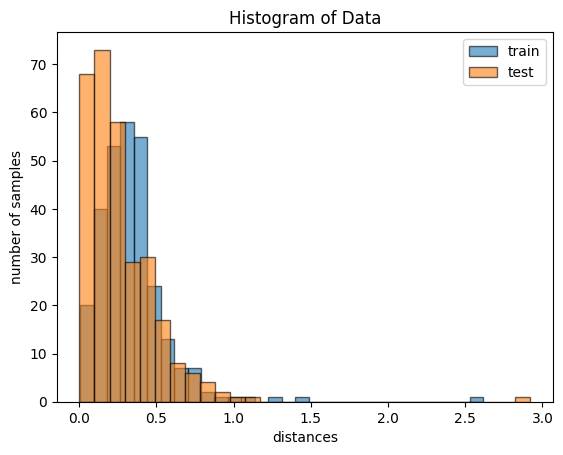

In [14]:
ind_train = torch.nonzero(tear_dis_train < 5, as_tuple=True)[0]
ind_test = torch.nonzero(tear_dis_test < 5, as_tuple=True)[0]
import matplotlib.pyplot as plt
%matplotlib inline
# 绘制直方图
plt.hist(tear_dis_train[ind_train].numpy(), bins=30, edgecolor='black',alpha=0.6,label='train')  # 设置直方图的箱数和边界颜色
plt.hist(tear_dis_test[ind_test].numpy(), bins=30, edgecolor='black',alpha=0.6,label='test') 
plt.title('Histogram of Data')
plt.xlabel('distances')
plt.ylabel('number of samples')
plt.legend()
plt.show()  # 显示图形

# 定性分析

## Boundary Attack 直方图

C:\Users\hp\AppData\Local\Temp\ipykernel_12848\1488257193.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()  # 显示图形


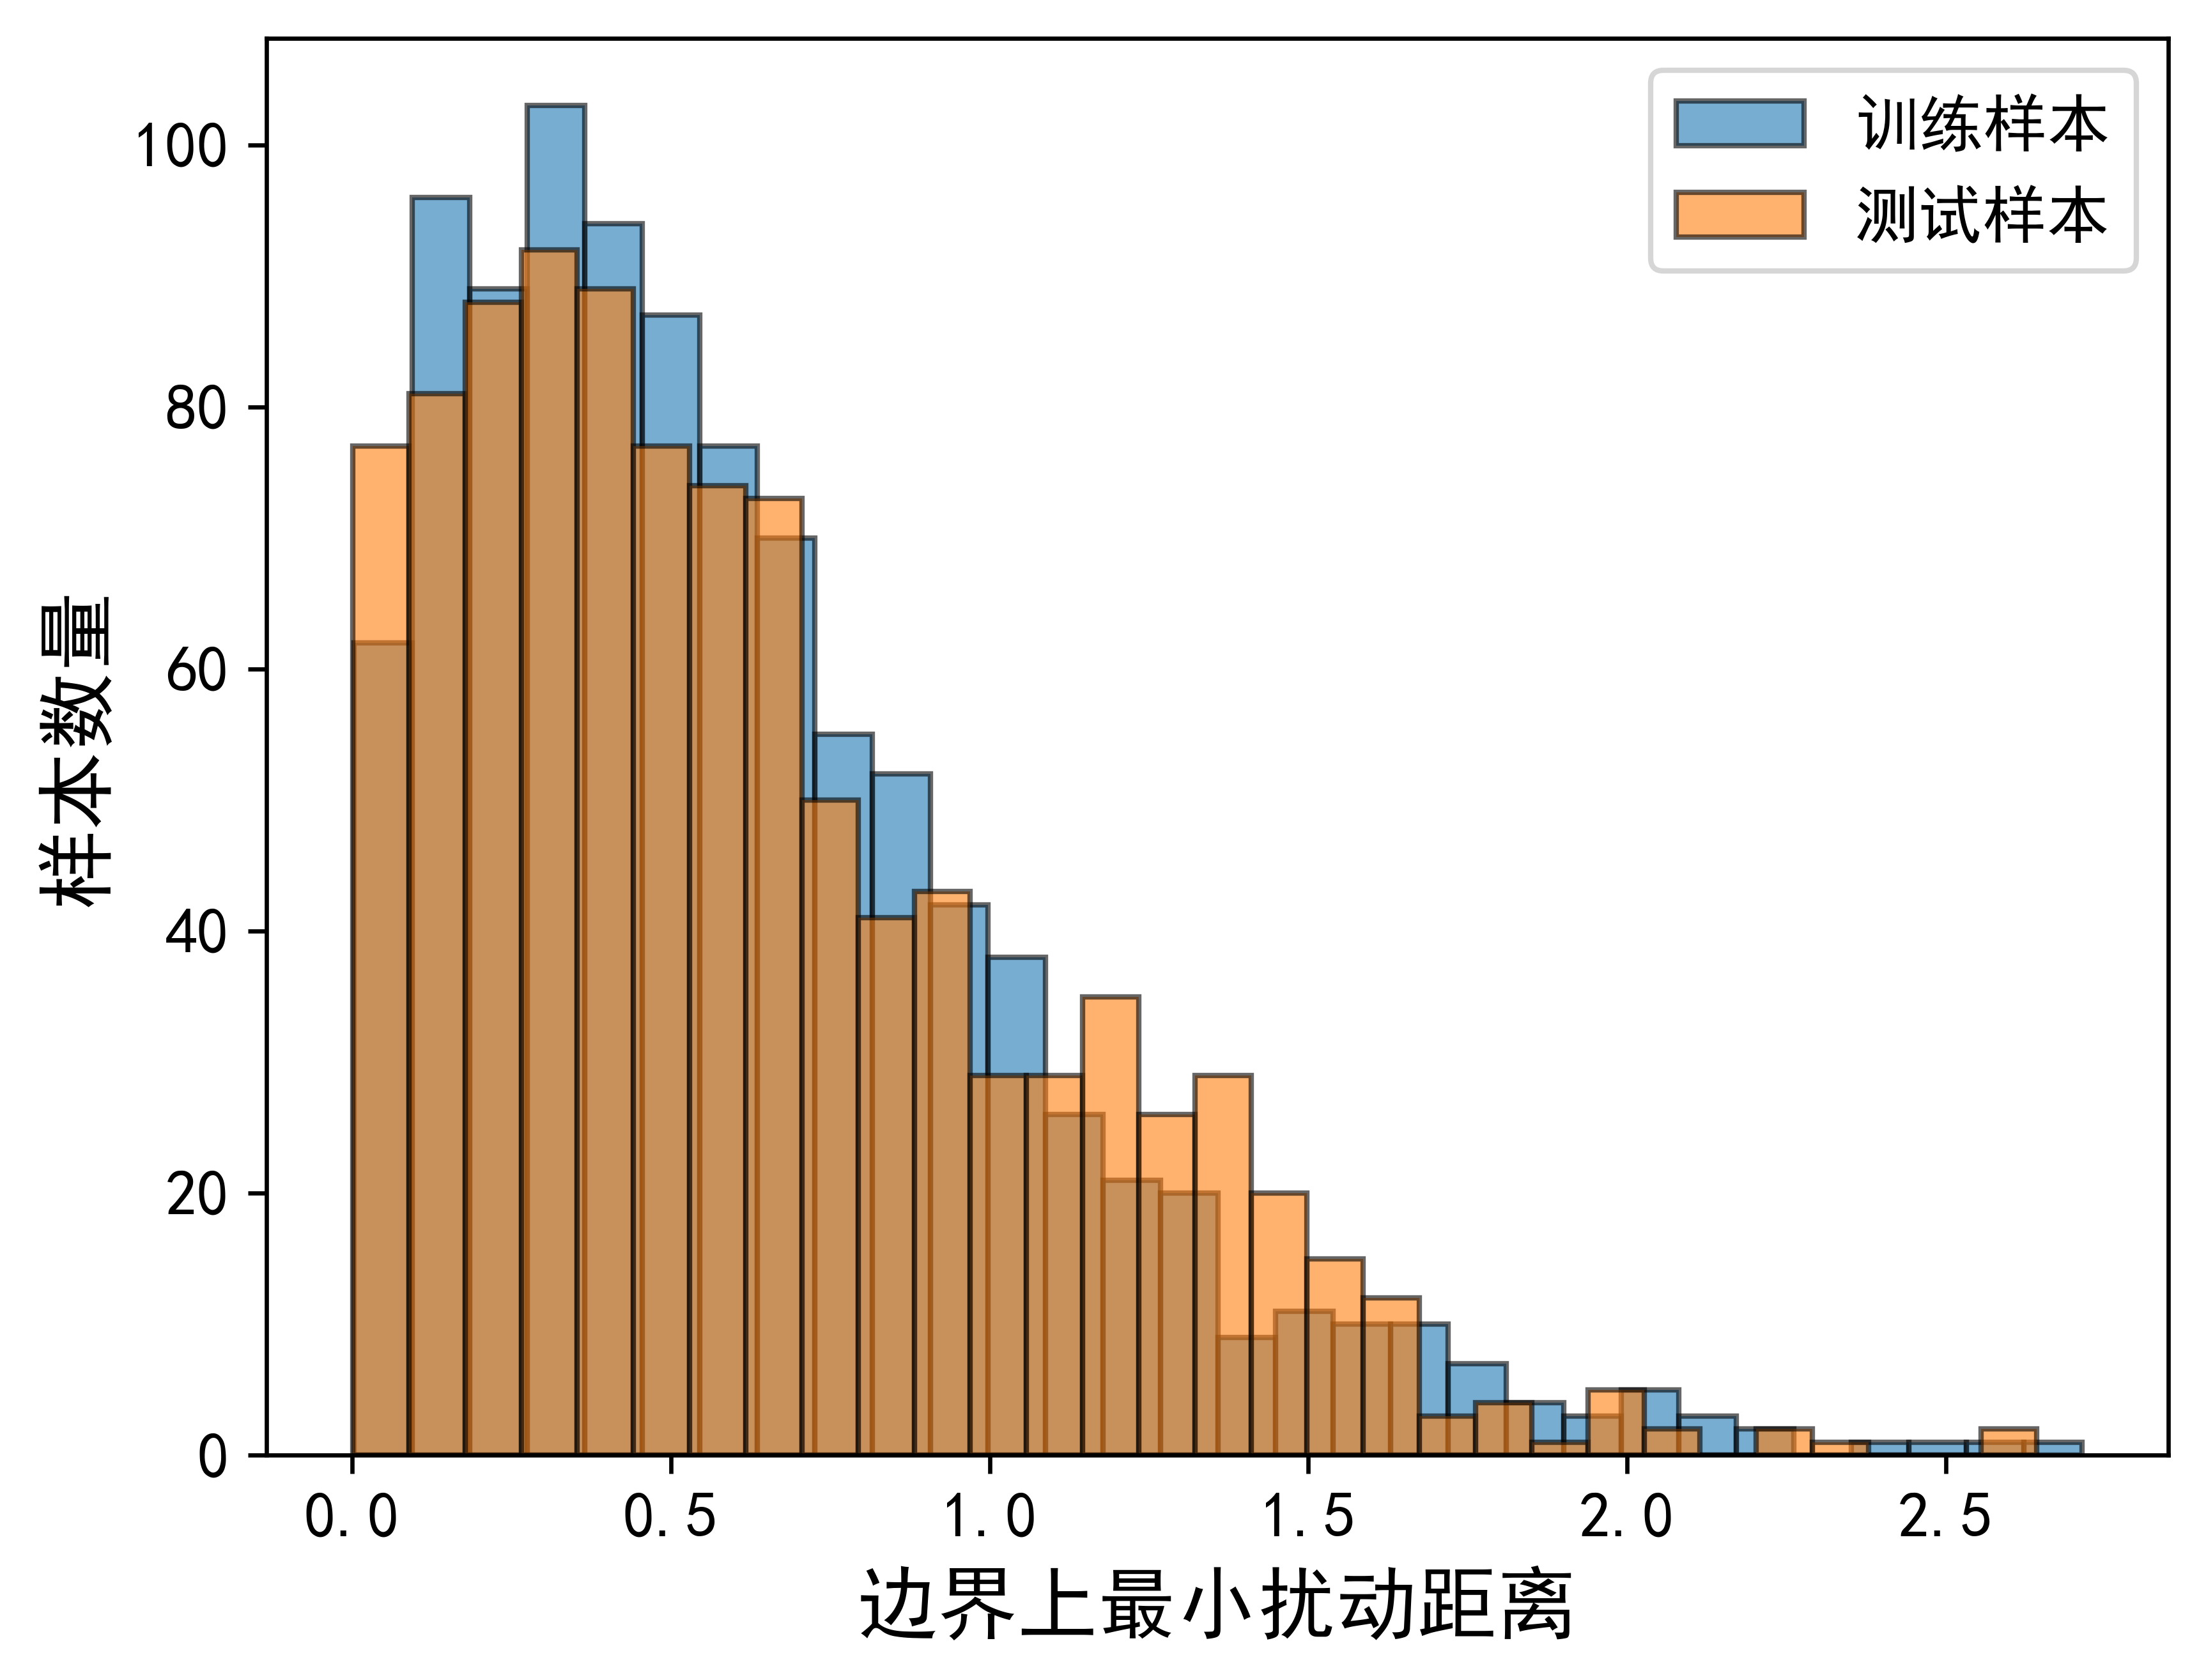

In [4]:
distances_train = torch.load('F:/data_tear/pic/' + str(FL_params.data_name) + '_distrain.pth')
distances_test = torch.load('F:/data_tear/pic/' + str(FL_params.data_name) + '_distest.pth')

distance_train_bd = torch.min(distances_train, dim=1)[0]  #(samnum,)
distance_test_bd = torch.min(distances_test, dim=1)[0]  #(samnum,)
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
fig = plt.figure(dpi=600)
# 绘制直方图
plt.hist(distance_train_bd.numpy(), bins=30, edgecolor='black',alpha=0.6,label='训练样本')  # 设置直方图的箱数和边界颜色
plt.hist(distance_test_bd.numpy(), bins=30, edgecolor='black',alpha=0.6,label='测试样本') 
# plt.title('Histogram of Data')
plt.xlabel('边界上最小扰动距离', fontsize = 15)
plt.ylabel('样本数量', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)
plt.tight_layout()
fig.show()  # 显示图形
plt.savefig('F:/data_tear/pic/data_bdattack.png', dpi=600)

## TEAR直方图

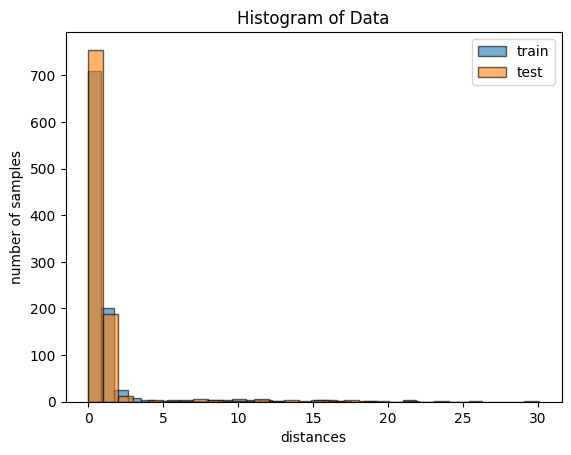

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
tear_dis_train = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/tear_advs_mem.pth')
tear_dis_test = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/tear_advs_nonmem.pth')
# 绘制直方图
plt.hist(tear_dis_train.numpy(), bins=30, edgecolor='black',alpha=0.6,label='train')  # 设置直方图的箱数和边界颜色
plt.hist(tear_dis_test.numpy(), bins=30, edgecolor='black',alpha=0.6,label='test') 
plt.title('Histogram of Data')
plt.xlabel('distances')
plt.ylabel('number of samples')
plt.legend()
plt.show()  # 显示图形

## 投影样本攻击

### 所有点到目标样本点的距离 曲线图

In [6]:
def all_advsdistance(advs_train, advs_test, ori_train, ori_test, FL_params):
    dis_train_ = torch.norm((advs_train - ori_train.unsqueeze(1)).reshape((advs_train.shape[0],advs_train.shape[1],-1)), p=2, dim=-1)  #(samnum, noinum)
    dis_test_ = torch.norm((advs_test - ori_test.unsqueeze(1)).reshape((advs_test.shape[0],advs_test.shape[1],-1)), p=2, dim=-1)  #(samnum, noinum)
    print(dis_train_.shape)
    print(dis_test_.shape)
    return dis_train_, dis_test_
clear_num = FL_params.clear_num
dis_train = torch.zeros((FL_params.sample_num, FL_params.noise_radnum*FL_params.radius_num))
dis_test = torch.zeros((FL_params.sample_num, FL_params.noise_radnum*FL_params.radius_num))
X_tgt_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_tgt_class_{}.pth'.format(clear_num)) 
X_test_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_test_class_{}.pth'.format(clear_num))
for idx in range(5):
    projected_advs_mem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/projected_advs_mem{}.pth'.format(idx))
    projected_advs_nonmem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/projected_advs_nonmem{}.pth'.format(idx))
    dis_train[projected_advs_mem.shape[0]*idx:projected_advs_mem.shape[0]*(idx+1)], dis_test[projected_advs_mem.shape[0]*idx:projected_advs_mem.shape[0]*(idx+1)] = all_advsdistance(projected_advs_mem, projected_advs_nonmem, X_tgt_dataset[projected_advs_mem.shape[0]*idx:projected_advs_mem.shape[0]*(idx+1)], X_test_dataset[projected_advs_mem.shape[0]*idx:projected_advs_mem.shape[0]*(idx+1)], FL_params)
print(dis_train.shape)
print(dis_test.shape)
# torch.save(dis_train, 'F:/data_tear/pic/' + str(FL_params.data_name) + '_alldistrain.pth')
# torch.save(dis_test, 'F:/data_tear/pic/' + str(FL_params.data_name) + '_alldistest.pth')
# print(torch.norm(adv_min_train - X_dataset_tgt_0[:400], p=2, dim=(1,2,3)))
# print(torch.norm(projected_advs_mem - X_dataset_tgt_0[:400].unsqueeze(1), p=2, dim=(2,3,4)))
# print(torch.norm(projected_advs_mem - adv_min_train.unsqueeze(1), p=2, dim=(2,3,4)))
# print(torch.argmax(all_GMs[-1](adv_min_train.cuda()), dim=-1))
# print(torch.argmax(all_GMs[-1](projected_advs_mem[:,1,:,:,:].cuda()), dim=-1))

torch.Size([200, 500])
torch.Size([200, 500])
torch.Size([200, 500])
torch.Size([200, 500])
torch.Size([200, 500])
torch.Size([200, 500])
torch.Size([200, 500])
torch.Size([200, 500])
torch.Size([200, 500])
torch.Size([200, 500])
torch.Size([1000, 500])
torch.Size([1000, 500])


tensor([  8,  39,  48,  78, 109, 170, 175, 239, 325, 346, 359, 364, 375, 407,
        451, 476, 494, 512, 515, 550, 555, 556, 579, 608, 626, 636, 639, 661,
        697, 740, 745, 787, 871, 958, 996])
tensor([ 0.0098, -0.0059, -0.0197,  0.0138,  0.0151,  0.0077,  0.0072,  0.0030,
         0.0067,  0.0113, -0.0067,  0.0191, -0.0048,  0.0055, -0.0122, -0.0103,
         0.0131, -0.0174,  0.0121,  0.0056,  0.0157, -0.0063, -0.0184,  0.0050,
         0.0101,  0.0121,  0.0036, -0.0100,  0.0052, -0.0066, -0.0009,  0.0180,
         0.0176,  0.0147,  0.0020])


C:\Users\hp\AppData\Local\Temp\ipykernel_12848\2529749862.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


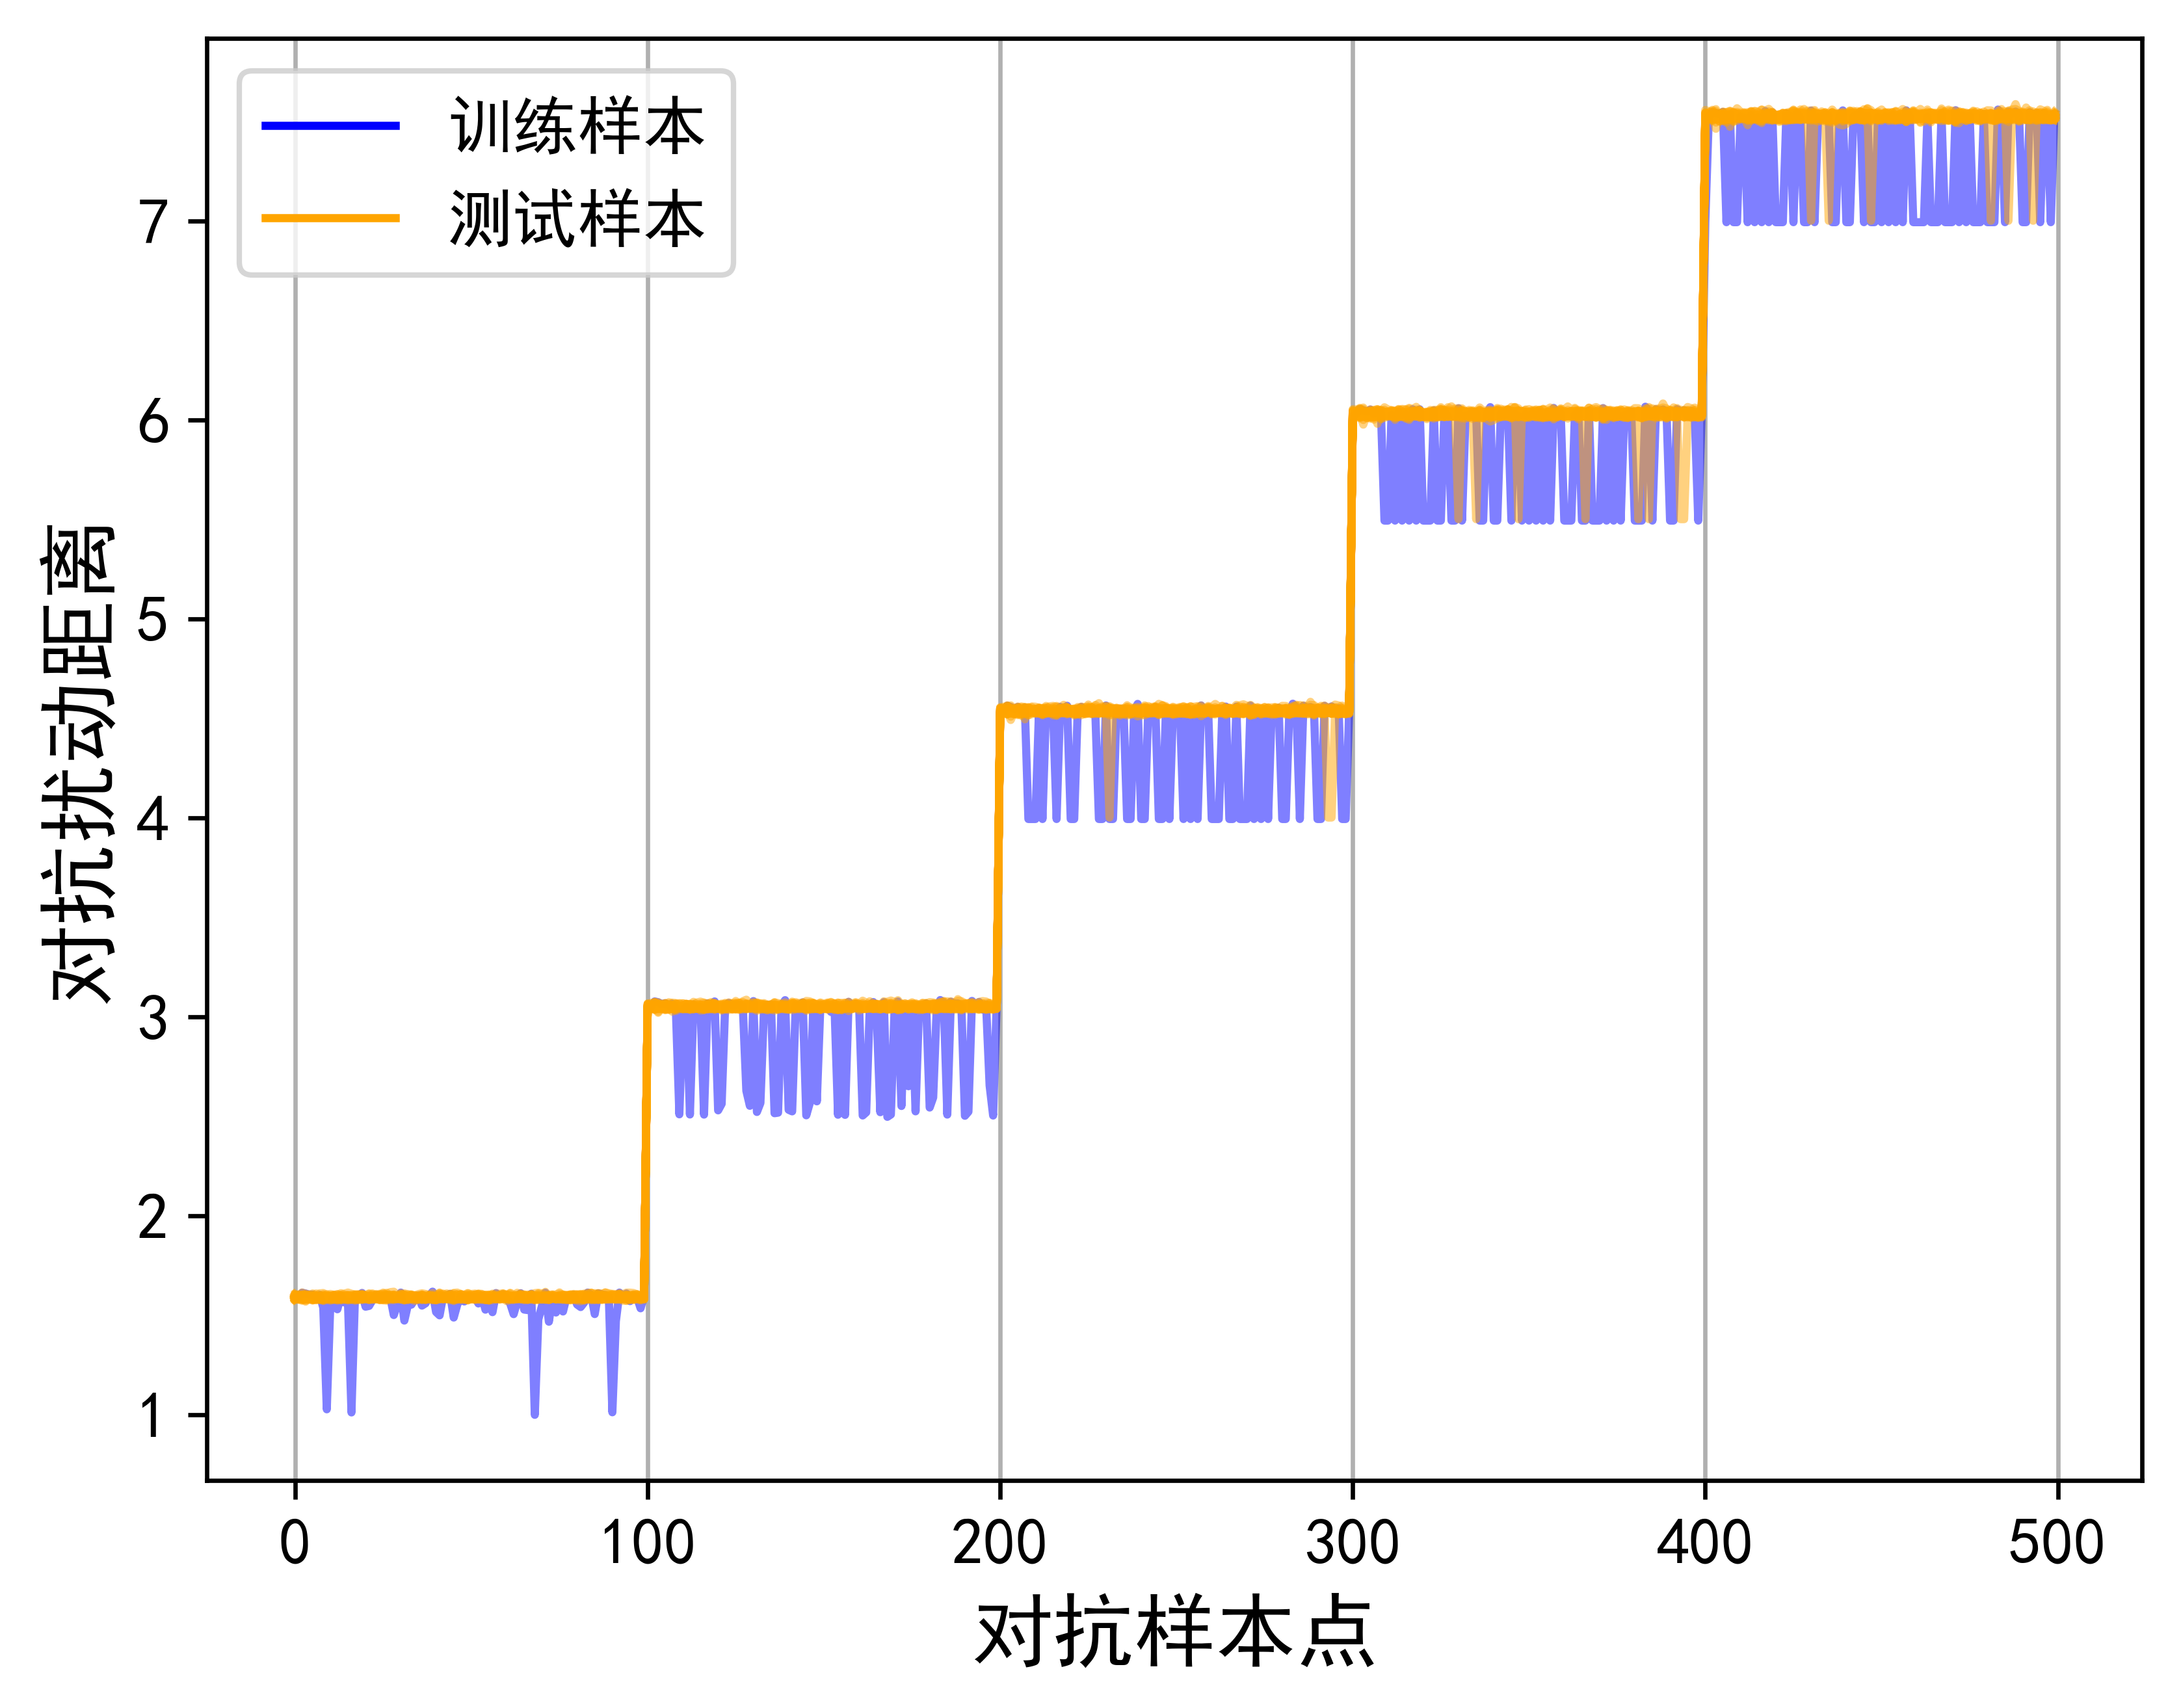

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
dis_train = torch.load('F:/data_tear/pic/' + str(FL_params.data_name) + '_alldistrain.pth')
dis_test = torch.load('F:/data_tear/pic/' + str(FL_params.data_name) + '_alldistest.pth')
distances_train = torch.load('F:/data_tear/pic/' + str(FL_params.data_name) + '_distrain.pth')
distances_test = torch.load('F:/data_tear/pic/' + str(FL_params.data_name) + '_distest.pth')
distance_train_bd = torch.min(distances_train, dim=1)[0]  #(samnum,)
distance_test_bd = torch.min(distances_test, dim=1)[0]  #(samnum,)
itd = 207
def find_min(train_dot, test_list, epsilon):
    delta = torch.abs(train_dot - test_list)
    ind = torch.nonzero(delta < epsilon, as_tuple=True)[0]
    print(ind)
    print((train_dot - test_list)[ind])
    return ind
ind = find_min(distance_train_bd[itd], distance_test_bd, 0.02)
fig = plt.figure(dpi=600)
lines1 = plt.plot(torch.arange(dis_train.shape[1]), dis_train[itd:itd+1].T, color='blue', alpha=0.5)
lines2 = plt.plot(torch.arange(dis_test.shape[1]), dis_test[ind].T, color='orange', alpha=0.5)
# plt.title('advs_distance')
plt.xlabel('对抗样本点', fontsize=15)
plt.ylabel('对抗扰动距离', fontsize=15)
plt.xticks(range(0,dis_train.shape[1]+1,100), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x')
legend = plt.legend([lines1[0], lines2[0]], ['训练样本', '测试样本'], fontsize=12)
for line in legend.get_lines():
    line.set_alpha(1)
fig.show()
plt.savefig('F:/data_tear/pic/cifar10_trajectory_local.png', dpi=600)

### 随着半径增加，起伏开始增加

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
clear_num = FL_params.clear_num
X_tgt_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_tgt_class_{}.pth'.format(clear_num)) 
X_test_dataset = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/X_test_class_{}.pth'.format(clear_num))
dis_train = torch.zeros((FL_params.sample_num, FL_params.noise_radnum*FL_params.radius_num))
dis_test = torch.zeros((FL_params.sample_num, FL_params.noise_radnum*FL_params.radius_num))
for idx in range(5):
    projected_advs_mem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/projected_advs_mem{}.pth'.format(idx))
    projected_advs_nonmem = torch.load('./tear_come/data/' + str(FL_params.data_name) + '/projected_advs_nonmem{}.pth'.format(idx))
    dis_train[projected_advs_mem.shape[0]*idx:projected_advs_mem.shape[0]*(idx+1)] = torch.norm((projected_advs_mem - X_tgt_dataset[projected_advs_mem.shape[0]*idx:projected_advs_mem.shape[0]*(idx+1)].unsqueeze(1)).reshape((projected_advs_mem.shape[0],projected_advs_mem.shape[1],-1)), p=2, dim=-1)  #(samnum, noinum)
    dis_test[projected_advs_nonmem.shape[0]*idx:projected_advs_nonmem.shape[0]*(idx+1)] = torch.norm((projected_advs_nonmem - X_test_dataset[projected_advs_nonmem.shape[0]*idx:projected_advs_nonmem.shape[0]*(idx+1)].unsqueeze(1)).reshape((projected_advs_nonmem.shape[0],projected_advs_nonmem.shape[1],-1)), p=2, dim=-1)  #(samnum, noinum)
dis_train_var = list()
dis_test_var = list()
for idx in range(5):
    dis_train_var.append(torch.var(dis_train[:, int(dis_train.shape[1]/5*idx) : int(dis_train.shape[1]/5*(idx+1))], dim=-1))
    dis_test_var.append(torch.var(dis_test[:, int(dis_test.shape[1]/5*idx) : int(dis_test.shape[1]/5*(idx+1))], dim=-1))
dis_train_var = torch.vstack(dis_train_var)   #(5,400)
dis_test_var = torch.vstack(dis_test_var)
# dis_train_var = dis_train_var[:,torch.where(dis_train_var[-1]<=0.2)[0]]
# torch.save(dis_train_var, 'F:/data_tear/pic/' + str(FL_params.data_name) + '_distrainvar.pth')
# torch.save(dis_test_var, 'F:/data_tear/pic/' + str(FL_params.data_name) + '_distestvar.pth')

KeyboardInterrupt: 

tensor([316, 402, 510, 513, 696, 703, 853])
tensor([ 0.0172, -0.0099,  0.0033,  0.0125,  0.0132,  0.0185, -0.0143])


<Figure size 640x480 with 0 Axes>

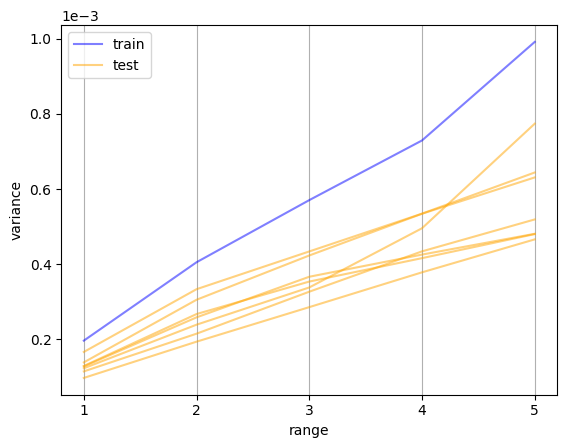

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
distances_train = torch.load('F:/data_tear/pic/' + str(FL_params.data_name) + '_distrain.pth')
distances_test = torch.load('F:/data_tear/pic/' + str(FL_params.data_name) + '_distest.pth')
distance_train_bd = torch.min(distances_train, dim=1)[0]  #(samnum,)
distance_test_bd = torch.min(distances_test, dim=1)[0]  #(samnum,)
def find_min(train_dot, test_list, epsilon):
    delta = torch.abs(train_dot - test_list)
    ind = torch.nonzero(delta < epsilon, as_tuple=True)[0]
    print(ind)
    print((train_dot - test_list)[ind])
    return ind
ind = find_min(distance_train_bd[0], distance_test_bd, 0.02)
dis_train_var = torch.load('F:/data_tear/pic/' + str(FL_params.data_name) + '_distrainvar.pth')
dis_test_var = torch.load('F:/data_tear/pic/' + str(FL_params.data_name) + '_distestvar.pth')
plt.figure()
fig, ax = plt.subplots()
line3 = ax.plot(torch.arange(dis_train_var.shape[0]), dis_train_var[:,0], alpha=0.5, color='blue')
line4 = ax.plot(torch.arange(dis_test_var.shape[0]), dis_test_var[:,ind], alpha=0.5, color='orange')
# plt.title('radius-var')
plt.xlabel('range')
plt.ylabel('variance')
ax.legend([line3[0], line4[0]], ['train','test'])
plt.xticks(range(0,5,1))
ax.set_xticklabels([str(tick) for tick in range(1,6,1)])
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.grid(axis='x')
plt.show()

In [14]:
dis_train_var = torch.load('F:/data_tear/pic/' + str(FL_params.data_name) + '_distrainvar.pth')
dis_test_var = torch.load('F:/data_tear/pic/' + str(FL_params.data_name) + '_distestvar.pth')
ind = torch.nonzero(dis_train_var[2] > 0.02, as_tuple=True)[0]
print(ind)
# plt.figure()
# line3 = plt.plot(torch.arange(dis_train_var.shape[0]), dis_train_var, alpha=0.1, color='blue')
# line4 = plt.plot(torch.arange(dis_test_var.shape[0]), dis_test_var, alpha=0.1, color='orange')
# plt.title('radius-var')
# plt.xlabel('radius')
# plt.ylabel('var')
# plt.legend([line3[0], line4[0]], ['train','test'])
# plt.xticks(range(1,6,1))
# plt.grid(axis='x')
# plt.show()

tensor([207, 637, 797, 951])
